# LightGBM
- Author: Kimberly Yeo
- Module: Capstone
- Date: 16/3/2022

## Import packages

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import snscrape.modules.twitter as sntwitter
import nltk
from datetime import datetime
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

## Load Bitcoin and Tweets data

In [2]:
final_df = pd.read_csv("tweets_bitcoin.csv")

## TFIDF

In [3]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(final_df['Text'])

In [4]:
df1 = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
final_df.drop('Text', axis=1, inplace=True)
final_df = pd.concat([final_df, df1], axis=1)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
train = final_df[:-29].dropna()
test = final_df[-29:].dropna()

In [6]:
train.head()

,Date,Obs_Vol,aaron,aav,aayog,abaco,abakus,abandon,abat,abbc,...,zuckbuck,zuckerberg,zug,zulutrad,zurich,zytara,álvarez,ángel,ștefan,аre
0,2018-09-30,0.013610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-10-01,0.613488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-10-02,0.561735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-10-03,1.117252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-10-04,0.807727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## LightGBM Trial

In [7]:
lgb_model = lgb.LGBMRegressor(learning_rate=0.005,max_depth=5,random_state=42)
lgb_model.fit(train[df1.columns], train["Obs_Vol"], eval_set=[(test[df1.columns], test["Obs_Vol"]),(train[df1.columns], train["Obs_Vol"])],
          verbose=20,eval_metric='logloss')

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 804.846	valid_1's l2: 2790.8
[40]	valid_0's l2: 810.222	valid_1's l2: 2750.76
[60]	valid_0's l2: 811.616	valid_1's l2: 2714.31
[80]	valid_0's l2: 818.441	valid_1's l2: 2679.53
[100]	valid_0's l2: 823.626	valid_1's l2: 2645.64


LGBMRegressor(learning_rate=0.005, max_depth=5, random_state=42)

In [8]:
y_pred = lgb_model.predict(test[df1.columns])
mae = mean_absolute_error(test["Obs_Vol"], y_pred)
mse = mean_squared_error(test["Obs_Vol"], y_pred)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)

MAE: 18.083
MSE: 823.626


## Create a 1-day lag for TFIDF

In [9]:
lag1_df = final_df.copy()

In [10]:
lag1_df = pd.concat([final_df["Date"], lag1_df.iloc[:,1:].shift(1)], axis=1)

## Create n-day lags for TFIDF

In [11]:
def get_lag_df(n_lag, final_df):
    lag_df = final_df.copy()
    lag_df = pd.concat([final_df[["Date", "Obs_Vol"]], lag_df.iloc[:,2:].shift(n_lag)], axis=1)
    return lag_df

In [12]:
lag_dict = {}
for i in range(1, 10):
    lag_dict["lag{}_df".format(i)] = get_lag_df(i, final_df).dropna()

In [13]:
# Lag tuning function which produces elbow plot
def lag_tuning(lag_dict, accur_metric):
    min_mae = 0
    min_mse = 0
    count = 1
    lag_score_df = pd.DataFrame(columns = ["lag", accur_metric])
    for k in lag_dict.keys():
        df = lag_dict[k]
        train = df[:-count].dropna()
        test = df[-count:].dropna()
        lgb_model = lgb.LGBMRegressor(learning_rate=0.005,max_depth=5,random_state=42)
        lgb_model.fit(train[df1.columns], train["Obs_Vol"], eval_set=[(test[df1.columns], test["Obs_Vol"]),(train[df1.columns], train["Obs_Vol"])],
          verbose=20,eval_metric='logloss')
        y_pred = lgb_model.predict(test[df1.columns])
        if accur_metric == "mae":
            mae = mean_absolute_error(test["Obs_Vol"], y_pred)
            if count == 0:
                min_mae = mae
                best_lag = k
            else:
                if min_mae > mae:
                    min_mae = mae
            lag_score_df = lag_score_df.append({"lag": count, accur_metric: mae}, ignore_index=True)
        elif accur_metric == "mse":
            mse = mean_squared_error(test["Obs_Vol"], y_pred)
            if count == 1:
                min_mse = mse
                best_lag = k
            else:
                if min_mse > mse:
                    min_mse = mse
            lag_score_df = lag_score_df.append({"lag": count+1, accur_metric: mse}, ignore_index=True)
        count += 1
    plt.plot(lag_score_df["lag"], lag_score_df[accur_metric], 'go-', linewidth=2)
    plt.xlabel("lag")
    plt.ylabel(accur_metric)
    plt.show()
    return lag_score_df

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 28.3325	valid_1's l2: 2743.49
[40]	valid_0's l2: 23.94	valid_1's l2: 2707.03
[60]	valid_0's l2: 22.8443	valid_1's l2: 2673.44
[80]	valid_0's l2: 24.7107	valid_1's l2: 2641.24
[100]	valid_0's l2: 27.5991	valid_1's l2: 2610.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 58.6547	valid_1's l2: 2750.93
[40]	valid_0's l2: 58.0698	valid_1's l2: 2716.22
[60]	valid_0's l2: 59.0751	valid_1's l2: 2684.35
[80]	valid_0's l2: 62.9982	valid_1's l2: 2654.47
[100]	valid_0's l2: 66.8441	valid_1's l2: 2625.54


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 133.351	valid_1's l2: 2754.22
[40]	valid_0's l2: 156.883	valid_1's l2: 2718.07
[60]	valid_0's l2: 189.171	valid_1's l2: 2684.74
[80]	valid_0's l2: 225.264	valid_1's l2: 2652.25
[100]	valid_0's l2: 246.33	valid_1's l2: 2621.09


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 169.6	valid_1's l2: 2762.26
[40]	valid_0's l2: 188.084	valid_1's l2: 2726.89
[60]	valid_0's l2: 209.177	valid_1's l2: 2690.94
[80]	valid_0's l2: 231.005	valid_1's l2: 2656.52
[100]	valid_0's l2: 250.498	valid_1's l2: 2624.27


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 120.025	valid_1's l2: 2764.72
[40]	valid_0's l2: 114.639	valid_1's l2: 2727.33
[60]	valid_0's l2: 109.313	valid_1's l2: 2692.82
[80]	valid_0's l2: 104.227	valid_1's l2: 2660.05
[100]	valid_0's l2: 99.9636	valid_1's l2: 2629.24


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 108.965	valid_1's l2: 2765.12
[40]	valid_0's l2: 105.522	valid_1's l2: 2726.37
[60]	valid_0's l2: 104.506	valid_1's l2: 2692.67
[80]	valid_0's l2: 106.467	valid_1's l2: 2661.39
[100]	valid_0's l2: 111.742	valid_1's l2: 2632.09


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 228.885	valid_1's l2: 2774.32
[40]	valid_0's l2: 228.49	valid_1's l2: 2738.03
[60]	valid_0's l2: 235.969	valid_1's l2: 2703.17
[80]	valid_0's l2: 245.18	valid_1's l2: 2670.44
[100]	valid_0's l2: 252.979	valid_1's l2: 2640.56


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 227.172	valid_1's l2: 2772.34
[40]	valid_0's l2: 231.743	valid_1's l2: 2734.36
[60]	valid_0's l2: 240.224	valid_1's l2: 2699.32
[80]	valid_0's l2: 245.519	valid_1's l2: 2666.74
[100]	valid_0's l2: 253.906	valid_1's l2: 2636.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 823.168	valid_1's l2: 2779.45
[40]	valid_0's l2: 820.941	valid_1's l2: 2742.28
[60]	valid_0's l2: 819.986	valid_1's l2: 2707.86
[80]	valid_0's l2: 826.204	valid_1's l2: 2675.23
[100]	valid_0's l2: 845.85	valid_1's l2: 2644.01


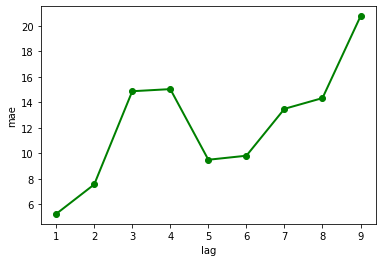

CPU times: user 4h 46min 31s, sys: 2.19 s, total: 4h 46min 34s
Wall time: 35min 32s


,lag,mae
0,1.0,5.253487
1,2.0,7.565494
2,3.0,14.878429
3,4.0,15.044093
4,5.0,9.503036
5,6.0,9.819256
6,7.0,13.497476
7,8.0,14.341243
8,9.0,20.760986


In [14]:
%%time
lag_tuning(lag_dict, "mae")

In [25]:
# Choosing lag_5 as the best dataframe with 5-day lagged tfidf features
df = lag_dict["lag5_df"]

## Date specific feature engineering

In [26]:
df['Date'] = pd.to_datetime(df['Date'])

In [27]:
df['Year'] = df['Date'].dt.year 
df['Month'] = df['Date'].dt.month 
df['Day'] = df['Date'].dt.day

df['dayofweek_num'] = df['Date'].dt.dayofweek  
# df['dayofweek_name']= df['Date'].dt.weekday_name

In [28]:
df

,Date,Obs_Vol,aaron,aav,aayog,abaco,abakus,abandon,abat,abbc,...,Day,dayofweek_num,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
5,2018-10-05,0.207422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-10-06,0.572715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,5,0.207422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-10-07,0.000346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7,6,0.572715,0.207422,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-10-08,0.255549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,0,0.000346,0.572715,0.207422,NaN,NaN,NaN,NaN,NaN
9,2018-10-09,0.148203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,1,0.255549,0.000346,0.572715,0.207422,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,2021-09-24,23.222015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,4,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447,1.743323,29.491320
1083,2021-09-25,0.279093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25,5,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447,29.016698
1084,2021-09-26,0.829626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26,6,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163,28.346478
1085,2021-09-27,6.211249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27,0,0.829626,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766,16.107261


## Lags for observed volatility

In [29]:
def get_lags(lag_start, lag_end, df):
    for i in range(lag_start, lag_end):
        df['lag_'+str(i)] = df.Obs_Vol.shift(i)
    return df

In [30]:
df = get_lags(1, 8, df)

In [31]:
df

,Date,Obs_Vol,aaron,aav,aayog,abaco,abakus,abandon,abat,abbc,...,Day,dayofweek_num,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
5,2018-10-05,0.207422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-10-06,0.572715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,5,0.207422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-10-07,0.000346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7,6,0.572715,0.207422,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-10-08,0.255549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,0,0.000346,0.572715,0.207422,NaN,NaN,NaN,NaN,NaN
9,2018-10-09,0.148203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,1,0.255549,0.000346,0.572715,0.207422,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,2021-09-24,23.222015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,4,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447,1.743323,29.491320
1083,2021-09-25,0.279093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25,5,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447,29.016698
1084,2021-09-26,0.829626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26,6,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163,28.346478
1085,2021-09-27,6.211249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27,0,0.829626,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766,16.107261


## Rolling window for observed volatility

In [32]:
df['rolling_mean'] = df['Obs_Vol'].rolling(window=7).mean()

In [33]:
df

,Date,Obs_Vol,aaron,aav,aayog,abaco,abakus,abandon,abat,abbc,...,Day,dayofweek_num,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
5,2018-10-05,0.207422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-10-06,0.572715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,5,0.207422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-10-07,0.000346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7,6,0.572715,0.207422,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-10-08,0.255549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,0,0.000346,0.572715,0.207422,NaN,NaN,NaN,NaN,NaN
9,2018-10-09,0.148203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,1,0.255549,0.000346,0.572715,0.207422,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,2021-09-24,23.222015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,4,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447,1.743323,29.491320
1083,2021-09-25,0.279093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25,5,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447,29.016698
1084,2021-09-26,0.829626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26,6,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163,28.346478
1085,2021-09-27,6.211249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27,0,0.829626,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766,16.107261


## Lag tuning for LightGBM

lag1_df


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 36.8538	valid_1's l2: 2715.7
[40]	valid_0's l2: 38.4458	valid_1's l2: 2635.61
[60]	valid_0's l2: 40.18	valid_1's l2: 2564.15
[80]	valid_0's l2: 44.8708	valid_1's l2: 2499.31
[100]	valid_0's l2: 48.6151	valid_1's l2: 2445.64
MAE: 6.972
MSE: 48.615


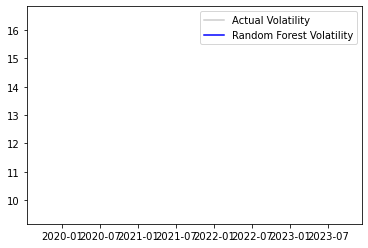

lag2_df


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 58.1478	valid_1's l2: 2718.4
[40]	valid_0's l2: 56.2932	valid_1's l2: 2637.43
[60]	valid_0's l2: 55.6064	valid_1's l2: 2564.44
[80]	valid_0's l2: 57.2037	valid_1's l2: 2501.43
[100]	valid_0's l2: 59.3297	valid_1's l2: 2446.16
MAE: 7.589
MSE: 59.330


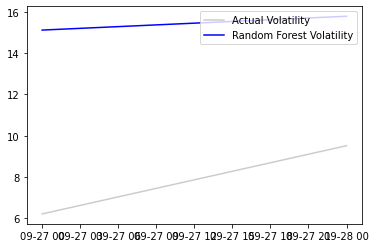

lag3_df


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 115.165	valid_1's l2: 2723.74
[40]	valid_0's l2: 135.947	valid_1's l2: 2644.02
[60]	valid_0's l2: 160.873	valid_1's l2: 2569.12
[80]	valid_0's l2: 196.359	valid_1's l2: 2504.18
[100]	valid_0's l2: 219.576	valid_1's l2: 2447.42
MAE: 12.735
MSE: 219.576


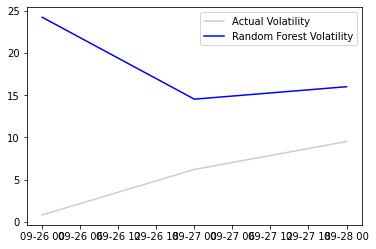

lag4_df


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 172.71	valid_1's l2: 2728.64
[40]	valid_0's l2: 192.332	valid_1's l2: 2648.57
[60]	valid_0's l2: 229.101	valid_1's l2: 2577.34
[80]	valid_0's l2: 289.535	valid_1's l2: 2513.9
[100]	valid_0's l2: 345.619	valid_1's l2: 2460.38
MAE: 16.392
MSE: 345.619


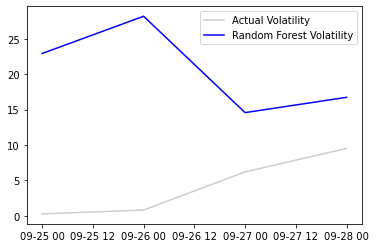

lag5_df


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 146.782	valid_1's l2: 2729.84
[40]	valid_0's l2: 174.291	valid_1's l2: 2648.05
[60]	valid_0's l2: 213.814	valid_1's l2: 2576.61
[80]	valid_0's l2: 263.667	valid_1's l2: 2514.91
[100]	valid_0's l2: 315.934	valid_1's l2: 2462.57
MAE: 14.161
MSE: 315.934


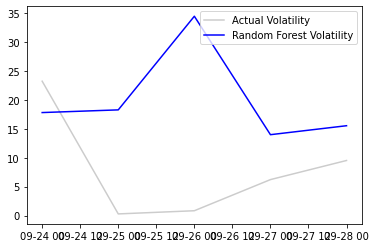

lag6_df


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 131.696	valid_1's l2: 2729.95
[40]	valid_0's l2: 157.553	valid_1's l2: 2645.22
[60]	valid_0's l2: 179.629	valid_1's l2: 2575.61
[80]	valid_0's l2: 190.399	valid_1's l2: 2512.61
[100]	valid_0's l2: 191.677	valid_1's l2: 2455.7
MAE: 12.448
MSE: 191.677


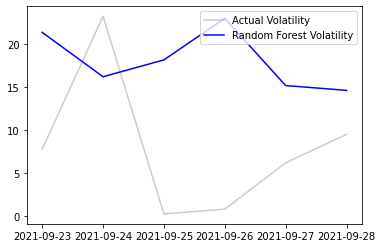

lag7_df


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 254.196	valid_1's l2: 2735.71
[40]	valid_0's l2: 268.253	valid_1's l2: 2651.58
[60]	valid_0's l2: 288.006	valid_1's l2: 2580.37
[80]	valid_0's l2: 317.938	valid_1's l2: 2516.94
[100]	valid_0's l2: 343.97	valid_1's l2: 2463.04
MAE: 15.017
MSE: 343.970


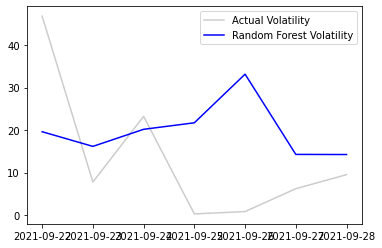

lag8_df


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 251.801	valid_1's l2: 2745.15
[40]	valid_0's l2: 269.161	valid_1's l2: 2663.88
[60]	valid_0's l2: 289.122	valid_1's l2: 2591.84
[80]	valid_0's l2: 330.281	valid_1's l2: 2530.22
[100]	valid_0's l2: 372.821	valid_1's l2: 2478.04
MAE: 14.848
MSE: 372.821


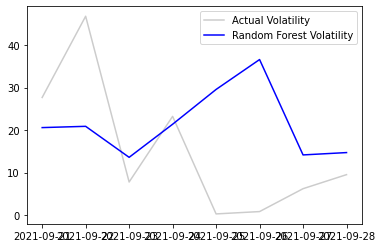

lag9_df


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 840.471	valid_1's l2: 2748.32
[40]	valid_0's l2: 837.151	valid_1's l2: 2670.97
[60]	valid_0's l2: 838.531	valid_1's l2: 2601.1
[80]	valid_0's l2: 843.259	valid_1's l2: 2532.19
[100]	valid_0's l2: 858.337	valid_1's l2: 2473
MAE: 21.175
MSE: 858.337


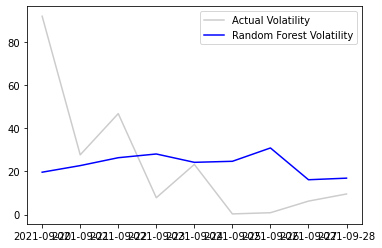

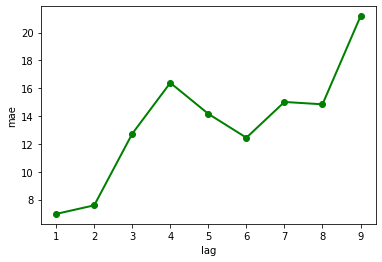

In [35]:
lag_score_df = pd.DataFrame(columns = ["lag", "mae"])
lag_model_dict = {}
for lag in lag_dict.keys():
    print(lag)
    df = lag_dict[lag]
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year 
    df['Month'] = df['Date'].dt.month 
    df['Day'] = df['Date'].dt.day
    df['dayofweek_num'] = df['Date'].dt.dayofweek
    
    df = get_lags(1, 8, df)
    df['rolling_mean'] = df['Obs_Vol'].rolling(window=7).mean()
    
    df = df.dropna()
    df1 = df.iloc[:, 3:]
    
    lag_no = int(lag[3])
    train = df[:-(lag_no)].dropna()
    test = df[-(lag_no):].dropna()
    
    lgb_model = lgb.LGBMRegressor(learning_rate=0.005,max_depth=5,random_state=42)
    lag_model_dict["model_lag{}".format(str(lag_no))] = lgb_model.fit(train[df1.columns], train["Obs_Vol"], eval_set=[(test[df1.columns], test["Obs_Vol"]),(train[df1.columns], train["Obs_Vol"])],
      verbose=20,eval_metric='logloss')
    
    y_pred = lgb_model.predict(test[df1.columns])
    mae = mean_absolute_error(test["Obs_Vol"], y_pred)
    mse = mean_squared_error(test["Obs_Vol"], y_pred)
    print('MAE: %.3f' % mae)
    print('MSE: %.3f' % mse)
    
    # Plotting estimated Random Forest volatility against actual volatility
    pred_vol = pd.DataFrame(y_pred)
    pred_vol.index = test['Date']
    pred_vol = pred_vol.rename(columns={0: "Volatility"})

    actual_vol = pd.DataFrame(test['Obs_Vol'])
    actual_vol.index = test['Date']

    # Plot the actual Bitcoin volatility
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.plot(actual_vol['Obs_Vol'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

    # Plot Random Forest estimated volatility
    plt.plot(pred_vol['Volatility'], color = 'blue', label = 'Random Forest Volatility')

    plt.legend(loc = 'upper right')
    plt.show()
    
    lag_score_df = lag_score_df.append({"lag": lag_no, "mae": mae}, ignore_index=True)
plt.plot(lag_score_df["lag"], lag_score_df["mae"], 'go-', linewidth=2)
plt.xlabel("lag")
plt.ylabel("mae")
plt.show()

In [36]:
lag_model_dict['model_lag6']

LGBMRegressor(learning_rate=0.005, max_depth=5, random_state=42)

## Hyperparameter tuning and lag tuning for LightGBM

In [38]:
# param_grid ={'num_leaves': [6,10], 
#              'min_child_samples': [100, 200, 500], 
#              'min_child_weight': [0.1, 1, 5],
#              'subsample': [0.6, 1.0], 
#              'colsample_bytree': [0.6, 1.0],
#              'reg_alpha': [0, 1, 5],
#              'reg_lambda': [0, 1, 5]}

In [37]:
param_grid ={'num_leaves': [6,10], 
             'min_child_samples': [100, 200], 
             'min_child_weight': [0.1, 1],
             'subsample': [0.6, 1.0], 
             'colsample_bytree': [0.6, 1.0],
             'reg_alpha': [0, 1],
             'reg_lambda': [0, 1]}

In [38]:
def lgbm_tuning(param_grid):
    lag_score_df = pd.DataFrame(columns = ["lag", "mae"])
    for lag in lag_dict.keys():
        print(lag)
        df = lag_dict[lag]

        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year 
        df['Month'] = df['Date'].dt.month 
        df['Day'] = df['Date'].dt.day
        df['dayofweek_num'] = df['Date'].dt.dayofweek

        df = get_lags(1, 8, df)
        df['rolling_mean'] = df['Obs_Vol'].rolling(window=7).mean()

        df = df.dropna()
        df1 = df.iloc[:, 3:]

        lag_no = int(lag[3])
        train = df[:-(lag_no)].dropna()
        test = df[-(lag_no):].dropna()
        
        # Hyperparameter tuning
        n_folds = 5

        lgb_model = GridSearchCV(estimator=lgb.LGBMRegressor(),
                                    param_grid=param_grid,
                                    cv=KFold(n_splits=n_folds,
                                            shuffle=True),
                                     scoring="neg_mean_squared_error")
        
        lgb_model.fit(train[df1.columns], train["Obs_Vol"], eval_set=[(test[df1.columns], test["Obs_Vol"]),(train[df1.columns], train["Obs_Vol"])],
          verbose=20,eval_metric='logloss')

        y_pred = lgb_model.predict(test[df1.columns])
        mae = mean_absolute_error(test["Obs_Vol"], y_pred)
        mse = mean_squared_error(test["Obs_Vol"], y_pred)
        print('MAE: %.3f' % mae)
        print('MSE: %.3f' % mse)

        # Plotting estimated Random Forest volatility against actual volatility
        pred_vol = pd.DataFrame(y_pred)
        pred_vol.index = test['Date']
        pred_vol = pred_vol.rename(columns={0: "Volatility"})

        actual_vol = pd.DataFrame(test['Obs_Vol'])
        actual_vol.index = test['Date']

        # Plot the actual Bitcoin volatility
        # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
        plt.plot(actual_vol['Obs_Vol'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

        # Plot Random Forest estimated volatility
        plt.plot(pred_vol['Volatility'], color = 'blue', label = 'Random Forest Volatility')

        plt.legend(loc = 'upper right')
        plt.show()

        lag_score_df = lag_score_df.append({"lag": lag_no, "mae": mae}, ignore_index=True)
    plt.plot(lag_score_df["lag"], lag_score_df["mae"], 'go-', linewidth=2)
    plt.xlabel("lag")
    plt.ylabel("mae")
    plt.show()
    return model_dict, lag_score_df

In [ ]:
%%time
model_dict, lag_score_df = lgbm_tuning(param_grid)

lag1_df


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 46.9026	valid_1's l2: 2488.75
[40]	valid_0's l2: 33.2656	valid_1's l2: 2359.21
[60]	valid_0's l2: 24.007	valid_1's l2: 2257.04
[80]	valid_0's l2: 4.51269	valid_1's l2: 2173.73
[100]	valid_0's l2: 4.90926	valid_1's l2: 2107.36


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.345	valid_1's l2: 2457.31
[40]	valid_0's l2: 139.147	valid_1's l2: 2334.13
[60]	valid_0's l2: 103.281	valid_1's l2: 2233.45
[80]	valid_0's l2: 73.7962	valid_1's l2: 2151.42
[100]	valid_0's l2: 31.511	valid_1's l2: 2078.81


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 18.3181	valid_1's l2: 2487.28
[40]	valid_0's l2: 10.0431	valid_1's l2: 2335.69
[60]	valid_0's l2: 3.79222	valid_1's l2: 2224.6
[80]	valid_0's l2: 46.2776	valid_1's l2: 2142.74
[100]	valid_0's l2: 105.183	valid_1's l2: 2067.7


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.213	valid_1's l2: 2464.71
[40]	valid_0's l2: 1.3853	valid_1's l2: 2315.79
[60]	valid_0's l2: 1.86975	valid_1's l2: 2207.47
[80]	valid_0's l2: 6.16323	valid_1's l2: 2114.54
[100]	valid_0's l2: 16.55	valid_1's l2: 2040.98


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 17.6977	valid_1's l2: 2556.51
[40]	valid_0's l2: 43.7782	valid_1's l2: 2429.76
[60]	valid_0's l2: 70.8551	valid_1's l2: 2348.56
[80]	valid_0's l2: 45.1713	valid_1's l2: 2267.79
[100]	valid_0's l2: 30.2949	valid_1's l2: 2220.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 46.9026	valid_1's l2: 2488.75
[40]	valid_0's l2: 33.2656	valid_1's l2: 2359.21
[60]	valid_0's l2: 24.007	valid_1's l2: 2257.04
[80]	valid_0's l2: 4.51269	valid_1's l2: 2173.73
[100]	valid_0's l2: 4.90926	valid_1's l2: 2107.36


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.345	valid_1's l2: 2457.31
[40]	valid_0's l2: 139.147	valid_1's l2: 2334.13
[60]	valid_0's l2: 103.281	valid_1's l2: 2233.45
[80]	valid_0's l2: 73.7962	valid_1's l2: 2151.42
[100]	valid_0's l2: 31.511	valid_1's l2: 2078.81


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 18.3181	valid_1's l2: 2487.28
[40]	valid_0's l2: 10.0431	valid_1's l2: 2335.69
[60]	valid_0's l2: 3.79222	valid_1's l2: 2224.6
[80]	valid_0's l2: 46.2776	valid_1's l2: 2142.74
[100]	valid_0's l2: 105.183	valid_1's l2: 2067.7


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.213	valid_1's l2: 2464.71
[40]	valid_0's l2: 1.3853	valid_1's l2: 2315.79
[60]	valid_0's l2: 1.86975	valid_1's l2: 2207.47
[80]	valid_0's l2: 6.16323	valid_1's l2: 2114.54
[100]	valid_0's l2: 16.55	valid_1's l2: 2040.98


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 17.6977	valid_1's l2: 2556.51
[40]	valid_0's l2: 43.7782	valid_1's l2: 2429.76
[60]	valid_0's l2: 70.8551	valid_1's l2: 2348.56
[80]	valid_0's l2: 45.1713	valid_1's l2: 2267.79
[100]	valid_0's l2: 30.2949	valid_1's l2: 2220.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 68.4465	valid_1's l2: 2491.02
[40]	valid_0's l2: 47.0888	valid_1's l2: 2356.85
[60]	valid_0's l2: 30.0748	valid_1's l2: 2257.77
[80]	valid_0's l2: 26.2869	valid_1's l2: 2178.08
[100]	valid_0's l2: 8.11901	valid_1's l2: 2108.61


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 116.916	valid_1's l2: 2458.07
[40]	valid_0's l2: 88.1049	valid_1's l2: 2335.08
[60]	valid_0's l2: 85.514	valid_1's l2: 2231.8
[80]	valid_0's l2: 40.2001	valid_1's l2: 2152.33
[100]	valid_0's l2: 14.0423	valid_1's l2: 2086.86


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 45.7873	valid_1's l2: 2493.28
[40]	valid_0's l2: 11.9054	valid_1's l2: 2341.66
[60]	valid_0's l2: 0.0709186	valid_1's l2: 2232.91
[80]	valid_0's l2: 11.1665	valid_1's l2: 2143.71
[100]	valid_0's l2: 21.4529	valid_1's l2: 2074.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.4777	valid_1's l2: 2465.96
[40]	valid_0's l2: 0.0935056	valid_1's l2: 2320.44
[60]	valid_0's l2: 0.444191	valid_1's l2: 2215.54
[80]	valid_0's l2: 4.81796	valid_1's l2: 2118.88
[100]	valid_0's l2: 6.40319	valid_1's l2: 2040


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 27.0115	valid_1's l2: 2557.49
[40]	valid_0's l2: 68.0651	valid_1's l2: 2431.39
[60]	valid_0's l2: 116.852	valid_1's l2: 2340.34
[80]	valid_0's l2: 70.1723	valid_1's l2: 2266.94
[100]	valid_0's l2: 37.7289	valid_1's l2: 2207.72


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 68.4465	valid_1's l2: 2491.02
[40]	valid_0's l2: 47.0888	valid_1's l2: 2356.85
[60]	valid_0's l2: 30.0748	valid_1's l2: 2257.77
[80]	valid_0's l2: 26.2869	valid_1's l2: 2178.08
[100]	valid_0's l2: 8.11901	valid_1's l2: 2108.61


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 116.916	valid_1's l2: 2458.07
[40]	valid_0's l2: 88.1049	valid_1's l2: 2335.08
[60]	valid_0's l2: 85.514	valid_1's l2: 2231.8
[80]	valid_0's l2: 40.2001	valid_1's l2: 2152.33
[100]	valid_0's l2: 14.0423	valid_1's l2: 2086.86


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 45.7873	valid_1's l2: 2493.28
[40]	valid_0's l2: 11.9054	valid_1's l2: 2341.66
[60]	valid_0's l2: 0.0709186	valid_1's l2: 2232.91
[80]	valid_0's l2: 11.1665	valid_1's l2: 2143.71
[100]	valid_0's l2: 21.4529	valid_1's l2: 2074.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.4777	valid_1's l2: 2465.96
[40]	valid_0's l2: 0.0935056	valid_1's l2: 2320.44
[60]	valid_0's l2: 0.444191	valid_1's l2: 2215.54
[80]	valid_0's l2: 4.81796	valid_1's l2: 2118.88
[100]	valid_0's l2: 6.40319	valid_1's l2: 2040


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 27.0115	valid_1's l2: 2557.49
[40]	valid_0's l2: 68.0651	valid_1's l2: 2431.39
[60]	valid_0's l2: 116.852	valid_1's l2: 2340.34
[80]	valid_0's l2: 70.1723	valid_1's l2: 2266.94
[100]	valid_0's l2: 37.7289	valid_1's l2: 2207.72


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 46.8971	valid_1's l2: 2488.85
[40]	valid_0's l2: 33.2783	valid_1's l2: 2359.38
[60]	valid_0's l2: 24.0281	valid_1's l2: 2257.28
[80]	valid_0's l2: 4.51885	valid_1's l2: 2174.02
[100]	valid_0's l2: 4.91012	valid_1's l2: 2107.72


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 98.81	valid_1's l2: 2457.23
[40]	valid_0's l2: 139.545	valid_1's l2: 2332.86
[60]	valid_0's l2: 91.3057	valid_1's l2: 2229.28
[80]	valid_0's l2: 56.9555	valid_1's l2: 2142.78
[100]	valid_0's l2: 38.4529	valid_1's l2: 2074.41


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 18.3441	valid_1's l2: 2487.39
[40]	valid_0's l2: 10.0473	valid_1's l2: 2335.85
[60]	valid_0's l2: 3.76879	valid_1's l2: 2224.82
[80]	valid_0's l2: 46.1127	valid_1's l2: 2143.02
[100]	valid_0's l2: 141.929	valid_1's l2: 2070.49


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.2449	valid_1's l2: 2464.81
[40]	valid_0's l2: 1.3986	valid_1's l2: 2315.97
[60]	valid_0's l2: 3.22377	valid_1's l2: 2207.79
[80]	valid_0's l2: 8.45406	valid_1's l2: 2114.95
[100]	valid_0's l2: 19.9884	valid_1's l2: 2041.46


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 17.7258	valid_1's l2: 2556.61
[40]	valid_0's l2: 43.8005	valid_1's l2: 2429.91
[60]	valid_0's l2: 70.8663	valid_1's l2: 2348.75
[80]	valid_0's l2: 30.7223	valid_1's l2: 2270.66
[100]	valid_0's l2: 38.5413	valid_1's l2: 2217.73


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 46.8971	valid_1's l2: 2488.85
[40]	valid_0's l2: 33.2783	valid_1's l2: 2359.38
[60]	valid_0's l2: 24.0281	valid_1's l2: 2257.28
[80]	valid_0's l2: 4.51885	valid_1's l2: 2174.02
[100]	valid_0's l2: 4.91012	valid_1's l2: 2107.72


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 98.81	valid_1's l2: 2457.23
[40]	valid_0's l2: 139.545	valid_1's l2: 2332.86
[60]	valid_0's l2: 91.3057	valid_1's l2: 2229.28
[80]	valid_0's l2: 56.9555	valid_1's l2: 2142.78
[100]	valid_0's l2: 38.4529	valid_1's l2: 2074.41


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 18.3441	valid_1's l2: 2487.39
[40]	valid_0's l2: 10.0473	valid_1's l2: 2335.85
[60]	valid_0's l2: 3.76879	valid_1's l2: 2224.82
[80]	valid_0's l2: 46.1127	valid_1's l2: 2143.02
[100]	valid_0's l2: 141.929	valid_1's l2: 2070.49


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.2449	valid_1's l2: 2464.81
[40]	valid_0's l2: 1.3986	valid_1's l2: 2315.97
[60]	valid_0's l2: 3.22377	valid_1's l2: 2207.79
[80]	valid_0's l2: 8.45406	valid_1's l2: 2114.95
[100]	valid_0's l2: 19.9884	valid_1's l2: 2041.46


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 17.7258	valid_1's l2: 2556.61
[40]	valid_0's l2: 43.8005	valid_1's l2: 2429.91
[60]	valid_0's l2: 70.8663	valid_1's l2: 2348.75
[80]	valid_0's l2: 30.7223	valid_1's l2: 2270.66
[100]	valid_0's l2: 38.5413	valid_1's l2: 2217.73


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 68.3909	valid_1's l2: 2491.12
[40]	valid_0's l2: 53.7967	valid_1's l2: 2359.47
[60]	valid_0's l2: 28.0347	valid_1's l2: 2255.43
[80]	valid_0's l2: 28.9938	valid_1's l2: 2176.54
[100]	valid_0's l2: 7.58212	valid_1's l2: 2103.3


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 116.76	valid_1's l2: 2458.15
[40]	valid_0's l2: 87.9859	valid_1's l2: 2335.25
[60]	valid_0's l2: 85.3888	valid_1's l2: 2232.03
[80]	valid_0's l2: 40.156	valid_1's l2: 2152.62
[100]	valid_0's l2: 14.0386	valid_1's l2: 2087.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 45.7722	valid_1's l2: 2493.31
[40]	valid_0's l2: 32.8701	valid_1's l2: 2347.77
[60]	valid_0's l2: 0.0898222	valid_1's l2: 2231.89
[80]	valid_0's l2: 12.7682	valid_1's l2: 2138.87
[100]	valid_0's l2: 18.0996	valid_1's l2: 2067.46


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.5124	valid_1's l2: 2466.05
[40]	valid_0's l2: 0.0883991	valid_1's l2: 2320.6
[60]	valid_0's l2: 0.826547	valid_1's l2: 2215.64
[80]	valid_0's l2: 4.44605	valid_1's l2: 2116.67
[100]	valid_0's l2: 7.70093	valid_1's l2: 2038.72


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 27.0324	valid_1's l2: 2557.59
[40]	valid_0's l2: 68.063	valid_1's l2: 2431.53
[60]	valid_0's l2: 116.777	valid_1's l2: 2340.53
[80]	valid_0's l2: 89.2189	valid_1's l2: 2268.65
[100]	valid_0's l2: 41.0714	valid_1's l2: 2214.62


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 68.3909	valid_1's l2: 2491.12
[40]	valid_0's l2: 53.7967	valid_1's l2: 2359.47
[60]	valid_0's l2: 28.0347	valid_1's l2: 2255.43
[80]	valid_0's l2: 28.9938	valid_1's l2: 2176.54
[100]	valid_0's l2: 7.58212	valid_1's l2: 2103.3


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 116.76	valid_1's l2: 2458.15
[40]	valid_0's l2: 87.9859	valid_1's l2: 2335.25
[60]	valid_0's l2: 85.3888	valid_1's l2: 2232.03
[80]	valid_0's l2: 40.156	valid_1's l2: 2152.62
[100]	valid_0's l2: 14.0386	valid_1's l2: 2087.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 45.7722	valid_1's l2: 2493.31
[40]	valid_0's l2: 32.8701	valid_1's l2: 2347.77
[60]	valid_0's l2: 0.0898222	valid_1's l2: 2231.89
[80]	valid_0's l2: 12.7682	valid_1's l2: 2138.87
[100]	valid_0's l2: 18.0996	valid_1's l2: 2067.46


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.5124	valid_1's l2: 2466.05
[40]	valid_0's l2: 0.0883991	valid_1's l2: 2320.6
[60]	valid_0's l2: 0.826547	valid_1's l2: 2215.64
[80]	valid_0's l2: 4.44605	valid_1's l2: 2116.67
[100]	valid_0's l2: 7.70093	valid_1's l2: 2038.72


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 27.0324	valid_1's l2: 2557.59
[40]	valid_0's l2: 68.063	valid_1's l2: 2431.53
[60]	valid_0's l2: 116.777	valid_1's l2: 2340.53
[80]	valid_0's l2: 89.2189	valid_1's l2: 2268.65
[100]	valid_0's l2: 41.0714	valid_1's l2: 2214.62


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 60.6865	valid_1's l2: 2486.88
[40]	valid_0's l2: 59.3275	valid_1's l2: 2357.15
[60]	valid_0's l2: 21.6751	valid_1's l2: 2253.48
[80]	valid_0's l2: 4.36589	valid_1's l2: 2167.58
[100]	valid_0's l2: 0.348361	valid_1's l2: 2095.62


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 133.641	valid_1's l2: 2453.03
[40]	valid_0's l2: 91.1105	valid_1's l2: 2324.69
[60]	valid_0's l2: 122.858	valid_1's l2: 2223.07
[80]	valid_0's l2: 76.3061	valid_1's l2: 2134.59
[100]	valid_0's l2: 53.3892	valid_1's l2: 2061.03


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 11.3754	valid_1's l2: 2486.26
[40]	valid_0's l2: 2.50698	valid_1's l2: 2329.78
[60]	valid_0's l2: 0.212146	valid_1's l2: 2219.5
[80]	valid_0's l2: 0.000732827	valid_1's l2: 2132.55
[100]	valid_0's l2: 0.356198	valid_1's l2: 2053.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 22.6321	valid_1's l2: 2459.03
[40]	valid_0's l2: 10.6243	valid_1's l2: 2314.55
[60]	valid_0's l2: 0.380567	valid_1's l2: 2202.86
[80]	valid_0's l2: 5.79333	valid_1's l2: 2108.78
[100]	valid_0's l2: 8.41352	valid_1's l2: 2027.41


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 55.2242	valid_1's l2: 2550.37
[40]	valid_0's l2: 100.197	valid_1's l2: 2423.17
[60]	valid_0's l2: 89.0039	valid_1's l2: 2341.75
[80]	valid_0's l2: 97.2255	valid_1's l2: 2265.31
[100]	valid_0's l2: 38.2864	valid_1's l2: 2202.69


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 60.6865	valid_1's l2: 2486.88
[40]	valid_0's l2: 59.3275	valid_1's l2: 2357.15
[60]	valid_0's l2: 21.6751	valid_1's l2: 2253.48
[80]	valid_0's l2: 4.36589	valid_1's l2: 2167.58
[100]	valid_0's l2: 0.348361	valid_1's l2: 2095.62


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 133.641	valid_1's l2: 2453.03
[40]	valid_0's l2: 91.1105	valid_1's l2: 2324.69
[60]	valid_0's l2: 122.858	valid_1's l2: 2223.07
[80]	valid_0's l2: 76.3061	valid_1's l2: 2134.59
[100]	valid_0's l2: 53.3892	valid_1's l2: 2061.03


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 11.3754	valid_1's l2: 2486.26
[40]	valid_0's l2: 2.50698	valid_1's l2: 2329.78
[60]	valid_0's l2: 0.212146	valid_1's l2: 2219.5
[80]	valid_0's l2: 0.000732827	valid_1's l2: 2132.55
[100]	valid_0's l2: 0.356198	valid_1's l2: 2053.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 22.6321	valid_1's l2: 2459.03
[40]	valid_0's l2: 10.6243	valid_1's l2: 2314.55
[60]	valid_0's l2: 0.380567	valid_1's l2: 2202.86
[80]	valid_0's l2: 5.79333	valid_1's l2: 2108.78
[100]	valid_0's l2: 8.41352	valid_1's l2: 2027.41


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 55.2242	valid_1's l2: 2550.37
[40]	valid_0's l2: 100.197	valid_1's l2: 2423.17
[60]	valid_0's l2: 89.0039	valid_1's l2: 2341.75
[80]	valid_0's l2: 97.2255	valid_1's l2: 2265.31
[100]	valid_0's l2: 38.2864	valid_1's l2: 2202.69


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 65.0132	valid_1's l2: 2487.48
[40]	valid_0's l2: 47.5272	valid_1's l2: 2352.8
[60]	valid_0's l2: 49.6743	valid_1's l2: 2251.88
[80]	valid_0's l2: 21.63	valid_1's l2: 2164.42
[100]	valid_0's l2: 15.6869	valid_1's l2: 2093.81


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 110.659	valid_1's l2: 2457.62
[40]	valid_0's l2: 67.5643	valid_1's l2: 2325.68
[60]	valid_0's l2: 82.4869	valid_1's l2: 2226.18
[80]	valid_0's l2: 81.9899	valid_1's l2: 2142.87
[100]	valid_0's l2: 31.0408	valid_1's l2: 2074.24


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 24.0572	valid_1's l2: 2486.39
[40]	valid_0's l2: 12.0168	valid_1's l2: 2335.14
[60]	valid_0's l2: 4.44343	valid_1's l2: 2222.06
[80]	valid_0's l2: 1.05516	valid_1's l2: 2132.58
[100]	valid_0's l2: 9.31927	valid_1's l2: 2057.15


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.472	valid_1's l2: 2462.45
[40]	valid_0's l2: 7.04608	valid_1's l2: 2317.34
[60]	valid_0's l2: 0.319136	valid_1's l2: 2204.98
[80]	valid_0's l2: 3.94264	valid_1's l2: 2104.72
[100]	valid_0's l2: 14.4399	valid_1's l2: 2028.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 45.5132	valid_1's l2: 2547.15
[40]	valid_0's l2: 99.4514	valid_1's l2: 2424.85
[60]	valid_0's l2: 128.214	valid_1's l2: 2339.4
[80]	valid_0's l2: 47.9496	valid_1's l2: 2265.02
[100]	valid_0's l2: 22.668	valid_1's l2: 2209.63


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 65.0132	valid_1's l2: 2487.48
[40]	valid_0's l2: 47.5272	valid_1's l2: 2352.8
[60]	valid_0's l2: 49.6743	valid_1's l2: 2251.88
[80]	valid_0's l2: 21.63	valid_1's l2: 2164.42
[100]	valid_0's l2: 15.6869	valid_1's l2: 2093.81


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 110.659	valid_1's l2: 2457.62
[40]	valid_0's l2: 67.5643	valid_1's l2: 2325.68
[60]	valid_0's l2: 82.4869	valid_1's l2: 2226.18
[80]	valid_0's l2: 81.9899	valid_1's l2: 2142.87
[100]	valid_0's l2: 31.0408	valid_1's l2: 2074.24


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 24.0572	valid_1's l2: 2486.39
[40]	valid_0's l2: 12.0168	valid_1's l2: 2335.14
[60]	valid_0's l2: 4.44343	valid_1's l2: 2222.06
[80]	valid_0's l2: 1.05516	valid_1's l2: 2132.58
[100]	valid_0's l2: 9.31927	valid_1's l2: 2057.15


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.472	valid_1's l2: 2462.45
[40]	valid_0's l2: 7.04608	valid_1's l2: 2317.34
[60]	valid_0's l2: 0.319136	valid_1's l2: 2204.98
[80]	valid_0's l2: 3.94264	valid_1's l2: 2104.72
[100]	valid_0's l2: 14.4399	valid_1's l2: 2028.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 45.5132	valid_1's l2: 2547.15
[40]	valid_0's l2: 99.4514	valid_1's l2: 2424.85
[60]	valid_0's l2: 128.214	valid_1's l2: 2339.4
[80]	valid_0's l2: 47.9496	valid_1's l2: 2265.02
[100]	valid_0's l2: 22.668	valid_1's l2: 2209.63


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 60.655	valid_1's l2: 2487
[40]	valid_0's l2: 53.8723	valid_1's l2: 2357.55
[60]	valid_0's l2: 22.1324	valid_1's l2: 2251.2
[80]	valid_0's l2: 17.7526	valid_1's l2: 2166.13
[100]	valid_0's l2: 4.04099	valid_1's l2: 2086.45


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 133.431	valid_1's l2: 2453.12
[40]	valid_0's l2: 91.0078	valid_1's l2: 2324.88
[60]	valid_0's l2: 129.493	valid_1's l2: 2223.11
[80]	valid_0's l2: 80.631	valid_1's l2: 2136.97
[100]	valid_0's l2: 20.4767	valid_1's l2: 2063.49


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 11.3956	valid_1's l2: 2486.39
[40]	valid_0's l2: 3.41416	valid_1's l2: 2331.96
[60]	valid_0's l2: 2.79934	valid_1's l2: 2210.74
[80]	valid_0's l2: 8.94341	valid_1's l2: 2122.69
[100]	valid_0's l2: 44.1839	valid_1's l2: 2046.3


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 22.6672	valid_1's l2: 2459.13
[40]	valid_0's l2: 10.6517	valid_1's l2: 2314.73
[60]	valid_0's l2: 0.385698	valid_1's l2: 2203.11
[80]	valid_0's l2: 5.76635	valid_1's l2: 2109.09
[100]	valid_0's l2: 8.33681	valid_1's l2: 2027.8


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 55.2161	valid_1's l2: 2550.48
[40]	valid_0's l2: 139.816	valid_1's l2: 2422.34
[60]	valid_0's l2: 123.046	valid_1's l2: 2338.16
[80]	valid_0's l2: 52.1474	valid_1's l2: 2266.64
[100]	valid_0's l2: 59.8763	valid_1's l2: 2215.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 60.655	valid_1's l2: 2487
[40]	valid_0's l2: 53.8723	valid_1's l2: 2357.55
[60]	valid_0's l2: 22.1324	valid_1's l2: 2251.2
[80]	valid_0's l2: 17.7526	valid_1's l2: 2166.13
[100]	valid_0's l2: 4.04099	valid_1's l2: 2086.45


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 133.431	valid_1's l2: 2453.12
[40]	valid_0's l2: 91.0078	valid_1's l2: 2324.88
[60]	valid_0's l2: 129.493	valid_1's l2: 2223.11
[80]	valid_0's l2: 80.631	valid_1's l2: 2136.97
[100]	valid_0's l2: 20.4767	valid_1's l2: 2063.49


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 11.3956	valid_1's l2: 2486.39
[40]	valid_0's l2: 3.41416	valid_1's l2: 2331.96
[60]	valid_0's l2: 2.79934	valid_1's l2: 2210.74
[80]	valid_0's l2: 8.94341	valid_1's l2: 2122.69
[100]	valid_0's l2: 44.1839	valid_1's l2: 2046.3


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 22.6672	valid_1's l2: 2459.13
[40]	valid_0's l2: 10.6517	valid_1's l2: 2314.73
[60]	valid_0's l2: 0.385698	valid_1's l2: 2203.11
[80]	valid_0's l2: 5.76635	valid_1's l2: 2109.09
[100]	valid_0's l2: 8.33681	valid_1's l2: 2027.8


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 55.2161	valid_1's l2: 2550.48
[40]	valid_0's l2: 139.816	valid_1's l2: 2422.34
[60]	valid_0's l2: 123.046	valid_1's l2: 2338.16
[80]	valid_0's l2: 52.1474	valid_1's l2: 2266.64
[100]	valid_0's l2: 59.8763	valid_1's l2: 2215.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 71.4814	valid_1's l2: 2488.42
[40]	valid_0's l2: 91.757	valid_1's l2: 2356.5
[60]	valid_0's l2: 56.984	valid_1's l2: 2257.32
[80]	valid_0's l2: 72.3021	valid_1's l2: 2173.82
[100]	valid_0's l2: 25.8433	valid_1's l2: 2100.36


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 105.798	valid_1's l2: 2456.84
[40]	valid_0's l2: 159.164	valid_1's l2: 2329.83
[60]	valid_0's l2: 197.524	valid_1's l2: 2227.28
[80]	valid_0's l2: 147.917	valid_1's l2: 2141.69
[100]	valid_0's l2: 61.1176	valid_1's l2: 2064.05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 24.0725	valid_1's l2: 2486.49
[40]	valid_0's l2: 13.2604	valid_1's l2: 2335.43
[60]	valid_0's l2: 4.54958	valid_1's l2: 2220.04
[80]	valid_0's l2: 11.4466	valid_1's l2: 2132.55
[100]	valid_0's l2: 19.3478	valid_1's l2: 2054.86


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.6045	valid_1's l2: 2462.61
[40]	valid_0's l2: 9.70443	valid_1's l2: 2319.74
[60]	valid_0's l2: 0.398777	valid_1's l2: 2212.39
[80]	valid_0's l2: 5.63943	valid_1's l2: 2114.96
[100]	valid_0's l2: 13.6799	valid_1's l2: 2036.61


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 45.5215	valid_1's l2: 2547.26
[40]	valid_0's l2: 99.3822	valid_1's l2: 2425.01
[60]	valid_0's l2: 128.13	valid_1's l2: 2339.6
[80]	valid_0's l2: 47.9845	valid_1's l2: 2265.28
[100]	valid_0's l2: 22.6967	valid_1's l2: 2209.93


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 71.4814	valid_1's l2: 2488.42
[40]	valid_0's l2: 91.757	valid_1's l2: 2356.5
[60]	valid_0's l2: 56.984	valid_1's l2: 2257.32
[80]	valid_0's l2: 72.3021	valid_1's l2: 2173.82
[100]	valid_0's l2: 25.8433	valid_1's l2: 2100.36


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 105.798	valid_1's l2: 2456.84
[40]	valid_0's l2: 159.164	valid_1's l2: 2329.83
[60]	valid_0's l2: 197.524	valid_1's l2: 2227.28
[80]	valid_0's l2: 147.917	valid_1's l2: 2141.69
[100]	valid_0's l2: 61.1176	valid_1's l2: 2064.05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 24.0725	valid_1's l2: 2486.49
[40]	valid_0's l2: 13.2604	valid_1's l2: 2335.43
[60]	valid_0's l2: 4.54958	valid_1's l2: 2220.04
[80]	valid_0's l2: 11.4466	valid_1's l2: 2132.55
[100]	valid_0's l2: 19.3478	valid_1's l2: 2054.86


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.6045	valid_1's l2: 2462.61
[40]	valid_0's l2: 9.70443	valid_1's l2: 2319.74
[60]	valid_0's l2: 0.398777	valid_1's l2: 2212.39
[80]	valid_0's l2: 5.63943	valid_1's l2: 2114.96
[100]	valid_0's l2: 13.6799	valid_1's l2: 2036.61


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 45.5215	valid_1's l2: 2547.26
[40]	valid_0's l2: 99.3822	valid_1's l2: 2425.01
[60]	valid_0's l2: 128.13	valid_1's l2: 2339.6
[80]	valid_0's l2: 47.9845	valid_1's l2: 2265.28
[100]	valid_0's l2: 22.6967	valid_1's l2: 2209.93


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 46.9026	valid_1's l2: 2488.75
[40]	valid_0's l2: 33.2656	valid_1's l2: 2359.21
[60]	valid_0's l2: 24.007	valid_1's l2: 2257.04
[80]	valid_0's l2: 4.51269	valid_1's l2: 2173.73
[100]	valid_0's l2: 4.90926	valid_1's l2: 2107.36


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.345	valid_1's l2: 2457.31
[40]	valid_0's l2: 139.147	valid_1's l2: 2334.13
[60]	valid_0's l2: 103.281	valid_1's l2: 2233.45
[80]	valid_0's l2: 73.7962	valid_1's l2: 2151.42
[100]	valid_0's l2: 31.511	valid_1's l2: 2078.81


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 18.3181	valid_1's l2: 2487.28
[40]	valid_0's l2: 10.0431	valid_1's l2: 2335.69
[60]	valid_0's l2: 3.79222	valid_1's l2: 2224.6
[80]	valid_0's l2: 46.2776	valid_1's l2: 2142.74
[100]	valid_0's l2: 105.183	valid_1's l2: 2067.7


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.213	valid_1's l2: 2464.71
[40]	valid_0's l2: 1.3853	valid_1's l2: 2315.79
[60]	valid_0's l2: 1.86975	valid_1's l2: 2207.47
[80]	valid_0's l2: 6.16323	valid_1's l2: 2114.54
[100]	valid_0's l2: 16.55	valid_1's l2: 2040.98


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 17.6977	valid_1's l2: 2556.51
[40]	valid_0's l2: 43.7782	valid_1's l2: 2429.76
[60]	valid_0's l2: 70.8551	valid_1's l2: 2348.56
[80]	valid_0's l2: 45.1713	valid_1's l2: 2267.79
[100]	valid_0's l2: 30.2949	valid_1's l2: 2220.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 46.9026	valid_1's l2: 2488.75
[40]	valid_0's l2: 33.2656	valid_1's l2: 2359.21
[60]	valid_0's l2: 24.007	valid_1's l2: 2257.04
[80]	valid_0's l2: 4.51269	valid_1's l2: 2173.73
[100]	valid_0's l2: 4.90926	valid_1's l2: 2107.36


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.345	valid_1's l2: 2457.31
[40]	valid_0's l2: 139.147	valid_1's l2: 2334.13
[60]	valid_0's l2: 103.281	valid_1's l2: 2233.45
[80]	valid_0's l2: 73.7962	valid_1's l2: 2151.42
[100]	valid_0's l2: 31.511	valid_1's l2: 2078.81


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 18.3181	valid_1's l2: 2487.28
[40]	valid_0's l2: 10.0431	valid_1's l2: 2335.69
[60]	valid_0's l2: 3.79222	valid_1's l2: 2224.6
[80]	valid_0's l2: 46.2776	valid_1's l2: 2142.74
[100]	valid_0's l2: 105.183	valid_1's l2: 2067.7


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.213	valid_1's l2: 2464.71
[40]	valid_0's l2: 1.3853	valid_1's l2: 2315.79
[60]	valid_0's l2: 1.86975	valid_1's l2: 2207.47
[80]	valid_0's l2: 6.16323	valid_1's l2: 2114.54
[100]	valid_0's l2: 16.55	valid_1's l2: 2040.98


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 17.6977	valid_1's l2: 2556.51
[40]	valid_0's l2: 43.7782	valid_1's l2: 2429.76
[60]	valid_0's l2: 70.8551	valid_1's l2: 2348.56
[80]	valid_0's l2: 45.1713	valid_1's l2: 2267.79
[100]	valid_0's l2: 30.2949	valid_1's l2: 2220.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 68.4465	valid_1's l2: 2491.02
[40]	valid_0's l2: 47.0888	valid_1's l2: 2356.85
[60]	valid_0's l2: 30.0748	valid_1's l2: 2257.77
[80]	valid_0's l2: 26.2869	valid_1's l2: 2178.08
[100]	valid_0's l2: 8.11901	valid_1's l2: 2108.61


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 116.916	valid_1's l2: 2458.07
[40]	valid_0's l2: 88.1049	valid_1's l2: 2335.08
[60]	valid_0's l2: 85.514	valid_1's l2: 2231.8
[80]	valid_0's l2: 40.2001	valid_1's l2: 2152.33
[100]	valid_0's l2: 14.0423	valid_1's l2: 2086.86


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 45.7873	valid_1's l2: 2493.28
[40]	valid_0's l2: 11.9054	valid_1's l2: 2341.66
[60]	valid_0's l2: 0.0709186	valid_1's l2: 2232.91
[80]	valid_0's l2: 11.1665	valid_1's l2: 2143.71
[100]	valid_0's l2: 21.4529	valid_1's l2: 2074.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.4777	valid_1's l2: 2465.96
[40]	valid_0's l2: 0.0935056	valid_1's l2: 2320.44
[60]	valid_0's l2: 0.444191	valid_1's l2: 2215.54
[80]	valid_0's l2: 4.81796	valid_1's l2: 2118.88
[100]	valid_0's l2: 6.40319	valid_1's l2: 2040


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 27.0115	valid_1's l2: 2557.49
[40]	valid_0's l2: 68.0651	valid_1's l2: 2431.39
[60]	valid_0's l2: 116.852	valid_1's l2: 2340.34
[80]	valid_0's l2: 70.1723	valid_1's l2: 2266.94
[100]	valid_0's l2: 37.7289	valid_1's l2: 2207.72


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 68.4465	valid_1's l2: 2491.02
[40]	valid_0's l2: 47.0888	valid_1's l2: 2356.85
[60]	valid_0's l2: 30.0748	valid_1's l2: 2257.77
[80]	valid_0's l2: 26.2869	valid_1's l2: 2178.08
[100]	valid_0's l2: 8.11901	valid_1's l2: 2108.61


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 116.916	valid_1's l2: 2458.07
[40]	valid_0's l2: 88.1049	valid_1's l2: 2335.08
[60]	valid_0's l2: 85.514	valid_1's l2: 2231.8
[80]	valid_0's l2: 40.2001	valid_1's l2: 2152.33
[100]	valid_0's l2: 14.0423	valid_1's l2: 2086.86


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 45.7873	valid_1's l2: 2493.28
[40]	valid_0's l2: 11.9054	valid_1's l2: 2341.66
[60]	valid_0's l2: 0.0709186	valid_1's l2: 2232.91
[80]	valid_0's l2: 11.1665	valid_1's l2: 2143.71
[100]	valid_0's l2: 21.4529	valid_1's l2: 2074.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 12.4777	valid_1's l2: 2465.96
[40]	valid_0's l2: 0.0935056	valid_1's l2: 2320.44
[60]	valid_0's l2: 0.444191	valid_1's l2: 2215.54
[80]	valid_0's l2: 4.81796	valid_1's l2: 2118.88
[100]	valid_0's l2: 6.40319	valid_1's l2: 2040


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 27.0115	valid_1's l2: 2557.49
[40]	valid_0's l2: 68.0651	valid_1's l2: 2431.39


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 794.02	valid_1's l2: 2475.05
[40]	valid_0's l2: 665.655	valid_1's l2: 2359.89
[60]	valid_0's l2: 518.244	valid_1's l2: 2270.16
[80]	valid_0's l2: 484.598	valid_1's l2: 2193.34
[100]	valid_0's l2: 384.511	valid_1's l2: 2134.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 91.5103	valid_1's l2: 2488.4
[40]	valid_0's l2: 101.513	valid_1's l2: 2343.42
[60]	valid_0's l2: 149.049	valid_1's l2: 2237.94
[80]	valid_0's l2: 182.945	valid_1's l2: 2138.28
[100]	valid_0's l2: 211.155	valid_1's l2: 2065.83


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 175.551	valid_1's l2: 2459.49
[40]	valid_0's l2: 156.397	valid_1's l2: 2306.61
[60]	valid_0's l2: 132.89	valid_1's l2: 2204.44
[80]	valid_0's l2: 131.809	valid_1's l2: 2112.64
[100]	valid_0's l2: 188.936	valid_1's l2: 2046.09


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 282.166	valid_1's l2: 2470.17
[40]	valid_0's l2: 257.02	valid_1's l2: 2341.09
[60]	valid_0's l2: 251.87	valid_1's l2: 2246.65
[80]	valid_0's l2: 240.986	valid_1's l2: 2156.01
[100]	valid_0's l2: 202.972	valid_1's l2: 2090.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.204	valid_1's l2: 2551.43
[40]	valid_0's l2: 513.313	valid_1's l2: 2457.41
[60]	valid_0's l2: 413.943	valid_1's l2: 2393.57
[80]	valid_0's l2: 383.168	valid_1's l2: 2334.47
[100]	valid_0's l2: 332.967	valid_1's l2: 2290.08


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 794.02	valid_1's l2: 2475.05
[40]	valid_0's l2: 665.655	valid_1's l2: 2359.89
[60]	valid_0's l2: 518.244	valid_1's l2: 2270.16
[80]	valid_0's l2: 484.598	valid_1's l2: 2193.34
[100]	valid_0's l2: 384.511	valid_1's l2: 2134.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 91.5103	valid_1's l2: 2488.4
[40]	valid_0's l2: 101.513	valid_1's l2: 2343.42
[60]	valid_0's l2: 149.049	valid_1's l2: 2237.94
[80]	valid_0's l2: 182.945	valid_1's l2: 2138.28
[100]	valid_0's l2: 211.155	valid_1's l2: 2065.83


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 175.551	valid_1's l2: 2459.49
[40]	valid_0's l2: 156.397	valid_1's l2: 2306.61
[60]	valid_0's l2: 132.89	valid_1's l2: 2204.44
[80]	valid_0's l2: 131.809	valid_1's l2: 2112.64
[100]	valid_0's l2: 188.936	valid_1's l2: 2046.09


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 282.166	valid_1's l2: 2470.17
[40]	valid_0's l2: 257.02	valid_1's l2: 2341.09
[60]	valid_0's l2: 251.87	valid_1's l2: 2246.65
[80]	valid_0's l2: 240.986	valid_1's l2: 2156.01
[100]	valid_0's l2: 202.972	valid_1's l2: 2090.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.204	valid_1's l2: 2551.43
[40]	valid_0's l2: 513.313	valid_1's l2: 2457.41
[60]	valid_0's l2: 413.943	valid_1's l2: 2393.57
[80]	valid_0's l2: 383.168	valid_1's l2: 2334.47
[100]	valid_0's l2: 332.967	valid_1's l2: 2290.08


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 785.689	valid_1's l2: 2476.11
[40]	valid_0's l2: 702.556	valid_1's l2: 2361.45
[60]	valid_0's l2: 532.778	valid_1's l2: 2279.56
[80]	valid_0's l2: 449.735	valid_1's l2: 2197.95
[100]	valid_0's l2: 445.355	valid_1's l2: 2141.03


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 93.2707	valid_1's l2: 2492.48
[40]	valid_0's l2: 80.8501	valid_1's l2: 2343.2
[60]	valid_0's l2: 93.7057	valid_1's l2: 2238.55
[80]	valid_0's l2: 148.188	valid_1's l2: 2144.35
[100]	valid_0's l2: 200.285	valid_1's l2: 2074.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 171.735	valid_1's l2: 2462.32
[40]	valid_0's l2: 200.854	valid_1's l2: 2305.04
[60]	valid_0's l2: 171.859	valid_1's l2: 2195.66
[80]	valid_0's l2: 193.004	valid_1's l2: 2111.96
[100]	valid_0's l2: 228.42	valid_1's l2: 2039.62


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 226.15	valid_1's l2: 2473.53
[40]	valid_0's l2: 242.49	valid_1's l2: 2350.46
[60]	valid_0's l2: 244.402	valid_1's l2: 2251.69
[80]	valid_0's l2: 184.705	valid_1's l2: 2174.98
[100]	valid_0's l2: 155.144	valid_1's l2: 2103.76


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 484.617	valid_1's l2: 2550.11
[40]	valid_0's l2: 493.53	valid_1's l2: 2467.06
[60]	valid_0's l2: 488.887	valid_1's l2: 2405.35
[80]	valid_0's l2: 419.929	valid_1's l2: 2347.89
[100]	valid_0's l2: 356.337	valid_1's l2: 2300.89


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 785.689	valid_1's l2: 2476.11
[40]	valid_0's l2: 702.556	valid_1's l2: 2361.45
[60]	valid_0's l2: 532.778	valid_1's l2: 2279.56
[80]	valid_0's l2: 449.735	valid_1's l2: 2197.95
[100]	valid_0's l2: 445.355	valid_1's l2: 2141.03


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 93.2707	valid_1's l2: 2492.48
[40]	valid_0's l2: 80.8501	valid_1's l2: 2343.2
[60]	valid_0's l2: 93.7057	valid_1's l2: 2238.55
[80]	valid_0's l2: 148.188	valid_1's l2: 2144.35
[100]	valid_0's l2: 200.285	valid_1's l2: 2074.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 171.735	valid_1's l2: 2462.32
[40]	valid_0's l2: 200.854	valid_1's l2: 2305.04
[60]	valid_0's l2: 171.859	valid_1's l2: 2195.66
[80]	valid_0's l2: 193.004	valid_1's l2: 2111.96
[100]	valid_0's l2: 228.42	valid_1's l2: 2039.62


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 226.15	valid_1's l2: 2473.53
[40]	valid_0's l2: 242.49	valid_1's l2: 2350.46
[60]	valid_0's l2: 244.402	valid_1's l2: 2251.69
[80]	valid_0's l2: 184.705	valid_1's l2: 2174.98
[100]	valid_0's l2: 155.144	valid_1's l2: 2103.76


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 484.617	valid_1's l2: 2550.11
[40]	valid_0's l2: 493.53	valid_1's l2: 2467.06
[60]	valid_0's l2: 488.887	valid_1's l2: 2405.35
[80]	valid_0's l2: 419.929	valid_1's l2: 2347.89
[100]	valid_0's l2: 356.337	valid_1's l2: 2300.89


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 793.776	valid_1's l2: 2475.14
[40]	valid_0's l2: 683.491	valid_1's l2: 2360.69
[60]	valid_0's l2: 557.246	valid_1's l2: 2268.84
[80]	valid_0's l2: 490.251	valid_1's l2: 2197.06
[100]	valid_0's l2: 486.937	valid_1's l2: 2138.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 91.5539	valid_1's l2: 2488.5
[40]	valid_0's l2: 101.552	valid_1's l2: 2343.58
[60]	valid_0's l2: 149.015	valid_1's l2: 2238.14
[80]	valid_0's l2: 182.763	valid_1's l2: 2138.53
[100]	valid_0's l2: 210.837	valid_1's l2: 2066.13


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 175.539	valid_1's l2: 2459.59
[40]	valid_0's l2: 156.473	valid_1's l2: 2306.77
[60]	valid_0's l2: 132.945	valid_1's l2: 2204.7
[80]	valid_0's l2: 140.234	valid_1's l2: 2113.12
[100]	valid_0's l2: 148.612	valid_1's l2: 2046.28


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 282.044	valid_1's l2: 2470.26
[40]	valid_0's l2: 257.931	valid_1's l2: 2340.89
[60]	valid_0's l2: 223.809	valid_1's l2: 2249.41
[80]	valid_0's l2: 250.138	valid_1's l2: 2156.41
[100]	valid_0's l2: 227.195	valid_1's l2: 2087.94


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.007	valid_1's l2: 2551.51
[40]	valid_0's l2: 513.191	valid_1's l2: 2457.59
[60]	valid_0's l2: 431.775	valid_1's l2: 2398.38
[80]	valid_0's l2: 420.004	valid_1's l2: 2348.32
[100]	valid_0's l2: 405.135	valid_1's l2: 2298.7


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 793.776	valid_1's l2: 2475.14
[40]	valid_0's l2: 683.491	valid_1's l2: 2360.69
[60]	valid_0's l2: 557.246	valid_1's l2: 2268.84
[80]	valid_0's l2: 490.251	valid_1's l2: 2197.06
[100]	valid_0's l2: 486.937	valid_1's l2: 2138.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 91.5539	valid_1's l2: 2488.5
[40]	valid_0's l2: 101.552	valid_1's l2: 2343.58
[60]	valid_0's l2: 149.015	valid_1's l2: 2238.14
[80]	valid_0's l2: 182.763	valid_1's l2: 2138.53
[100]	valid_0's l2: 210.837	valid_1's l2: 2066.13


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 175.539	valid_1's l2: 2459.59
[40]	valid_0's l2: 156.473	valid_1's l2: 2306.77
[60]	valid_0's l2: 132.945	valid_1's l2: 2204.7
[80]	valid_0's l2: 140.234	valid_1's l2: 2113.12
[100]	valid_0's l2: 148.612	valid_1's l2: 2046.28


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 282.044	valid_1's l2: 2470.26
[40]	valid_0's l2: 257.931	valid_1's l2: 2340.89
[60]	valid_0's l2: 223.809	valid_1's l2: 2249.41
[80]	valid_0's l2: 250.138	valid_1's l2: 2156.41
[100]	valid_0's l2: 227.195	valid_1's l2: 2087.94


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.007	valid_1's l2: 2551.51
[40]	valid_0's l2: 513.191	valid_1's l2: 2457.59
[60]	valid_0's l2: 431.775	valid_1's l2: 2398.38
[80]	valid_0's l2: 420.004	valid_1's l2: 2348.32
[100]	valid_0's l2: 405.135	valid_1's l2: 2298.7


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 785.455	valid_1's l2: 2476.19
[40]	valid_0's l2: 702.61	valid_1's l2: 2361.62
[60]	valid_0's l2: 533.052	valid_1's l2: 2279.79
[80]	valid_0's l2: 450.116	valid_1's l2: 2198.24
[100]	valid_0's l2: 445.735	valid_1's l2: 2141.37


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 93.3167	valid_1's l2: 2492.55
[40]	valid_0's l2: 80.8199	valid_1's l2: 2343.43
[60]	valid_0's l2: 112.114	valid_1's l2: 2235.23
[80]	valid_0's l2: 178.717	valid_1's l2: 2140.84
[100]	valid_0's l2: 209.579	valid_1's l2: 2072.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 171.764	valid_1's l2: 2462.42
[40]	valid_0's l2: 200.894	valid_1's l2: 2305.2
[60]	valid_0's l2: 171.859	valid_1's l2: 2195.88
[80]	valid_0's l2: 192.964	valid_1's l2: 2112.17
[100]	valid_0's l2: 197.68	valid_1's l2: 2049.89


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 226.101	valid_1's l2: 2473.63
[40]	valid_0's l2: 242.503	valid_1's l2: 2350.62
[60]	valid_0's l2: 231.813	valid_1's l2: 2252.5
[80]	valid_0's l2: 216.088	valid_1's l2: 2170.85
[100]	valid_0's l2: 187.256	valid_1's l2: 2102.07


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 484.416	valid_1's l2: 2550.19
[40]	valid_0's l2: 493.451	valid_1's l2: 2467.2
[60]	valid_0's l2: 488.965	valid_1's l2: 2405.54
[80]	valid_0's l2: 413.597	valid_1's l2: 2348.98
[100]	valid_0's l2: 404.139	valid_1's l2: 2309.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 785.455	valid_1's l2: 2476.19
[40]	valid_0's l2: 702.61	valid_1's l2: 2361.62
[60]	valid_0's l2: 533.052	valid_1's l2: 2279.79
[80]	valid_0's l2: 450.116	valid_1's l2: 2198.24
[100]	valid_0's l2: 445.735	valid_1's l2: 2141.37


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 93.3167	valid_1's l2: 2492.55
[40]	valid_0's l2: 80.8199	valid_1's l2: 2343.43
[60]	valid_0's l2: 112.114	valid_1's l2: 2235.23
[80]	valid_0's l2: 178.717	valid_1's l2: 2140.84
[100]	valid_0's l2: 209.579	valid_1's l2: 2072.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 171.764	valid_1's l2: 2462.42
[40]	valid_0's l2: 200.894	valid_1's l2: 2305.2
[60]	valid_0's l2: 171.859	valid_1's l2: 2195.88
[80]	valid_0's l2: 192.964	valid_1's l2: 2112.17
[100]	valid_0's l2: 197.68	valid_1's l2: 2049.89


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 226.101	valid_1's l2: 2473.63
[40]	valid_0's l2: 242.503	valid_1's l2: 2350.62
[60]	valid_0's l2: 231.813	valid_1's l2: 2252.5
[80]	valid_0's l2: 216.088	valid_1's l2: 2170.85
[100]	valid_0's l2: 187.256	valid_1's l2: 2102.07


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 484.416	valid_1's l2: 2550.19
[40]	valid_0's l2: 493.451	valid_1's l2: 2467.2
[60]	valid_0's l2: 488.965	valid_1's l2: 2405.54
[80]	valid_0's l2: 413.597	valid_1's l2: 2348.98
[100]	valid_0's l2: 404.139	valid_1's l2: 2309.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 797.222	valid_1's l2: 2473.04
[40]	valid_0's l2: 742.278	valid_1's l2: 2356.72
[60]	valid_0's l2: 577.733	valid_1's l2: 2263.85
[80]	valid_0's l2: 501.812	valid_1's l2: 2185.65
[100]	valid_0's l2: 464.993	valid_1's l2: 2120.53


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 86.4901	valid_1's l2: 2486.92
[40]	valid_0's l2: 87.2116	valid_1's l2: 2340.08
[60]	valid_0's l2: 125.443	valid_1's l2: 2231.89
[80]	valid_0's l2: 158.89	valid_1's l2: 2138.26
[100]	valid_0's l2: 221.813	valid_1's l2: 2059.23


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 168.129	valid_1's l2: 2458.43
[40]	valid_0's l2: 165.366	valid_1's l2: 2302.23
[60]	valid_0's l2: 150.894	valid_1's l2: 2197.42
[80]	valid_0's l2: 170.918	valid_1's l2: 2107.86
[100]	valid_0's l2: 174.707	valid_1's l2: 2040.46


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 229.031	valid_1's l2: 2471
[40]	valid_0's l2: 200.646	valid_1's l2: 2342.59
[60]	valid_0's l2: 187.027	valid_1's l2: 2244.43
[80]	valid_0's l2: 179.63	valid_1's l2: 2152.73
[100]	valid_0's l2: 151.09	valid_1's l2: 2086.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.491	valid_1's l2: 2548.71
[40]	valid_0's l2: 521.586	valid_1's l2: 2452.82
[60]	valid_0's l2: 554.726	valid_1's l2: 2385.91
[80]	valid_0's l2: 489.245	valid_1's l2: 2339.37
[100]	valid_0's l2: 435.965	valid_1's l2: 2300.61


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 797.222	valid_1's l2: 2473.04
[40]	valid_0's l2: 742.278	valid_1's l2: 2356.72
[60]	valid_0's l2: 577.733	valid_1's l2: 2263.85
[80]	valid_0's l2: 501.812	valid_1's l2: 2185.65
[100]	valid_0's l2: 464.993	valid_1's l2: 2120.53


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 86.4901	valid_1's l2: 2486.92
[40]	valid_0's l2: 87.2116	valid_1's l2: 2340.08
[60]	valid_0's l2: 125.443	valid_1's l2: 2231.89
[80]	valid_0's l2: 158.89	valid_1's l2: 2138.26
[100]	valid_0's l2: 221.813	valid_1's l2: 2059.23


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 168.129	valid_1's l2: 2458.43
[40]	valid_0's l2: 165.366	valid_1's l2: 2302.23
[60]	valid_0's l2: 150.894	valid_1's l2: 2197.42
[80]	valid_0's l2: 170.918	valid_1's l2: 2107.86
[100]	valid_0's l2: 174.707	valid_1's l2: 2040.46


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 229.031	valid_1's l2: 2471
[40]	valid_0's l2: 200.646	valid_1's l2: 2342.59
[60]	valid_0's l2: 187.027	valid_1's l2: 2244.43
[80]	valid_0's l2: 179.63	valid_1's l2: 2152.73
[100]	valid_0's l2: 151.09	valid_1's l2: 2086.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.491	valid_1's l2: 2548.71
[40]	valid_0's l2: 521.586	valid_1's l2: 2452.82
[60]	valid_0's l2: 554.726	valid_1's l2: 2385.91
[80]	valid_0's l2: 489.245	valid_1's l2: 2339.37
[100]	valid_0's l2: 435.965	valid_1's l2: 2300.61


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 792.538	valid_1's l2: 2474.58
[40]	valid_0's l2: 693.002	valid_1's l2: 2355.88
[60]	valid_0's l2: 614.93	valid_1's l2: 2275.25
[80]	valid_0's l2: 538.438	valid_1's l2: 2196.24
[100]	valid_0's l2: 427.877	valid_1's l2: 2123.18


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 97.6629	valid_1's l2: 2489.97
[40]	valid_0's l2: 98.9246	valid_1's l2: 2340.59
[60]	valid_0's l2: 112.597	valid_1's l2: 2229.26
[80]	valid_0's l2: 199.351	valid_1's l2: 2138.33
[100]	valid_0's l2: 219.532	valid_1's l2: 2063.76


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 169.617	valid_1's l2: 2460.48
[40]	valid_0's l2: 180.045	valid_1's l2: 2300
[60]	valid_0's l2: 132.499	valid_1's l2: 2198.78
[80]	valid_0's l2: 157.832	valid_1's l2: 2104.09
[100]	valid_0's l2: 189.569	valid_1's l2: 2035.92


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 228.729	valid_1's l2: 2472.24
[40]	valid_0's l2: 204.874	valid_1's l2: 2344.65
[60]	valid_0's l2: 209.876	valid_1's l2: 2241.07
[80]	valid_0's l2: 167.561	valid_1's l2: 2158.24
[100]	valid_0's l2: 159.114	valid_1's l2: 2087.61


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.3	valid_1's l2: 2549.67
[40]	valid_0's l2: 549.965	valid_1's l2: 2450.16
[60]	valid_0's l2: 535.523	valid_1's l2: 2390.33
[80]	valid_0's l2: 504.61	valid_1's l2: 2342.57
[100]	valid_0's l2: 431.225	valid_1's l2: 2294.73


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 792.538	valid_1's l2: 2474.58
[40]	valid_0's l2: 693.002	valid_1's l2: 2355.88
[60]	valid_0's l2: 614.93	valid_1's l2: 2275.25
[80]	valid_0's l2: 538.438	valid_1's l2: 2196.24
[100]	valid_0's l2: 427.877	valid_1's l2: 2123.18


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 97.6629	valid_1's l2: 2489.97
[40]	valid_0's l2: 98.9246	valid_1's l2: 2340.59
[60]	valid_0's l2: 112.597	valid_1's l2: 2229.26
[80]	valid_0's l2: 199.351	valid_1's l2: 2138.33
[100]	valid_0's l2: 219.532	valid_1's l2: 2063.76


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 169.617	valid_1's l2: 2460.48
[40]	valid_0's l2: 180.045	valid_1's l2: 2300
[60]	valid_0's l2: 132.499	valid_1's l2: 2198.78
[80]	valid_0's l2: 157.832	valid_1's l2: 2104.09
[100]	valid_0's l2: 189.569	valid_1's l2: 2035.92


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 228.729	valid_1's l2: 2472.24
[40]	valid_0's l2: 204.874	valid_1's l2: 2344.65
[60]	valid_0's l2: 209.876	valid_1's l2: 2241.07
[80]	valid_0's l2: 167.561	valid_1's l2: 2158.24
[100]	valid_0's l2: 159.114	valid_1's l2: 2087.61


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.3	valid_1's l2: 2549.67
[40]	valid_0's l2: 549.965	valid_1's l2: 2450.16
[60]	valid_0's l2: 535.523	valid_1's l2: 2390.33
[80]	valid_0's l2: 504.61	valid_1's l2: 2342.57
[100]	valid_0's l2: 431.225	valid_1's l2: 2294.73


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 796.974	valid_1's l2: 2473.13
[40]	valid_0's l2: 747.241	valid_1's l2: 2354.53
[60]	valid_0's l2: 617.403	valid_1's l2: 2256.05
[80]	valid_0's l2: 545.064	valid_1's l2: 2181.14
[100]	valid_0's l2: 490.678	valid_1's l2: 2118.5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 86.5387	valid_1's l2: 2487.03
[40]	valid_0's l2: 87.2601	valid_1's l2: 2340.23
[60]	valid_0's l2: 125.245	valid_1's l2: 2229.71
[80]	valid_0's l2: 161.138	valid_1's l2: 2142.89
[100]	valid_0's l2: 198.559	valid_1's l2: 2065.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 168.14	valid_1's l2: 2458.55
[40]	valid_0's l2: 165.422	valid_1's l2: 2302.41
[60]	valid_0's l2: 150.914	valid_1's l2: 2197.67
[80]	valid_0's l2: 180.832	valid_1's l2: 2103.75
[100]	valid_0's l2: 173.517	valid_1's l2: 2032.5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 228.989	valid_1's l2: 2471.1
[40]	valid_0's l2: 200.683	valid_1's l2: 2342.77
[60]	valid_0's l2: 173.068	valid_1's l2: 2238.28
[80]	valid_0's l2: 175.223	valid_1's l2: 2156.54
[100]	valid_0's l2: 183.351	valid_1's l2: 2089.2


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.286	valid_1's l2: 2548.79
[40]	valid_0's l2: 521.433	valid_1's l2: 2452.98
[60]	valid_0's l2: 554.616	valid_1's l2: 2386.13
[80]	valid_0's l2: 517.656	valid_1's l2: 2337.15
[100]	valid_0's l2: 479.481	valid_1's l2: 2295.96


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 796.974	valid_1's l2: 2473.13
[40]	valid_0's l2: 747.241	valid_1's l2: 2354.53
[60]	valid_0's l2: 617.403	valid_1's l2: 2256.05
[80]	valid_0's l2: 545.064	valid_1's l2: 2181.14
[100]	valid_0's l2: 490.678	valid_1's l2: 2118.5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 86.5387	valid_1's l2: 2487.03
[40]	valid_0's l2: 87.2601	valid_1's l2: 2340.23
[60]	valid_0's l2: 125.245	valid_1's l2: 2229.71
[80]	valid_0's l2: 161.138	valid_1's l2: 2142.89
[100]	valid_0's l2: 198.559	valid_1's l2: 2065.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 168.14	valid_1's l2: 2458.55
[40]	valid_0's l2: 165.422	valid_1's l2: 2302.41
[60]	valid_0's l2: 150.914	valid_1's l2: 2197.67
[80]	valid_0's l2: 180.832	valid_1's l2: 2103.75
[100]	valid_0's l2: 173.517	valid_1's l2: 2032.5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 228.989	valid_1's l2: 2471.1
[40]	valid_0's l2: 200.683	valid_1's l2: 2342.77
[60]	valid_0's l2: 173.068	valid_1's l2: 2238.28
[80]	valid_0's l2: 175.223	valid_1's l2: 2156.54
[100]	valid_0's l2: 183.351	valid_1's l2: 2089.2


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.286	valid_1's l2: 2548.79
[40]	valid_0's l2: 521.433	valid_1's l2: 2452.98
[60]	valid_0's l2: 554.616	valid_1's l2: 2386.13
[80]	valid_0's l2: 517.656	valid_1's l2: 2337.15
[100]	valid_0's l2: 479.481	valid_1's l2: 2295.96


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 792.289	valid_1's l2: 2474.69
[40]	valid_0's l2: 692.725	valid_1's l2: 2356
[60]	valid_0's l2: 563.231	valid_1's l2: 2269.31
[80]	valid_0's l2: 517.119	valid_1's l2: 2191.61
[100]	valid_0's l2: 467.777	valid_1's l2: 2135.03


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.548	valid_1's l2: 2489.68
[40]	valid_0's l2: 96.3949	valid_1's l2: 2345.22
[60]	valid_0's l2: 155.088	valid_1's l2: 2241.86
[80]	valid_0's l2: 181.855	valid_1's l2: 2150.13
[100]	valid_0's l2: 197.18	valid_1's l2: 2070.86


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 169.628	valid_1's l2: 2460.59
[40]	valid_0's l2: 180.039	valid_1's l2: 2300.18
[60]	valid_0's l2: 132.464	valid_1's l2: 2199.02
[80]	valid_0's l2: 157.725	valid_1's l2: 2104.37
[100]	valid_0's l2: 184.241	valid_1's l2: 2034.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 228.688	valid_1's l2: 2472.34
[40]	valid_0's l2: 204.901	valid_1's l2: 2344.82
[60]	valid_0's l2: 209.936	valid_1's l2: 2241.31
[80]	valid_0's l2: 167.635	valid_1's l2: 2158.54
[100]	valid_0's l2: 175.783	valid_1's l2: 2090.22


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.28	valid_1's l2: 2549.8
[40]	valid_0's l2: 524.837	valid_1's l2: 2453.35
[60]	valid_0's l2: 512.638	valid_1's l2: 2396.17
[80]	valid_0's l2: 441.461	valid_1's l2: 2344.13
[100]	valid_0's l2: 374.845	valid_1's l2: 2295.27


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 792.289	valid_1's l2: 2474.69
[40]	valid_0's l2: 692.725	valid_1's l2: 2356
[60]	valid_0's l2: 563.231	valid_1's l2: 2269.31
[80]	valid_0's l2: 517.119	valid_1's l2: 2191.61
[100]	valid_0's l2: 467.777	valid_1's l2: 2135.03


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.548	valid_1's l2: 2489.68
[40]	valid_0's l2: 96.3949	valid_1's l2: 2345.22
[60]	valid_0's l2: 155.088	valid_1's l2: 2241.86
[80]	valid_0's l2: 181.855	valid_1's l2: 2150.13
[100]	valid_0's l2: 197.18	valid_1's l2: 2070.86


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 169.628	valid_1's l2: 2460.59
[40]	valid_0's l2: 180.039	valid_1's l2: 2300.18
[60]	valid_0's l2: 132.464	valid_1's l2: 2199.02
[80]	valid_0's l2: 157.725	valid_1's l2: 2104.37
[100]	valid_0's l2: 184.241	valid_1's l2: 2034.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 228.688	valid_1's l2: 2472.34
[40]	valid_0's l2: 204.901	valid_1's l2: 2344.82
[60]	valid_0's l2: 209.936	valid_1's l2: 2241.31
[80]	valid_0's l2: 167.635	valid_1's l2: 2158.54
[100]	valid_0's l2: 175.783	valid_1's l2: 2090.22


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.28	valid_1's l2: 2549.8
[40]	valid_0's l2: 524.837	valid_1's l2: 2453.35
[60]	valid_0's l2: 512.638	valid_1's l2: 2396.17
[80]	valid_0's l2: 441.461	valid_1's l2: 2344.13
[100]	valid_0's l2: 374.845	valid_1's l2: 2295.27


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 794.02	valid_1's l2: 2475.05
[40]	valid_0's l2: 665.655	valid_1's l2: 2359.89
[60]	valid_0's l2: 518.244	valid_1's l2: 2270.16
[80]	valid_0's l2: 484.598	valid_1's l2: 2193.34
[100]	valid_0's l2: 384.511	valid_1's l2: 2134.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 91.5103	valid_1's l2: 2488.4
[40]	valid_0's l2: 101.513	valid_1's l2: 2343.42
[60]	valid_0's l2: 149.049	valid_1's l2: 2237.94
[80]	valid_0's l2: 182.945	valid_1's l2: 2138.28
[100]	valid_0's l2: 211.155	valid_1's l2: 2065.83


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 175.551	valid_1's l2: 2459.49
[40]	valid_0's l2: 156.397	valid_1's l2: 2306.61
[60]	valid_0's l2: 132.89	valid_1's l2: 2204.44
[80]	valid_0's l2: 131.809	valid_1's l2: 2112.64
[100]	valid_0's l2: 188.936	valid_1's l2: 2046.09


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 282.166	valid_1's l2: 2470.17
[40]	valid_0's l2: 257.02	valid_1's l2: 2341.09
[60]	valid_0's l2: 251.87	valid_1's l2: 2246.65
[80]	valid_0's l2: 240.986	valid_1's l2: 2156.01
[100]	valid_0's l2: 202.972	valid_1's l2: 2090.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.204	valid_1's l2: 2551.43
[40]	valid_0's l2: 513.313	valid_1's l2: 2457.41
[60]	valid_0's l2: 413.943	valid_1's l2: 2393.57
[80]	valid_0's l2: 383.168	valid_1's l2: 2334.47
[100]	valid_0's l2: 332.967	valid_1's l2: 2290.08


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 794.02	valid_1's l2: 2475.05
[40]	valid_0's l2: 665.655	valid_1's l2: 2359.89
[60]	valid_0's l2: 518.244	valid_1's l2: 2270.16
[80]	valid_0's l2: 484.598	valid_1's l2: 2193.34
[100]	valid_0's l2: 384.511	valid_1's l2: 2134.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 91.5103	valid_1's l2: 2488.4
[40]	valid_0's l2: 101.513	valid_1's l2: 2343.42
[60]	valid_0's l2: 149.049	valid_1's l2: 2237.94
[80]	valid_0's l2: 182.945	valid_1's l2: 2138.28
[100]	valid_0's l2: 211.155	valid_1's l2: 2065.83


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 175.551	valid_1's l2: 2459.49
[40]	valid_0's l2: 156.397	valid_1's l2: 2306.61
[60]	valid_0's l2: 132.89	valid_1's l2: 2204.44
[80]	valid_0's l2: 131.809	valid_1's l2: 2112.64
[100]	valid_0's l2: 188.936	valid_1's l2: 2046.09


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 282.166	valid_1's l2: 2470.17
[40]	valid_0's l2: 257.02	valid_1's l2: 2341.09
[60]	valid_0's l2: 251.87	valid_1's l2: 2246.65
[80]	valid_0's l2: 240.986	valid_1's l2: 2156.01
[100]	valid_0's l2: 202.972	valid_1's l2: 2090.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.204	valid_1's l2: 2551.43
[40]	valid_0's l2: 513.313	valid_1's l2: 2457.41
[60]	valid_0's l2: 413.943	valid_1's l2: 2393.57
[80]	valid_0's l2: 383.168	valid_1's l2: 2334.47
[100]	valid_0's l2: 332.967	valid_1's l2: 2290.08


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 785.689	valid_1's l2: 2476.11
[40]	valid_0's l2: 702.556	valid_1's l2: 2361.45
[60]	valid_0's l2: 532.778	valid_1's l2: 2279.56
[80]	valid_0's l2: 449.735	valid_1's l2: 2197.95
[100]	valid_0's l2: 445.355	valid_1's l2: 2141.03


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 93.2707	valid_1's l2: 2492.48
[40]	valid_0's l2: 80.8501	valid_1's l2: 2343.2
[60]	valid_0's l2: 93.7057	valid_1's l2: 2238.55
[80]	valid_0's l2: 148.188	valid_1's l2: 2144.35
[100]	valid_0's l2: 200.285	valid_1's l2: 2074.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 171.735	valid_1's l2: 2462.32
[40]	valid_0's l2: 200.854	valid_1's l2: 2305.04
[60]	valid_0's l2: 171.859	valid_1's l2: 2195.66
[80]	valid_0's l2: 193.004	valid_1's l2: 2111.96
[100]	valid_0's l2: 228.42	valid_1's l2: 2039.62


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 226.15	valid_1's l2: 2473.53
[40]	valid_0's l2: 242.49	valid_1's l2: 2350.46
[60]	valid_0's l2: 244.402	valid_1's l2: 2251.69
[80]	valid_0's l2: 184.705	valid_1's l2: 2174.98
[100]	valid_0's l2: 155.144	valid_1's l2: 2103.76


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 484.617	valid_1's l2: 2550.11
[40]	valid_0's l2: 493.53	valid_1's l2: 2467.06
[60]	valid_0's l2: 488.887	valid_1's l2: 2405.35
[80]	valid_0's l2: 419.929	valid_1's l2: 2347.89
[100]	valid_0's l2: 356.337	valid_1's l2: 2300.89


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 785.689	valid_1's l2: 2476.11
[40]	valid_0's l2: 702.556	valid_1's l2: 2361.45
[60]	valid_0's l2: 532.778	valid_1's l2: 2279.56
[80]	valid_0's l2: 449.735	valid_1's l2: 2197.95
[100]	valid_0's l2: 445.355	valid_1's l2: 2141.03


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 93.2707	valid_1's l2: 2492.48
[40]	valid_0's l2: 80.8501	valid_1's l2: 2343.2
[60]	valid_0's l2: 93.7057	valid_1's l2: 2238.55
[80]	valid_0's l2: 148.188	valid_1's l2: 2144.35
[100]	valid_0's l2: 200.285	valid_1's l2: 2074.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 171.735	valid_1's l2: 2462.32
[40]	valid_0's l2: 200.854	valid_1's l2: 2305.04
[60]	valid_0's l2: 171.859	valid_1's l2: 2195.66
[80]	valid_0's l2: 193.004	valid_1's l2: 2111.96
[100]	valid_0's l2: 228.42	valid_1's l2: 2039.62


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 226.15	valid_1's l2: 2473.53
[40]	valid_0's l2: 242.49	valid_1's l2: 2350.46
[60]	valid_0's l2: 244.402	valid_1's l2: 2251.69
[80]	valid_0's l2: 184.705	valid_1's l2: 2174.98
[100]	valid_0's l2: 155.144	valid_1's l2: 2103.76


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 484.617	valid_1's l2: 2550.11
[40]	valid_0's l2: 493.53	valid_1's l2: 2467.06
[60]	valid_0's l2: 488.887	valid_1's l2: 2405.35
[80]	valid_0's l2: 419.929	valid_1's l2: 2347.89
[100]	valid_0's l2: 356.337	valid_1's l2: 2300.89


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 793.776	valid_1's l2: 2475.14
[40]	valid_0's l2: 683.491	valid_1's l2: 2360.69
[60]	valid_0's l2: 557.246	valid_1's l2: 2268.84
[80]	valid_0's l2: 490.251	valid_1's l2: 2197.06
[100]	valid_0's l2: 486.937	valid_1's l2: 2138.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 91.5539	valid_1's l2: 2488.5
[40]	valid_0's l2: 101.552	valid_1's l2: 2343.58
[60]	valid_0's l2: 149.015	valid_1's l2: 2238.14
[80]	valid_0's l2: 182.763	valid_1's l2: 2138.53
[100]	valid_0's l2: 210.837	valid_1's l2: 2066.13


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 175.539	valid_1's l2: 2459.59
[40]	valid_0's l2: 156.473	valid_1's l2: 2306.77
[60]	valid_0's l2: 132.945	valid_1's l2: 2204.7
[80]	valid_0's l2: 140.234	valid_1's l2: 2113.12
[100]	valid_0's l2: 148.612	valid_1's l2: 2046.28


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 282.044	valid_1's l2: 2470.26
[40]	valid_0's l2: 257.931	valid_1's l2: 2340.89
[60]	valid_0's l2: 223.809	valid_1's l2: 2249.41
[80]	valid_0's l2: 250.138	valid_1's l2: 2156.41
[100]	valid_0's l2: 227.195	valid_1's l2: 2087.94


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.007	valid_1's l2: 2551.51
[40]	valid_0's l2: 513.191	valid_1's l2: 2457.59
[60]	valid_0's l2: 431.775	valid_1's l2: 2398.38
[80]	valid_0's l2: 420.004	valid_1's l2: 2348.32
[100]	valid_0's l2: 405.135	valid_1's l2: 2298.7


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 793.776	valid_1's l2: 2475.14
[40]	valid_0's l2: 683.491	valid_1's l2: 2360.69
[60]	valid_0's l2: 557.246	valid_1's l2: 2268.84
[80]	valid_0's l2: 490.251	valid_1's l2: 2197.06
[100]	valid_0's l2: 486.937	valid_1's l2: 2138.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 91.5539	valid_1's l2: 2488.5
[40]	valid_0's l2: 101.552	valid_1's l2: 2343.58
[60]	valid_0's l2: 149.015	valid_1's l2: 2238.14
[80]	valid_0's l2: 182.763	valid_1's l2: 2138.53
[100]	valid_0's l2: 210.837	valid_1's l2: 2066.13


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 175.539	valid_1's l2: 2459.59
[40]	valid_0's l2: 156.473	valid_1's l2: 2306.77
[60]	valid_0's l2: 132.945	valid_1's l2: 2204.7
[80]	valid_0's l2: 140.234	valid_1's l2: 2113.12
[100]	valid_0's l2: 148.612	valid_1's l2: 2046.28


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 282.044	valid_1's l2: 2470.26
[40]	valid_0's l2: 257.931	valid_1's l2: 2340.89
[60]	valid_0's l2: 223.809	valid_1's l2: 2249.41
[80]	valid_0's l2: 250.138	valid_1's l2: 2156.41
[100]	valid_0's l2: 227.195	valid_1's l2: 2087.94


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.007	valid_1's l2: 2551.51
[40]	valid_0's l2: 513.191	valid_1's l2: 2457.59
[60]	valid_0's l2: 431.775	valid_1's l2: 2398.38
[80]	valid_0's l2: 420.004	valid_1's l2: 2348.32
[100]	valid_0's l2: 405.135	valid_1's l2: 2298.7


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 785.455	valid_1's l2: 2476.19
[40]	valid_0's l2: 702.61	valid_1's l2: 2361.62
[60]	valid_0's l2: 533.052	valid_1's l2: 2279.79
[80]	valid_0's l2: 450.116	valid_1's l2: 2198.24
[100]	valid_0's l2: 445.735	valid_1's l2: 2141.37


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 93.3167	valid_1's l2: 2492.55
[40]	valid_0's l2: 80.8199	valid_1's l2: 2343.43
[60]	valid_0's l2: 112.114	valid_1's l2: 2235.23
[80]	valid_0's l2: 178.717	valid_1's l2: 2140.84
[100]	valid_0's l2: 209.579	valid_1's l2: 2072.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 171.764	valid_1's l2: 2462.42
[40]	valid_0's l2: 200.894	valid_1's l2: 2305.2
[60]	valid_0's l2: 171.859	valid_1's l2: 2195.88
[80]	valid_0's l2: 192.964	valid_1's l2: 2112.17
[100]	valid_0's l2: 197.68	valid_1's l2: 2049.89


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 226.101	valid_1's l2: 2473.63
[40]	valid_0's l2: 242.503	valid_1's l2: 2350.62
[60]	valid_0's l2: 231.813	valid_1's l2: 2252.5
[80]	valid_0's l2: 216.088	valid_1's l2: 2170.85
[100]	valid_0's l2: 187.256	valid_1's l2: 2102.07


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 484.416	valid_1's l2: 2550.19
[40]	valid_0's l2: 493.451	valid_1's l2: 2467.2
[60]	valid_0's l2: 488.965	valid_1's l2: 2405.54
[80]	valid_0's l2: 413.597	valid_1's l2: 2348.98
[100]	valid_0's l2: 404.139	valid_1's l2: 2309.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 785.455	valid_1's l2: 2476.19
[40]	valid_0's l2: 702.61	valid_1's l2: 2361.62
[60]	valid_0's l2: 533.052	valid_1's l2: 2279.79
[80]	valid_0's l2: 450.116	valid_1's l2: 2198.24
[100]	valid_0's l2: 445.735	valid_1's l2: 2141.37


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 93.3167	valid_1's l2: 2492.55
[40]	valid_0's l2: 80.8199	valid_1's l2: 2343.43
[60]	valid_0's l2: 112.114	valid_1's l2: 2235.23
[80]	valid_0's l2: 178.717	valid_1's l2: 2140.84
[100]	valid_0's l2: 209.579	valid_1's l2: 2072.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 171.764	valid_1's l2: 2462.42
[40]	valid_0's l2: 200.894	valid_1's l2: 2305.2
[60]	valid_0's l2: 171.859	valid_1's l2: 2195.88
[80]	valid_0's l2: 192.964	valid_1's l2: 2112.17
[100]	valid_0's l2: 197.68	valid_1's l2: 2049.89


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 226.101	valid_1's l2: 2473.63
[40]	valid_0's l2: 242.503	valid_1's l2: 2350.62
[60]	valid_0's l2: 231.813	valid_1's l2: 2252.5
[80]	valid_0's l2: 216.088	valid_1's l2: 2170.85
[100]	valid_0's l2: 187.256	valid_1's l2: 2102.07


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 484.416	valid_1's l2: 2550.19
[40]	valid_0's l2: 493.451	valid_1's l2: 2467.2
[60]	valid_0's l2: 488.965	valid_1's l2: 2405.54
[80]	valid_0's l2: 413.597	valid_1's l2: 2348.98
[100]	valid_0's l2: 404.139	valid_1's l2: 2309.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 797.222	valid_1's l2: 2473.04
[40]	valid_0's l2: 742.278	valid_1's l2: 2356.72
[60]	valid_0's l2: 577.733	valid_1's l2: 2263.85
[80]	valid_0's l2: 501.812	valid_1's l2: 2185.65
[100]	valid_0's l2: 464.993	valid_1's l2: 2120.53


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 86.4901	valid_1's l2: 2486.92
[40]	valid_0's l2: 87.2116	valid_1's l2: 2340.08
[60]	valid_0's l2: 125.443	valid_1's l2: 2231.89
[80]	valid_0's l2: 158.89	valid_1's l2: 2138.26
[100]	valid_0's l2: 221.813	valid_1's l2: 2059.23


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 168.129	valid_1's l2: 2458.43
[40]	valid_0's l2: 165.366	valid_1's l2: 2302.23
[60]	valid_0's l2: 150.894	valid_1's l2: 2197.42
[80]	valid_0's l2: 170.918	valid_1's l2: 2107.86
[100]	valid_0's l2: 174.707	valid_1's l2: 2040.46


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 229.031	valid_1's l2: 2471
[40]	valid_0's l2: 200.646	valid_1's l2: 2342.59
[60]	valid_0's l2: 187.027	valid_1's l2: 2244.43
[80]	valid_0's l2: 179.63	valid_1's l2: 2152.73
[100]	valid_0's l2: 151.09	valid_1's l2: 2086.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.491	valid_1's l2: 2548.71
[40]	valid_0's l2: 521.586	valid_1's l2: 2452.82
[60]	valid_0's l2: 554.726	valid_1's l2: 2385.91
[80]	valid_0's l2: 489.245	valid_1's l2: 2339.37
[100]	valid_0's l2: 435.965	valid_1's l2: 2300.61


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 797.222	valid_1's l2: 2473.04
[40]	valid_0's l2: 742.278	valid_1's l2: 2356.72
[60]	valid_0's l2: 577.733	valid_1's l2: 2263.85
[80]	valid_0's l2: 501.812	valid_1's l2: 2185.65
[100]	valid_0's l2: 464.993	valid_1's l2: 2120.53


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 86.4901	valid_1's l2: 2486.92
[40]	valid_0's l2: 87.2116	valid_1's l2: 2340.08
[60]	valid_0's l2: 125.443	valid_1's l2: 2231.89
[80]	valid_0's l2: 158.89	valid_1's l2: 2138.26
[100]	valid_0's l2: 221.813	valid_1's l2: 2059.23


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 168.129	valid_1's l2: 2458.43
[40]	valid_0's l2: 165.366	valid_1's l2: 2302.23
[60]	valid_0's l2: 150.894	valid_1's l2: 2197.42
[80]	valid_0's l2: 170.918	valid_1's l2: 2107.86
[100]	valid_0's l2: 174.707	valid_1's l2: 2040.46


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 229.031	valid_1's l2: 2471
[40]	valid_0's l2: 200.646	valid_1's l2: 2342.59
[60]	valid_0's l2: 187.027	valid_1's l2: 2244.43
[80]	valid_0's l2: 179.63	valid_1's l2: 2152.73
[100]	valid_0's l2: 151.09	valid_1's l2: 2086.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.491	valid_1's l2: 2548.71
[40]	valid_0's l2: 521.586	valid_1's l2: 2452.82
[60]	valid_0's l2: 554.726	valid_1's l2: 2385.91
[80]	valid_0's l2: 489.245	valid_1's l2: 2339.37
[100]	valid_0's l2: 435.965	valid_1's l2: 2300.61


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 792.538	valid_1's l2: 2474.58
[40]	valid_0's l2: 693.002	valid_1's l2: 2355.88
[60]	valid_0's l2: 614.93	valid_1's l2: 2275.25
[80]	valid_0's l2: 538.438	valid_1's l2: 2196.24
[100]	valid_0's l2: 427.877	valid_1's l2: 2123.18


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 97.6629	valid_1's l2: 2489.97
[40]	valid_0's l2: 98.9246	valid_1's l2: 2340.59
[60]	valid_0's l2: 112.597	valid_1's l2: 2229.26
[80]	valid_0's l2: 199.351	valid_1's l2: 2138.33
[100]	valid_0's l2: 219.532	valid_1's l2: 2063.76


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 169.617	valid_1's l2: 2460.48
[40]	valid_0's l2: 180.045	valid_1's l2: 2300
[60]	valid_0's l2: 132.499	valid_1's l2: 2198.78
[80]	valid_0's l2: 157.832	valid_1's l2: 2104.09
[100]	valid_0's l2: 189.569	valid_1's l2: 2035.92


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 228.729	valid_1's l2: 2472.24
[40]	valid_0's l2: 204.874	valid_1's l2: 2344.65
[60]	valid_0's l2: 209.876	valid_1's l2: 2241.07
[80]	valid_0's l2: 167.561	valid_1's l2: 2158.24
[100]	valid_0's l2: 159.114	valid_1's l2: 2087.61


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.3	valid_1's l2: 2549.67
[40]	valid_0's l2: 549.965	valid_1's l2: 2450.16
[60]	valid_0's l2: 535.523	valid_1's l2: 2390.33
[80]	valid_0's l2: 504.61	valid_1's l2: 2342.57
[100]	valid_0's l2: 431.225	valid_1's l2: 2294.73


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 792.538	valid_1's l2: 2474.58
[40]	valid_0's l2: 693.002	valid_1's l2: 2355.88
[60]	valid_0's l2: 614.93	valid_1's l2: 2275.25
[80]	valid_0's l2: 538.438	valid_1's l2: 2196.24
[100]	valid_0's l2: 427.877	valid_1's l2: 2123.18


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 97.6629	valid_1's l2: 2489.97
[40]	valid_0's l2: 98.9246	valid_1's l2: 2340.59
[60]	valid_0's l2: 112.597	valid_1's l2: 2229.26
[80]	valid_0's l2: 199.351	valid_1's l2: 2138.33
[100]	valid_0's l2: 219.532	valid_1's l2: 2063.76


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 169.617	valid_1's l2: 2460.48
[40]	valid_0's l2: 180.045	valid_1's l2: 2300
[60]	valid_0's l2: 132.499	valid_1's l2: 2198.78
[80]	valid_0's l2: 157.832	valid_1's l2: 2104.09
[100]	valid_0's l2: 189.569	valid_1's l2: 2035.92


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 228.729	valid_1's l2: 2472.24
[40]	valid_0's l2: 204.874	valid_1's l2: 2344.65
[60]	valid_0's l2: 209.876	valid_1's l2: 2241.07
[80]	valid_0's l2: 167.561	valid_1's l2: 2158.24
[100]	valid_0's l2: 159.114	valid_1's l2: 2087.61


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.3	valid_1's l2: 2549.67
[40]	valid_0's l2: 549.965	valid_1's l2: 2450.16
[60]	valid_0's l2: 535.523	valid_1's l2: 2390.33
[80]	valid_0's l2: 504.61	valid_1's l2: 2342.57
[100]	valid_0's l2: 431.225	valid_1's l2: 2294.73


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 796.974	valid_1's l2: 2473.13
[40]	valid_0's l2: 747.241	valid_1's l2: 2354.53
[60]	valid_0's l2: 617.403	valid_1's l2: 2256.05
[80]	valid_0's l2: 545.064	valid_1's l2: 2181.14
[100]	valid_0's l2: 490.678	valid_1's l2: 2118.5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 86.5387	valid_1's l2: 2487.03
[40]	valid_0's l2: 87.2601	valid_1's l2: 2340.23
[60]	valid_0's l2: 125.245	valid_1's l2: 2229.71
[80]	valid_0's l2: 161.138	valid_1's l2: 2142.89
[100]	valid_0's l2: 198.559	valid_1's l2: 2065.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 168.14	valid_1's l2: 2458.55
[40]	valid_0's l2: 165.422	valid_1's l2: 2302.41
[60]	valid_0's l2: 150.914	valid_1's l2: 2197.67
[80]	valid_0's l2: 180.832	valid_1's l2: 2103.75
[100]	valid_0's l2: 173.517	valid_1's l2: 2032.5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 228.989	valid_1's l2: 2471.1
[40]	valid_0's l2: 200.683	valid_1's l2: 2342.77
[60]	valid_0's l2: 173.068	valid_1's l2: 2238.28
[80]	valid_0's l2: 175.223	valid_1's l2: 2156.54
[100]	valid_0's l2: 183.351	valid_1's l2: 2089.2


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.286	valid_1's l2: 2548.79
[40]	valid_0's l2: 521.433	valid_1's l2: 2452.98
[60]	valid_0's l2: 554.616	valid_1's l2: 2386.13
[80]	valid_0's l2: 517.656	valid_1's l2: 2337.15
[100]	valid_0's l2: 479.481	valid_1's l2: 2295.96


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 796.974	valid_1's l2: 2473.13
[40]	valid_0's l2: 747.241	valid_1's l2: 2354.53
[60]	valid_0's l2: 617.403	valid_1's l2: 2256.05
[80]	valid_0's l2: 545.064	valid_1's l2: 2181.14
[100]	valid_0's l2: 490.678	valid_1's l2: 2118.5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 86.5387	valid_1's l2: 2487.03
[40]	valid_0's l2: 87.2601	valid_1's l2: 2340.23
[60]	valid_0's l2: 125.245	valid_1's l2: 2229.71
[80]	valid_0's l2: 161.138	valid_1's l2: 2142.89
[100]	valid_0's l2: 198.559	valid_1's l2: 2065.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 168.14	valid_1's l2: 2458.55
[40]	valid_0's l2: 165.422	valid_1's l2: 2302.41
[60]	valid_0's l2: 150.914	valid_1's l2: 2197.67
[80]	valid_0's l2: 180.832	valid_1's l2: 2103.75
[100]	valid_0's l2: 173.517	valid_1's l2: 2032.5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 228.989	valid_1's l2: 2471.1
[40]	valid_0's l2: 200.683	valid_1's l2: 2342.77
[60]	valid_0's l2: 173.068	valid_1's l2: 2238.28
[80]	valid_0's l2: 175.223	valid_1's l2: 2156.54
[100]	valid_0's l2: 183.351	valid_1's l2: 2089.2


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.286	valid_1's l2: 2548.79
[40]	valid_0's l2: 521.433	valid_1's l2: 2452.98
[60]	valid_0's l2: 554.616	valid_1's l2: 2386.13
[80]	valid_0's l2: 517.656	valid_1's l2: 2337.15
[100]	valid_0's l2: 479.481	valid_1's l2: 2295.96


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 792.289	valid_1's l2: 2474.69
[40]	valid_0's l2: 692.725	valid_1's l2: 2356
[60]	valid_0's l2: 563.231	valid_1's l2: 2269.31
[80]	valid_0's l2: 517.119	valid_1's l2: 2191.61
[100]	valid_0's l2: 467.777	valid_1's l2: 2135.03


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.548	valid_1's l2: 2489.68
[40]	valid_0's l2: 96.3949	valid_1's l2: 2345.22
[60]	valid_0's l2: 155.088	valid_1's l2: 2241.86
[80]	valid_0's l2: 181.855	valid_1's l2: 2150.13
[100]	valid_0's l2: 197.18	valid_1's l2: 2070.86


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 169.628	valid_1's l2: 2460.59
[40]	valid_0's l2: 180.039	valid_1's l2: 2300.18
[60]	valid_0's l2: 132.464	valid_1's l2: 2199.02
[80]	valid_0's l2: 157.725	valid_1's l2: 2104.37
[100]	valid_0's l2: 184.241	valid_1's l2: 2034.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 228.688	valid_1's l2: 2472.34
[40]	valid_0's l2: 204.901	valid_1's l2: 2344.82
[60]	valid_0's l2: 209.936	valid_1's l2: 2241.31
[80]	valid_0's l2: 167.635	valid_1's l2: 2158.54
[100]	valid_0's l2: 175.783	valid_1's l2: 2090.22


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.28	valid_1's l2: 2549.8
[40]	valid_0's l2: 524.837	valid_1's l2: 2453.35
[60]	valid_0's l2: 512.638	valid_1's l2: 2396.17
[80]	valid_0's l2: 441.461	valid_1's l2: 2344.13
[100]	valid_0's l2: 374.845	valid_1's l2: 2295.27


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 792.289	valid_1's l2: 2474.69
[40]	valid_0's l2: 692.725	valid_1's l2: 2356
[60]	valid_0's l2: 563.231	valid_1's l2: 2269.31
[80]	valid_0's l2: 517.119	valid_1's l2: 2191.61
[100]	valid_0's l2: 467.777	valid_1's l2: 2135.03


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.548	valid_1's l2: 2489.68
[40]	valid_0's l2: 96.3949	valid_1's l2: 2345.22
[60]	valid_0's l2: 155.088	valid_1's l2: 2241.86
[80]	valid_0's l2: 181.855	valid_1's l2: 2150.13
[100]	valid_0's l2: 197.18	valid_1's l2: 2070.86


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 169.628	valid_1's l2: 2460.59
[40]	valid_0's l2: 180.039	valid_1's l2: 2300.18
[60]	valid_0's l2: 132.464	valid_1's l2: 2199.02
[80]	valid_0's l2: 157.725	valid_1's l2: 2104.37
[100]	valid_0's l2: 184.241	valid_1's l2: 2034.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 228.688	valid_1's l2: 2472.34
[40]	valid_0's l2: 204.901	valid_1's l2: 2344.82
[60]	valid_0's l2: 209.936	valid_1's l2: 2241.31
[80]	valid_0's l2: 167.635	valid_1's l2: 2158.54
[100]	valid_0's l2: 175.783	valid_1's l2: 2090.22


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 486.28	valid_1's l2: 2549.8
[40]	valid_0's l2: 524.837	valid_1's l2: 2453.35
[60]	valid_0's l2: 512.638	valid_1's l2: 2396.17
[80]	valid_0's l2: 441.461	valid_1's l2: 2344.13
[100]	valid_0's l2: 374.845	valid_1's l2: 2295.27


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.907	valid_1's l2: 2612.44
[40]	valid_0's l2: 476.593	valid_1's l2: 2556.33
[60]	valid_0's l2: 466.951	valid_1's l2: 2509.75
[80]	valid_0's l2: 421.702	valid_1's l2: 2468.96
[100]	valid_0's l2: 401.875	valid_1's l2: 2428.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.552	valid_1's l2: 2580.27
[40]	valid_0's l2: 628.186	valid_1's l2: 2496.12
[60]	valid_0's l2: 581.526	valid_1's l2: 2440.14
[80]	valid_0's l2: 541.341	valid_1's l2: 2394.88
[100]	valid_0's l2: 498.481	valid_1's l2: 2355.53


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.744	valid_1's l2: 2585.57
[40]	valid_0's l2: 662.71	valid_1's l2: 2496.83
[60]	valid_0's l2: 631.289	valid_1's l2: 2448.07
[80]	valid_0's l2: 613.57	valid_1's l2: 2400.56
[100]	valid_0's l2: 509.049	valid_1's l2: 2357.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.49	valid_1's l2: 2601.13
[40]	valid_0's l2: 557.293	valid_1's l2: 2519.22
[60]	valid_0's l2: 524.764	valid_1's l2: 2461.37
[80]	valid_0's l2: 497.003	valid_1's l2: 2416.77
[100]	valid_0's l2: 452.681	valid_1's l2: 2380.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.19	valid_1's l2: 2639.62
[40]	valid_0's l2: 317.592	valid_1's l2: 2595.89
[60]	valid_0's l2: 275.225	valid_1's l2: 2558.36
[80]	valid_0's l2: 265.635	valid_1's l2: 2531.5
[100]	valid_0's l2: 253.012	valid_1's l2: 2508.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.907	valid_1's l2: 2612.44
[40]	valid_0's l2: 476.593	valid_1's l2: 2556.33
[60]	valid_0's l2: 466.951	valid_1's l2: 2509.75
[80]	valid_0's l2: 421.702	valid_1's l2: 2468.96
[100]	valid_0's l2: 401.875	valid_1's l2: 2428.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.552	valid_1's l2: 2580.27
[40]	valid_0's l2: 628.186	valid_1's l2: 2496.12
[60]	valid_0's l2: 581.526	valid_1's l2: 2440.14
[80]	valid_0's l2: 541.341	valid_1's l2: 2394.88
[100]	valid_0's l2: 498.481	valid_1's l2: 2355.53


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.744	valid_1's l2: 2585.57
[40]	valid_0's l2: 662.71	valid_1's l2: 2496.83
[60]	valid_0's l2: 631.289	valid_1's l2: 2448.07
[80]	valid_0's l2: 613.57	valid_1's l2: 2400.56
[100]	valid_0's l2: 509.049	valid_1's l2: 2357.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.49	valid_1's l2: 2601.13
[40]	valid_0's l2: 557.293	valid_1's l2: 2519.22
[60]	valid_0's l2: 524.764	valid_1's l2: 2461.37
[80]	valid_0's l2: 497.003	valid_1's l2: 2416.77
[100]	valid_0's l2: 452.681	valid_1's l2: 2380.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.19	valid_1's l2: 2639.62
[40]	valid_0's l2: 317.592	valid_1's l2: 2595.89
[60]	valid_0's l2: 275.225	valid_1's l2: 2558.36
[80]	valid_0's l2: 265.635	valid_1's l2: 2531.5
[100]	valid_0's l2: 253.012	valid_1's l2: 2508.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.013	valid_1's l2: 2612.82
[40]	valid_0's l2: 485.387	valid_1's l2: 2556.66
[60]	valid_0's l2: 458.818	valid_1's l2: 2507.76
[80]	valid_0's l2: 375.064	valid_1's l2: 2462.94
[100]	valid_0's l2: 361.903	valid_1's l2: 2425.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.97	valid_1's l2: 2580.59
[40]	valid_0's l2: 627.213	valid_1's l2: 2496.54
[60]	valid_0's l2: 581.121	valid_1's l2: 2440.66
[80]	valid_0's l2: 541.295	valid_1's l2: 2395.48
[100]	valid_0's l2: 527.247	valid_1's l2: 2357.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.29	valid_1's l2: 2586.06
[40]	valid_0's l2: 661.484	valid_1's l2: 2497.25
[60]	valid_0's l2: 630.703	valid_1's l2: 2448.58
[80]	valid_0's l2: 613.194	valid_1's l2: 2401.14
[100]	valid_0's l2: 509.271	valid_1's l2: 2358.04


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.248	valid_1's l2: 2601.58
[40]	valid_0's l2: 556.229	valid_1's l2: 2519.76
[60]	valid_0's l2: 537.313	valid_1's l2: 2462.09
[80]	valid_0's l2: 487.272	valid_1's l2: 2415.9
[100]	valid_0's l2: 456.109	valid_1's l2: 2382.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.581	valid_1's l2: 2639.88
[40]	valid_0's l2: 317.261	valid_1's l2: 2596.16
[60]	valid_0's l2: 275.233	valid_1's l2: 2558.68
[80]	valid_0's l2: 251.722	valid_1's l2: 2532.26
[100]	valid_0's l2: 242.995	valid_1's l2: 2510.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.013	valid_1's l2: 2612.82
[40]	valid_0's l2: 485.387	valid_1's l2: 2556.66
[60]	valid_0's l2: 458.818	valid_1's l2: 2507.76
[80]	valid_0's l2: 375.064	valid_1's l2: 2462.94
[100]	valid_0's l2: 361.903	valid_1's l2: 2425.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.97	valid_1's l2: 2580.59
[40]	valid_0's l2: 627.213	valid_1's l2: 2496.54
[60]	valid_0's l2: 581.121	valid_1's l2: 2440.66
[80]	valid_0's l2: 541.295	valid_1's l2: 2395.48
[100]	valid_0's l2: 527.247	valid_1's l2: 2357.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.29	valid_1's l2: 2586.06
[40]	valid_0's l2: 661.484	valid_1's l2: 2497.25
[60]	valid_0's l2: 630.703	valid_1's l2: 2448.58
[80]	valid_0's l2: 613.194	valid_1's l2: 2401.14
[100]	valid_0's l2: 509.271	valid_1's l2: 2358.04


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.248	valid_1's l2: 2601.58
[40]	valid_0's l2: 556.229	valid_1's l2: 2519.76
[60]	valid_0's l2: 537.313	valid_1's l2: 2462.09
[80]	valid_0's l2: 487.272	valid_1's l2: 2415.9
[100]	valid_0's l2: 456.109	valid_1's l2: 2382.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.581	valid_1's l2: 2639.88
[40]	valid_0's l2: 317.261	valid_1's l2: 2596.16
[60]	valid_0's l2: 275.233	valid_1's l2: 2558.68
[80]	valid_0's l2: 251.722	valid_1's l2: 2532.26
[100]	valid_0's l2: 242.995	valid_1's l2: 2510.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.851	valid_1's l2: 2612.48
[40]	valid_0's l2: 476.521	valid_1's l2: 2556.38
[60]	valid_0's l2: 466.928	valid_1's l2: 2509.82
[80]	valid_0's l2: 421.759	valid_1's l2: 2469.05
[100]	valid_0's l2: 402.002	valid_1's l2: 2428.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.441	valid_1's l2: 2580.3
[40]	valid_0's l2: 628.096	valid_1's l2: 2496.18
[60]	valid_0's l2: 581.483	valid_1's l2: 2440.22
[80]	valid_0's l2: 541.334	valid_1's l2: 2394.99
[100]	valid_0's l2: 498.489	valid_1's l2: 2355.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.68	valid_1's l2: 2585.62
[40]	valid_0's l2: 662.604	valid_1's l2: 2496.89
[60]	valid_0's l2: 631.231	valid_1's l2: 2448.16
[80]	valid_0's l2: 613.578	valid_1's l2: 2400.66
[100]	valid_0's l2: 509.166	valid_1's l2: 2357.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.371	valid_1's l2: 2601.18
[40]	valid_0's l2: 557.193	valid_1's l2: 2519.28
[60]	valid_0's l2: 524.755	valid_1's l2: 2461.45
[80]	valid_0's l2: 497.037	valid_1's l2: 2416.88
[100]	valid_0's l2: 452.731	valid_1's l2: 2380.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.118	valid_1's l2: 2639.65
[40]	valid_0's l2: 317.528	valid_1's l2: 2595.95
[60]	valid_0's l2: 275.255	valid_1's l2: 2558.45
[80]	valid_0's l2: 265.68	valid_1's l2: 2531.6
[100]	valid_0's l2: 253.068	valid_1's l2: 2509


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.851	valid_1's l2: 2612.48
[40]	valid_0's l2: 476.521	valid_1's l2: 2556.38
[60]	valid_0's l2: 466.928	valid_1's l2: 2509.82
[80]	valid_0's l2: 421.759	valid_1's l2: 2469.05
[100]	valid_0's l2: 402.002	valid_1's l2: 2428.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.441	valid_1's l2: 2580.3
[40]	valid_0's l2: 628.096	valid_1's l2: 2496.18
[60]	valid_0's l2: 581.483	valid_1's l2: 2440.22
[80]	valid_0's l2: 541.334	valid_1's l2: 2394.99
[100]	valid_0's l2: 498.489	valid_1's l2: 2355.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.68	valid_1's l2: 2585.62
[40]	valid_0's l2: 662.604	valid_1's l2: 2496.89
[60]	valid_0's l2: 631.231	valid_1's l2: 2448.16
[80]	valid_0's l2: 613.578	valid_1's l2: 2400.66
[100]	valid_0's l2: 509.166	valid_1's l2: 2357.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.371	valid_1's l2: 2601.18
[40]	valid_0's l2: 557.193	valid_1's l2: 2519.28
[60]	valid_0's l2: 524.755	valid_1's l2: 2461.45
[80]	valid_0's l2: 497.037	valid_1's l2: 2416.88
[100]	valid_0's l2: 452.731	valid_1's l2: 2380.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.118	valid_1's l2: 2639.65
[40]	valid_0's l2: 317.528	valid_1's l2: 2595.95
[60]	valid_0's l2: 275.255	valid_1's l2: 2558.45
[80]	valid_0's l2: 265.68	valid_1's l2: 2531.6
[100]	valid_0's l2: 253.068	valid_1's l2: 2509


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 337.957	valid_1's l2: 2612.87
[40]	valid_0's l2: 485.32	valid_1's l2: 2556.71
[60]	valid_0's l2: 458.824	valid_1's l2: 2507.83
[80]	valid_0's l2: 375.162	valid_1's l2: 2463.04
[100]	valid_0's l2: 362.035	valid_1's l2: 2425.77


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.86	valid_1's l2: 2580.63
[40]	valid_0's l2: 627.124	valid_1's l2: 2496.61
[60]	valid_0's l2: 581.079	valid_1's l2: 2440.74
[80]	valid_0's l2: 541.3	valid_1's l2: 2395.59
[100]	valid_0's l2: 527.222	valid_1's l2: 2357.24


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.227	valid_1's l2: 2586.11
[40]	valid_0's l2: 661.378	valid_1's l2: 2497.31
[60]	valid_0's l2: 630.645	valid_1's l2: 2448.66
[80]	valid_0's l2: 613.202	valid_1's l2: 2401.24
[100]	valid_0's l2: 509.388	valid_1's l2: 2358.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.129	valid_1's l2: 2601.63
[40]	valid_0's l2: 558.416	valid_1's l2: 2520.39
[60]	valid_0's l2: 525.488	valid_1's l2: 2462.62
[80]	valid_0's l2: 434.623	valid_1's l2: 2419.73
[100]	valid_0's l2: 399.31	valid_1's l2: 2384.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.509	valid_1's l2: 2639.92
[40]	valid_0's l2: 317.198	valid_1's l2: 2596.22
[60]	valid_0's l2: 275.263	valid_1's l2: 2558.77
[80]	valid_0's l2: 257.705	valid_1's l2: 2530.88
[100]	valid_0's l2: 242.247	valid_1's l2: 2510.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 337.957	valid_1's l2: 2612.87
[40]	valid_0's l2: 485.32	valid_1's l2: 2556.71
[60]	valid_0's l2: 458.824	valid_1's l2: 2507.83
[80]	valid_0's l2: 375.162	valid_1's l2: 2463.04
[100]	valid_0's l2: 362.035	valid_1's l2: 2425.77


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.86	valid_1's l2: 2580.63
[40]	valid_0's l2: 627.124	valid_1's l2: 2496.61
[60]	valid_0's l2: 581.079	valid_1's l2: 2440.74
[80]	valid_0's l2: 541.3	valid_1's l2: 2395.59
[100]	valid_0's l2: 527.222	valid_1's l2: 2357.24


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.227	valid_1's l2: 2586.11
[40]	valid_0's l2: 661.378	valid_1's l2: 2497.31
[60]	valid_0's l2: 630.645	valid_1's l2: 2448.66
[80]	valid_0's l2: 613.202	valid_1's l2: 2401.24
[100]	valid_0's l2: 509.388	valid_1's l2: 2358.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.129	valid_1's l2: 2601.63
[40]	valid_0's l2: 558.416	valid_1's l2: 2520.39
[60]	valid_0's l2: 525.488	valid_1's l2: 2462.62
[80]	valid_0's l2: 434.623	valid_1's l2: 2419.73
[100]	valid_0's l2: 399.31	valid_1's l2: 2384.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.509	valid_1's l2: 2639.92
[40]	valid_0's l2: 317.198	valid_1's l2: 2596.22
[60]	valid_0's l2: 275.263	valid_1's l2: 2558.77
[80]	valid_0's l2: 257.705	valid_1's l2: 2530.88
[100]	valid_0's l2: 242.247	valid_1's l2: 2510.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.907	valid_1's l2: 2612.44
[40]	valid_0's l2: 476.593	valid_1's l2: 2556.33
[60]	valid_0's l2: 466.951	valid_1's l2: 2509.75
[80]	valid_0's l2: 421.702	valid_1's l2: 2468.96
[100]	valid_0's l2: 401.875	valid_1's l2: 2428.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.552	valid_1's l2: 2580.27
[40]	valid_0's l2: 628.186	valid_1's l2: 2496.12
[60]	valid_0's l2: 581.526	valid_1's l2: 2440.14
[80]	valid_0's l2: 541.341	valid_1's l2: 2394.88
[100]	valid_0's l2: 498.481	valid_1's l2: 2355.53


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.744	valid_1's l2: 2585.57
[40]	valid_0's l2: 662.71	valid_1's l2: 2496.83
[60]	valid_0's l2: 631.289	valid_1's l2: 2448.07
[80]	valid_0's l2: 613.57	valid_1's l2: 2400.56
[100]	valid_0's l2: 509.049	valid_1's l2: 2357.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.49	valid_1's l2: 2601.13
[40]	valid_0's l2: 557.293	valid_1's l2: 2519.22
[60]	valid_0's l2: 524.764	valid_1's l2: 2461.37
[80]	valid_0's l2: 497.003	valid_1's l2: 2416.77
[100]	valid_0's l2: 452.681	valid_1's l2: 2380.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.19	valid_1's l2: 2639.62
[40]	valid_0's l2: 317.592	valid_1's l2: 2595.89
[60]	valid_0's l2: 275.225	valid_1's l2: 2558.36
[80]	valid_0's l2: 265.635	valid_1's l2: 2531.5
[100]	valid_0's l2: 253.012	valid_1's l2: 2508.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.907	valid_1's l2: 2612.44
[40]	valid_0's l2: 476.593	valid_1's l2: 2556.33
[60]	valid_0's l2: 466.951	valid_1's l2: 2509.75
[80]	valid_0's l2: 421.702	valid_1's l2: 2468.96
[100]	valid_0's l2: 401.875	valid_1's l2: 2428.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.552	valid_1's l2: 2580.27
[40]	valid_0's l2: 628.186	valid_1's l2: 2496.12
[60]	valid_0's l2: 581.526	valid_1's l2: 2440.14
[80]	valid_0's l2: 541.341	valid_1's l2: 2394.88
[100]	valid_0's l2: 498.481	valid_1's l2: 2355.53


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.744	valid_1's l2: 2585.57
[40]	valid_0's l2: 662.71	valid_1's l2: 2496.83
[60]	valid_0's l2: 631.289	valid_1's l2: 2448.07
[80]	valid_0's l2: 613.57	valid_1's l2: 2400.56
[100]	valid_0's l2: 509.049	valid_1's l2: 2357.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.49	valid_1's l2: 2601.13
[40]	valid_0's l2: 557.293	valid_1's l2: 2519.22
[60]	valid_0's l2: 524.764	valid_1's l2: 2461.37
[80]	valid_0's l2: 497.003	valid_1's l2: 2416.77
[100]	valid_0's l2: 452.681	valid_1's l2: 2380.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.19	valid_1's l2: 2639.62
[40]	valid_0's l2: 317.592	valid_1's l2: 2595.89
[60]	valid_0's l2: 275.225	valid_1's l2: 2558.36
[80]	valid_0's l2: 265.635	valid_1's l2: 2531.5
[100]	valid_0's l2: 253.012	valid_1's l2: 2508.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.013	valid_1's l2: 2612.82
[40]	valid_0's l2: 485.387	valid_1's l2: 2556.66
[60]	valid_0's l2: 458.818	valid_1's l2: 2507.76
[80]	valid_0's l2: 375.064	valid_1's l2: 2462.94
[100]	valid_0's l2: 361.903	valid_1's l2: 2425.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.97	valid_1's l2: 2580.59
[40]	valid_0's l2: 627.213	valid_1's l2: 2496.54
[60]	valid_0's l2: 581.121	valid_1's l2: 2440.66
[80]	valid_0's l2: 541.295	valid_1's l2: 2395.48
[100]	valid_0's l2: 527.247	valid_1's l2: 2357.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.29	valid_1's l2: 2586.06
[40]	valid_0's l2: 661.484	valid_1's l2: 2497.25
[60]	valid_0's l2: 630.703	valid_1's l2: 2448.58
[80]	valid_0's l2: 613.194	valid_1's l2: 2401.14
[100]	valid_0's l2: 509.271	valid_1's l2: 2358.04


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.248	valid_1's l2: 2601.58
[40]	valid_0's l2: 556.229	valid_1's l2: 2519.76
[60]	valid_0's l2: 537.313	valid_1's l2: 2462.09
[80]	valid_0's l2: 487.272	valid_1's l2: 2415.9
[100]	valid_0's l2: 456.109	valid_1's l2: 2382.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.581	valid_1's l2: 2639.88
[40]	valid_0's l2: 317.261	valid_1's l2: 2596.16
[60]	valid_0's l2: 275.233	valid_1's l2: 2558.68
[80]	valid_0's l2: 251.722	valid_1's l2: 2532.26
[100]	valid_0's l2: 242.995	valid_1's l2: 2510.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.013	valid_1's l2: 2612.82
[40]	valid_0's l2: 485.387	valid_1's l2: 2556.66
[60]	valid_0's l2: 458.818	valid_1's l2: 2507.76
[80]	valid_0's l2: 375.064	valid_1's l2: 2462.94
[100]	valid_0's l2: 361.903	valid_1's l2: 2425.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.97	valid_1's l2: 2580.59
[40]	valid_0's l2: 627.213	valid_1's l2: 2496.54
[60]	valid_0's l2: 581.121	valid_1's l2: 2440.66
[80]	valid_0's l2: 541.295	valid_1's l2: 2395.48
[100]	valid_0's l2: 527.247	valid_1's l2: 2357.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.29	valid_1's l2: 2586.06
[40]	valid_0's l2: 661.484	valid_1's l2: 2497.25
[60]	valid_0's l2: 630.703	valid_1's l2: 2448.58
[80]	valid_0's l2: 613.194	valid_1's l2: 2401.14
[100]	valid_0's l2: 509.271	valid_1's l2: 2358.04


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.248	valid_1's l2: 2601.58
[40]	valid_0's l2: 556.229	valid_1's l2: 2519.76
[60]	valid_0's l2: 537.313	valid_1's l2: 2462.09
[80]	valid_0's l2: 487.272	valid_1's l2: 2415.9
[100]	valid_0's l2: 456.109	valid_1's l2: 2382.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.581	valid_1's l2: 2639.88
[40]	valid_0's l2: 317.261	valid_1's l2: 2596.16
[60]	valid_0's l2: 275.233	valid_1's l2: 2558.68
[80]	valid_0's l2: 251.722	valid_1's l2: 2532.26
[100]	valid_0's l2: 242.995	valid_1's l2: 2510.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.851	valid_1's l2: 2612.48
[40]	valid_0's l2: 476.521	valid_1's l2: 2556.38
[60]	valid_0's l2: 466.928	valid_1's l2: 2509.82
[80]	valid_0's l2: 421.759	valid_1's l2: 2469.05
[100]	valid_0's l2: 402.002	valid_1's l2: 2428.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.441	valid_1's l2: 2580.3
[40]	valid_0's l2: 628.096	valid_1's l2: 2496.18
[60]	valid_0's l2: 581.483	valid_1's l2: 2440.22
[80]	valid_0's l2: 541.334	valid_1's l2: 2394.99
[100]	valid_0's l2: 498.489	valid_1's l2: 2355.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.68	valid_1's l2: 2585.62
[40]	valid_0's l2: 662.604	valid_1's l2: 2496.89
[60]	valid_0's l2: 631.231	valid_1's l2: 2448.16
[80]	valid_0's l2: 613.578	valid_1's l2: 2400.66
[100]	valid_0's l2: 509.166	valid_1's l2: 2357.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.371	valid_1's l2: 2601.18
[40]	valid_0's l2: 557.193	valid_1's l2: 2519.28
[60]	valid_0's l2: 524.755	valid_1's l2: 2461.45
[80]	valid_0's l2: 497.037	valid_1's l2: 2416.88
[100]	valid_0's l2: 452.731	valid_1's l2: 2380.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.118	valid_1's l2: 2639.65
[40]	valid_0's l2: 317.528	valid_1's l2: 2595.95
[60]	valid_0's l2: 275.255	valid_1's l2: 2558.45
[80]	valid_0's l2: 265.68	valid_1's l2: 2531.6
[100]	valid_0's l2: 253.068	valid_1's l2: 2509


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.851	valid_1's l2: 2612.48
[40]	valid_0's l2: 476.521	valid_1's l2: 2556.38
[60]	valid_0's l2: 466.928	valid_1's l2: 2509.82
[80]	valid_0's l2: 421.759	valid_1's l2: 2469.05
[100]	valid_0's l2: 402.002	valid_1's l2: 2428.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.441	valid_1's l2: 2580.3
[40]	valid_0's l2: 628.096	valid_1's l2: 2496.18
[60]	valid_0's l2: 581.483	valid_1's l2: 2440.22
[80]	valid_0's l2: 541.334	valid_1's l2: 2394.99
[100]	valid_0's l2: 498.489	valid_1's l2: 2355.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.68	valid_1's l2: 2585.62
[40]	valid_0's l2: 662.604	valid_1's l2: 2496.89
[60]	valid_0's l2: 631.231	valid_1's l2: 2448.16
[80]	valid_0's l2: 613.578	valid_1's l2: 2400.66
[100]	valid_0's l2: 509.166	valid_1's l2: 2357.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.371	valid_1's l2: 2601.18
[40]	valid_0's l2: 557.193	valid_1's l2: 2519.28
[60]	valid_0's l2: 524.755	valid_1's l2: 2461.45
[80]	valid_0's l2: 497.037	valid_1's l2: 2416.88
[100]	valid_0's l2: 452.731	valid_1's l2: 2380.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.118	valid_1's l2: 2639.65
[40]	valid_0's l2: 317.528	valid_1's l2: 2595.95
[60]	valid_0's l2: 275.255	valid_1's l2: 2558.45
[80]	valid_0's l2: 265.68	valid_1's l2: 2531.6
[100]	valid_0's l2: 253.068	valid_1's l2: 2509


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 337.957	valid_1's l2: 2612.87
[40]	valid_0's l2: 485.32	valid_1's l2: 2556.71
[60]	valid_0's l2: 458.824	valid_1's l2: 2507.83
[80]	valid_0's l2: 375.162	valid_1's l2: 2463.04
[100]	valid_0's l2: 362.035	valid_1's l2: 2425.77


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.86	valid_1's l2: 2580.63
[40]	valid_0's l2: 627.124	valid_1's l2: 2496.61
[60]	valid_0's l2: 581.079	valid_1's l2: 2440.74
[80]	valid_0's l2: 541.3	valid_1's l2: 2395.59
[100]	valid_0's l2: 527.222	valid_1's l2: 2357.24


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.227	valid_1's l2: 2586.11
[40]	valid_0's l2: 661.378	valid_1's l2: 2497.31
[60]	valid_0's l2: 630.645	valid_1's l2: 2448.66
[80]	valid_0's l2: 613.202	valid_1's l2: 2401.24
[100]	valid_0's l2: 509.388	valid_1's l2: 2358.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.129	valid_1's l2: 2601.63
[40]	valid_0's l2: 558.416	valid_1's l2: 2520.39
[60]	valid_0's l2: 525.488	valid_1's l2: 2462.62
[80]	valid_0's l2: 434.623	valid_1's l2: 2419.73
[100]	valid_0's l2: 399.31	valid_1's l2: 2384.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.509	valid_1's l2: 2639.92
[40]	valid_0's l2: 317.198	valid_1's l2: 2596.22
[60]	valid_0's l2: 275.263	valid_1's l2: 2558.77
[80]	valid_0's l2: 257.705	valid_1's l2: 2530.88
[100]	valid_0's l2: 242.247	valid_1's l2: 2510.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 337.957	valid_1's l2: 2612.87
[40]	valid_0's l2: 485.32	valid_1's l2: 2556.71
[60]	valid_0's l2: 458.824	valid_1's l2: 2507.83
[80]	valid_0's l2: 375.162	valid_1's l2: 2463.04
[100]	valid_0's l2: 362.035	valid_1's l2: 2425.77


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.86	valid_1's l2: 2580.63
[40]	valid_0's l2: 627.124	valid_1's l2: 2496.61
[60]	valid_0's l2: 581.079	valid_1's l2: 2440.74
[80]	valid_0's l2: 541.3	valid_1's l2: 2395.59
[100]	valid_0's l2: 527.222	valid_1's l2: 2357.24


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.227	valid_1's l2: 2586.11
[40]	valid_0's l2: 661.378	valid_1's l2: 2497.31
[60]	valid_0's l2: 630.645	valid_1's l2: 2448.66
[80]	valid_0's l2: 613.202	valid_1's l2: 2401.24
[100]	valid_0's l2: 509.388	valid_1's l2: 2358.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.129	valid_1's l2: 2601.63
[40]	valid_0's l2: 558.416	valid_1's l2: 2520.39
[60]	valid_0's l2: 525.488	valid_1's l2: 2462.62
[80]	valid_0's l2: 434.623	valid_1's l2: 2419.73
[100]	valid_0's l2: 399.31	valid_1's l2: 2384.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.509	valid_1's l2: 2639.92
[40]	valid_0's l2: 317.198	valid_1's l2: 2596.22
[60]	valid_0's l2: 275.263	valid_1's l2: 2558.77
[80]	valid_0's l2: 257.705	valid_1's l2: 2530.88
[100]	valid_0's l2: 242.247	valid_1's l2: 2510.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.907	valid_1's l2: 2612.44
[40]	valid_0's l2: 476.593	valid_1's l2: 2556.33
[60]	valid_0's l2: 466.951	valid_1's l2: 2509.75
[80]	valid_0's l2: 421.702	valid_1's l2: 2468.96
[100]	valid_0's l2: 401.875	valid_1's l2: 2428.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.552	valid_1's l2: 2580.27
[40]	valid_0's l2: 628.186	valid_1's l2: 2496.12
[60]	valid_0's l2: 581.526	valid_1's l2: 2440.14
[80]	valid_0's l2: 541.341	valid_1's l2: 2394.88
[100]	valid_0's l2: 498.481	valid_1's l2: 2355.53


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.744	valid_1's l2: 2585.57
[40]	valid_0's l2: 662.71	valid_1's l2: 2496.83
[60]	valid_0's l2: 631.289	valid_1's l2: 2448.07
[80]	valid_0's l2: 613.57	valid_1's l2: 2400.56
[100]	valid_0's l2: 509.049	valid_1's l2: 2357.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.49	valid_1's l2: 2601.13
[40]	valid_0's l2: 557.293	valid_1's l2: 2519.22
[60]	valid_0's l2: 524.764	valid_1's l2: 2461.37
[80]	valid_0's l2: 497.003	valid_1's l2: 2416.77
[100]	valid_0's l2: 452.681	valid_1's l2: 2380.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.19	valid_1's l2: 2639.62
[40]	valid_0's l2: 317.592	valid_1's l2: 2595.89
[60]	valid_0's l2: 275.225	valid_1's l2: 2558.36
[80]	valid_0's l2: 265.635	valid_1's l2: 2531.5
[100]	valid_0's l2: 253.012	valid_1's l2: 2508.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.907	valid_1's l2: 2612.44
[40]	valid_0's l2: 476.593	valid_1's l2: 2556.33
[60]	valid_0's l2: 466.951	valid_1's l2: 2509.75
[80]	valid_0's l2: 421.702	valid_1's l2: 2468.96
[100]	valid_0's l2: 401.875	valid_1's l2: 2428.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.552	valid_1's l2: 2580.27
[40]	valid_0's l2: 628.186	valid_1's l2: 2496.12
[60]	valid_0's l2: 581.526	valid_1's l2: 2440.14
[80]	valid_0's l2: 541.341	valid_1's l2: 2394.88
[100]	valid_0's l2: 498.481	valid_1's l2: 2355.53


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.744	valid_1's l2: 2585.57
[40]	valid_0's l2: 662.71	valid_1's l2: 2496.83
[60]	valid_0's l2: 631.289	valid_1's l2: 2448.07
[80]	valid_0's l2: 613.57	valid_1's l2: 2400.56
[100]	valid_0's l2: 509.049	valid_1's l2: 2357.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.49	valid_1's l2: 2601.13
[40]	valid_0's l2: 557.293	valid_1's l2: 2519.22
[60]	valid_0's l2: 524.764	valid_1's l2: 2461.37
[80]	valid_0's l2: 497.003	valid_1's l2: 2416.77
[100]	valid_0's l2: 452.681	valid_1's l2: 2380.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.19	valid_1's l2: 2639.62
[40]	valid_0's l2: 317.592	valid_1's l2: 2595.89
[60]	valid_0's l2: 275.225	valid_1's l2: 2558.36
[80]	valid_0's l2: 265.635	valid_1's l2: 2531.5
[100]	valid_0's l2: 253.012	valid_1's l2: 2508.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.013	valid_1's l2: 2612.82
[40]	valid_0's l2: 485.387	valid_1's l2: 2556.66
[60]	valid_0's l2: 458.818	valid_1's l2: 2507.76
[80]	valid_0's l2: 375.064	valid_1's l2: 2462.94
[100]	valid_0's l2: 361.903	valid_1's l2: 2425.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.97	valid_1's l2: 2580.59
[40]	valid_0's l2: 627.213	valid_1's l2: 2496.54
[60]	valid_0's l2: 581.121	valid_1's l2: 2440.66
[80]	valid_0's l2: 541.295	valid_1's l2: 2395.48
[100]	valid_0's l2: 527.247	valid_1's l2: 2357.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.29	valid_1's l2: 2586.06
[40]	valid_0's l2: 661.484	valid_1's l2: 2497.25
[60]	valid_0's l2: 630.703	valid_1's l2: 2448.58
[80]	valid_0's l2: 613.194	valid_1's l2: 2401.14
[100]	valid_0's l2: 509.271	valid_1's l2: 2358.04


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.248	valid_1's l2: 2601.58
[40]	valid_0's l2: 556.229	valid_1's l2: 2519.76
[60]	valid_0's l2: 537.313	valid_1's l2: 2462.09
[80]	valid_0's l2: 487.272	valid_1's l2: 2415.9
[100]	valid_0's l2: 456.109	valid_1's l2: 2382.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.581	valid_1's l2: 2639.88
[40]	valid_0's l2: 317.261	valid_1's l2: 2596.16
[60]	valid_0's l2: 275.233	valid_1's l2: 2558.68
[80]	valid_0's l2: 251.722	valid_1's l2: 2532.26
[100]	valid_0's l2: 242.995	valid_1's l2: 2510.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.013	valid_1's l2: 2612.82
[40]	valid_0's l2: 485.387	valid_1's l2: 2556.66
[60]	valid_0's l2: 458.818	valid_1's l2: 2507.76
[80]	valid_0's l2: 375.064	valid_1's l2: 2462.94
[100]	valid_0's l2: 361.903	valid_1's l2: 2425.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.97	valid_1's l2: 2580.59
[40]	valid_0's l2: 627.213	valid_1's l2: 2496.54
[60]	valid_0's l2: 581.121	valid_1's l2: 2440.66
[80]	valid_0's l2: 541.295	valid_1's l2: 2395.48
[100]	valid_0's l2: 527.247	valid_1's l2: 2357.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.29	valid_1's l2: 2586.06
[40]	valid_0's l2: 661.484	valid_1's l2: 2497.25
[60]	valid_0's l2: 630.703	valid_1's l2: 2448.58
[80]	valid_0's l2: 613.194	valid_1's l2: 2401.14
[100]	valid_0's l2: 509.271	valid_1's l2: 2358.04


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.248	valid_1's l2: 2601.58
[40]	valid_0's l2: 556.229	valid_1's l2: 2519.76
[60]	valid_0's l2: 537.313	valid_1's l2: 2462.09
[80]	valid_0's l2: 487.272	valid_1's l2: 2415.9
[100]	valid_0's l2: 456.109	valid_1's l2: 2382.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.581	valid_1's l2: 2639.88
[40]	valid_0's l2: 317.261	valid_1's l2: 2596.16
[60]	valid_0's l2: 275.233	valid_1's l2: 2558.68
[80]	valid_0's l2: 251.722	valid_1's l2: 2532.26
[100]	valid_0's l2: 242.995	valid_1's l2: 2510.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.851	valid_1's l2: 2612.48
[40]	valid_0's l2: 476.521	valid_1's l2: 2556.38
[60]	valid_0's l2: 466.928	valid_1's l2: 2509.82
[80]	valid_0's l2: 421.759	valid_1's l2: 2469.05
[100]	valid_0's l2: 402.002	valid_1's l2: 2428.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.441	valid_1's l2: 2580.3
[40]	valid_0's l2: 628.096	valid_1's l2: 2496.18
[60]	valid_0's l2: 581.483	valid_1's l2: 2440.22
[80]	valid_0's l2: 541.334	valid_1's l2: 2394.99
[100]	valid_0's l2: 498.489	valid_1's l2: 2355.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.68	valid_1's l2: 2585.62
[40]	valid_0's l2: 662.604	valid_1's l2: 2496.89
[60]	valid_0's l2: 631.231	valid_1's l2: 2448.16
[80]	valid_0's l2: 613.578	valid_1's l2: 2400.66
[100]	valid_0's l2: 509.166	valid_1's l2: 2357.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.371	valid_1's l2: 2601.18
[40]	valid_0's l2: 557.193	valid_1's l2: 2519.28
[60]	valid_0's l2: 524.755	valid_1's l2: 2461.45
[80]	valid_0's l2: 497.037	valid_1's l2: 2416.88
[100]	valid_0's l2: 452.731	valid_1's l2: 2380.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.118	valid_1's l2: 2639.65
[40]	valid_0's l2: 317.528	valid_1's l2: 2595.95
[60]	valid_0's l2: 275.255	valid_1's l2: 2558.45
[80]	valid_0's l2: 265.68	valid_1's l2: 2531.6
[100]	valid_0's l2: 253.068	valid_1's l2: 2509


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.851	valid_1's l2: 2612.48
[40]	valid_0's l2: 476.521	valid_1's l2: 2556.38
[60]	valid_0's l2: 466.928	valid_1's l2: 2509.82
[80]	valid_0's l2: 421.759	valid_1's l2: 2469.05
[100]	valid_0's l2: 402.002	valid_1's l2: 2428.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.441	valid_1's l2: 2580.3
[40]	valid_0's l2: 628.096	valid_1's l2: 2496.18
[60]	valid_0's l2: 581.483	valid_1's l2: 2440.22
[80]	valid_0's l2: 541.334	valid_1's l2: 2394.99
[100]	valid_0's l2: 498.489	valid_1's l2: 2355.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.68	valid_1's l2: 2585.62
[40]	valid_0's l2: 662.604	valid_1's l2: 2496.89
[60]	valid_0's l2: 631.231	valid_1's l2: 2448.16
[80]	valid_0's l2: 613.578	valid_1's l2: 2400.66
[100]	valid_0's l2: 509.166	valid_1's l2: 2357.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.371	valid_1's l2: 2601.18
[40]	valid_0's l2: 557.193	valid_1's l2: 2519.28
[60]	valid_0's l2: 524.755	valid_1's l2: 2461.45
[80]	valid_0's l2: 497.037	valid_1's l2: 2416.88
[100]	valid_0's l2: 452.731	valid_1's l2: 2380.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.118	valid_1's l2: 2639.65
[40]	valid_0's l2: 317.528	valid_1's l2: 2595.95
[60]	valid_0's l2: 275.255	valid_1's l2: 2558.45
[80]	valid_0's l2: 265.68	valid_1's l2: 2531.6
[100]	valid_0's l2: 253.068	valid_1's l2: 2509


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 337.957	valid_1's l2: 2612.87
[40]	valid_0's l2: 485.32	valid_1's l2: 2556.71
[60]	valid_0's l2: 458.824	valid_1's l2: 2507.83
[80]	valid_0's l2: 375.162	valid_1's l2: 2463.04
[100]	valid_0's l2: 362.035	valid_1's l2: 2425.77


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.86	valid_1's l2: 2580.63
[40]	valid_0's l2: 627.124	valid_1's l2: 2496.61
[60]	valid_0's l2: 581.079	valid_1's l2: 2440.74
[80]	valid_0's l2: 541.3	valid_1's l2: 2395.59
[100]	valid_0's l2: 527.222	valid_1's l2: 2357.24


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.227	valid_1's l2: 2586.11
[40]	valid_0's l2: 661.378	valid_1's l2: 2497.31
[60]	valid_0's l2: 630.645	valid_1's l2: 2448.66
[80]	valid_0's l2: 613.202	valid_1's l2: 2401.24
[100]	valid_0's l2: 509.388	valid_1's l2: 2358.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.129	valid_1's l2: 2601.63
[40]	valid_0's l2: 558.416	valid_1's l2: 2520.39
[60]	valid_0's l2: 525.488	valid_1's l2: 2462.62
[80]	valid_0's l2: 434.623	valid_1's l2: 2419.73
[100]	valid_0's l2: 399.31	valid_1's l2: 2384.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.509	valid_1's l2: 2639.92
[40]	valid_0's l2: 317.198	valid_1's l2: 2596.22
[60]	valid_0's l2: 275.263	valid_1's l2: 2558.77
[80]	valid_0's l2: 257.705	valid_1's l2: 2530.88
[100]	valid_0's l2: 242.247	valid_1's l2: 2510.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 337.957	valid_1's l2: 2612.87
[40]	valid_0's l2: 485.32	valid_1's l2: 2556.71
[60]	valid_0's l2: 458.824	valid_1's l2: 2507.83
[80]	valid_0's l2: 375.162	valid_1's l2: 2463.04
[100]	valid_0's l2: 362.035	valid_1's l2: 2425.77


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.86	valid_1's l2: 2580.63
[40]	valid_0's l2: 627.124	valid_1's l2: 2496.61
[60]	valid_0's l2: 581.079	valid_1's l2: 2440.74
[80]	valid_0's l2: 541.3	valid_1's l2: 2395.59
[100]	valid_0's l2: 527.222	valid_1's l2: 2357.24


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.227	valid_1's l2: 2586.11
[40]	valid_0's l2: 661.378	valid_1's l2: 2497.31
[60]	valid_0's l2: 630.645	valid_1's l2: 2448.66
[80]	valid_0's l2: 613.202	valid_1's l2: 2401.24
[100]	valid_0's l2: 509.388	valid_1's l2: 2358.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.129	valid_1's l2: 2601.63
[40]	valid_0's l2: 558.416	valid_1's l2: 2520.39
[60]	valid_0's l2: 525.488	valid_1's l2: 2462.62
[80]	valid_0's l2: 434.623	valid_1's l2: 2419.73
[100]	valid_0's l2: 399.31	valid_1's l2: 2384.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.509	valid_1's l2: 2639.92
[40]	valid_0's l2: 317.198	valid_1's l2: 2596.22
[60]	valid_0's l2: 275.263	valid_1's l2: 2558.77
[80]	valid_0's l2: 257.705	valid_1's l2: 2530.88
[100]	valid_0's l2: 242.247	valid_1's l2: 2510.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.907	valid_1's l2: 2612.44
[40]	valid_0's l2: 476.593	valid_1's l2: 2556.33
[60]	valid_0's l2: 466.951	valid_1's l2: 2509.75
[80]	valid_0's l2: 421.702	valid_1's l2: 2468.96
[100]	valid_0's l2: 401.875	valid_1's l2: 2428.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.552	valid_1's l2: 2580.27
[40]	valid_0's l2: 628.186	valid_1's l2: 2496.12
[60]	valid_0's l2: 581.526	valid_1's l2: 2440.14
[80]	valid_0's l2: 541.341	valid_1's l2: 2394.88
[100]	valid_0's l2: 498.481	valid_1's l2: 2355.53


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.744	valid_1's l2: 2585.57
[40]	valid_0's l2: 662.71	valid_1's l2: 2496.83
[60]	valid_0's l2: 631.289	valid_1's l2: 2448.07
[80]	valid_0's l2: 613.57	valid_1's l2: 2400.56
[100]	valid_0's l2: 509.049	valid_1's l2: 2357.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.49	valid_1's l2: 2601.13
[40]	valid_0's l2: 557.293	valid_1's l2: 2519.22
[60]	valid_0's l2: 524.764	valid_1's l2: 2461.37
[80]	valid_0's l2: 497.003	valid_1's l2: 2416.77
[100]	valid_0's l2: 452.681	valid_1's l2: 2380.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.19	valid_1's l2: 2639.62
[40]	valid_0's l2: 317.592	valid_1's l2: 2595.89
[60]	valid_0's l2: 275.225	valid_1's l2: 2558.36
[80]	valid_0's l2: 265.635	valid_1's l2: 2531.5
[100]	valid_0's l2: 253.012	valid_1's l2: 2508.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.907	valid_1's l2: 2612.44
[40]	valid_0's l2: 476.593	valid_1's l2: 2556.33
[60]	valid_0's l2: 466.951	valid_1's l2: 2509.75
[80]	valid_0's l2: 421.702	valid_1's l2: 2468.96
[100]	valid_0's l2: 401.875	valid_1's l2: 2428.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.552	valid_1's l2: 2580.27
[40]	valid_0's l2: 628.186	valid_1's l2: 2496.12
[60]	valid_0's l2: 581.526	valid_1's l2: 2440.14
[80]	valid_0's l2: 541.341	valid_1's l2: 2394.88
[100]	valid_0's l2: 498.481	valid_1's l2: 2355.53


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.744	valid_1's l2: 2585.57
[40]	valid_0's l2: 662.71	valid_1's l2: 2496.83
[60]	valid_0's l2: 631.289	valid_1's l2: 2448.07
[80]	valid_0's l2: 613.57	valid_1's l2: 2400.56
[100]	valid_0's l2: 509.049	valid_1's l2: 2357.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.49	valid_1's l2: 2601.13
[40]	valid_0's l2: 557.293	valid_1's l2: 2519.22
[60]	valid_0's l2: 524.764	valid_1's l2: 2461.37
[80]	valid_0's l2: 497.003	valid_1's l2: 2416.77
[100]	valid_0's l2: 452.681	valid_1's l2: 2380.21


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.19	valid_1's l2: 2639.62
[40]	valid_0's l2: 317.592	valid_1's l2: 2595.89
[60]	valid_0's l2: 275.225	valid_1's l2: 2558.36
[80]	valid_0's l2: 265.635	valid_1's l2: 2531.5
[100]	valid_0's l2: 253.012	valid_1's l2: 2508.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.013	valid_1's l2: 2612.82
[40]	valid_0's l2: 485.387	valid_1's l2: 2556.66
[60]	valid_0's l2: 458.818	valid_1's l2: 2507.76
[80]	valid_0's l2: 375.064	valid_1's l2: 2462.94
[100]	valid_0's l2: 361.903	valid_1's l2: 2425.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.97	valid_1's l2: 2580.59
[40]	valid_0's l2: 627.213	valid_1's l2: 2496.54
[60]	valid_0's l2: 581.121	valid_1's l2: 2440.66
[80]	valid_0's l2: 541.295	valid_1's l2: 2395.48
[100]	valid_0's l2: 527.247	valid_1's l2: 2357.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.29	valid_1's l2: 2586.06
[40]	valid_0's l2: 661.484	valid_1's l2: 2497.25
[60]	valid_0's l2: 630.703	valid_1's l2: 2448.58
[80]	valid_0's l2: 613.194	valid_1's l2: 2401.14
[100]	valid_0's l2: 509.271	valid_1's l2: 2358.04


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.248	valid_1's l2: 2601.58
[40]	valid_0's l2: 556.229	valid_1's l2: 2519.76
[60]	valid_0's l2: 537.313	valid_1's l2: 2462.09
[80]	valid_0's l2: 487.272	valid_1's l2: 2415.9
[100]	valid_0's l2: 456.109	valid_1's l2: 2382.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.581	valid_1's l2: 2639.88
[40]	valid_0's l2: 317.261	valid_1's l2: 2596.16
[60]	valid_0's l2: 275.233	valid_1's l2: 2558.68
[80]	valid_0's l2: 251.722	valid_1's l2: 2532.26
[100]	valid_0's l2: 242.995	valid_1's l2: 2510.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.013	valid_1's l2: 2612.82
[40]	valid_0's l2: 485.387	valid_1's l2: 2556.66
[60]	valid_0's l2: 458.818	valid_1's l2: 2507.76
[80]	valid_0's l2: 375.064	valid_1's l2: 2462.94
[100]	valid_0's l2: 361.903	valid_1's l2: 2425.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.97	valid_1's l2: 2580.59
[40]	valid_0's l2: 627.213	valid_1's l2: 2496.54
[60]	valid_0's l2: 581.121	valid_1's l2: 2440.66
[80]	valid_0's l2: 541.295	valid_1's l2: 2395.48
[100]	valid_0's l2: 527.247	valid_1's l2: 2357.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.29	valid_1's l2: 2586.06
[40]	valid_0's l2: 661.484	valid_1's l2: 2497.25
[60]	valid_0's l2: 630.703	valid_1's l2: 2448.58
[80]	valid_0's l2: 613.194	valid_1's l2: 2401.14
[100]	valid_0's l2: 509.271	valid_1's l2: 2358.04


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.248	valid_1's l2: 2601.58
[40]	valid_0's l2: 556.229	valid_1's l2: 2519.76
[60]	valid_0's l2: 537.313	valid_1's l2: 2462.09
[80]	valid_0's l2: 487.272	valid_1's l2: 2415.9
[100]	valid_0's l2: 456.109	valid_1's l2: 2382.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.581	valid_1's l2: 2639.88
[40]	valid_0's l2: 317.261	valid_1's l2: 2596.16
[60]	valid_0's l2: 275.233	valid_1's l2: 2558.68
[80]	valid_0's l2: 251.722	valid_1's l2: 2532.26
[100]	valid_0's l2: 242.995	valid_1's l2: 2510.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.851	valid_1's l2: 2612.48
[40]	valid_0's l2: 476.521	valid_1's l2: 2556.38
[60]	valid_0's l2: 466.928	valid_1's l2: 2509.82
[80]	valid_0's l2: 421.759	valid_1's l2: 2469.05
[100]	valid_0's l2: 402.002	valid_1's l2: 2428.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.441	valid_1's l2: 2580.3
[40]	valid_0's l2: 628.096	valid_1's l2: 2496.18
[60]	valid_0's l2: 581.483	valid_1's l2: 2440.22
[80]	valid_0's l2: 541.334	valid_1's l2: 2394.99
[100]	valid_0's l2: 498.489	valid_1's l2: 2355.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.68	valid_1's l2: 2585.62
[40]	valid_0's l2: 662.604	valid_1's l2: 2496.89
[60]	valid_0's l2: 631.231	valid_1's l2: 2448.16
[80]	valid_0's l2: 613.578	valid_1's l2: 2400.66
[100]	valid_0's l2: 509.166	valid_1's l2: 2357.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.371	valid_1's l2: 2601.18
[40]	valid_0's l2: 557.193	valid_1's l2: 2519.28
[60]	valid_0's l2: 524.755	valid_1's l2: 2461.45
[80]	valid_0's l2: 497.037	valid_1's l2: 2416.88
[100]	valid_0's l2: 452.731	valid_1's l2: 2380.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.118	valid_1's l2: 2639.65
[40]	valid_0's l2: 317.528	valid_1's l2: 2595.95
[60]	valid_0's l2: 275.255	valid_1's l2: 2558.45
[80]	valid_0's l2: 265.68	valid_1's l2: 2531.6
[100]	valid_0's l2: 253.068	valid_1's l2: 2509


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 338.851	valid_1's l2: 2612.48
[40]	valid_0's l2: 476.521	valid_1's l2: 2556.38
[60]	valid_0's l2: 466.928	valid_1's l2: 2509.82
[80]	valid_0's l2: 421.759	valid_1's l2: 2469.05
[100]	valid_0's l2: 402.002	valid_1's l2: 2428.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 571.441	valid_1's l2: 2580.3
[40]	valid_0's l2: 628.096	valid_1's l2: 2496.18
[60]	valid_0's l2: 581.483	valid_1's l2: 2440.22
[80]	valid_0's l2: 541.334	valid_1's l2: 2394.99
[100]	valid_0's l2: 498.489	valid_1's l2: 2355.66


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 460.68	valid_1's l2: 2585.62
[40]	valid_0's l2: 662.604	valid_1's l2: 2496.89
[60]	valid_0's l2: 631.231	valid_1's l2: 2448.16
[80]	valid_0's l2: 613.578	valid_1's l2: 2400.66
[100]	valid_0's l2: 509.166	valid_1's l2: 2357.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 418.371	valid_1's l2: 2601.18
[40]	valid_0's l2: 557.193	valid_1's l2: 2519.28
[60]	valid_0's l2: 524.755	valid_1's l2: 2461.45
[80]	valid_0's l2: 497.037	valid_1's l2: 2416.88
[100]	valid_0's l2: 452.731	valid_1's l2: 2380.34


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 279.118	valid_1's l2: 2639.65
[40]	valid_0's l2: 317.528	valid_1's l2: 2595.95
[60]	valid_0's l2: 275.255	valid_1's l2: 2558.45
[80]	valid_0's l2: 265.68	valid_1's l2: 2531.6
[100]	valid_0's l2: 253.068	valid_1's l2: 2509


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 337.957	valid_1's l2: 2612.87
[40]	valid_0's l2: 485.32	valid_1's l2: 2556.71
[60]	valid_0's l2: 458.824	valid_1's l2: 2507.83
[80]	valid_0's l2: 375.162	valid_1's l2: 2463.04
[100]	valid_0's l2: 362.035	valid_1's l2: 2425.77


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.86	valid_1's l2: 2580.63
[40]	valid_0's l2: 627.124	valid_1's l2: 2496.61
[60]	valid_0's l2: 581.079	valid_1's l2: 2440.74
[80]	valid_0's l2: 541.3	valid_1's l2: 2395.59
[100]	valid_0's l2: 527.222	valid_1's l2: 2357.24


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.227	valid_1's l2: 2586.11
[40]	valid_0's l2: 661.378	valid_1's l2: 2497.31
[60]	valid_0's l2: 630.645	valid_1's l2: 2448.66
[80]	valid_0's l2: 613.202	valid_1's l2: 2401.24
[100]	valid_0's l2: 509.388	valid_1's l2: 2358.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.129	valid_1's l2: 2601.63
[40]	valid_0's l2: 558.416	valid_1's l2: 2520.39
[60]	valid_0's l2: 525.488	valid_1's l2: 2462.62
[80]	valid_0's l2: 434.623	valid_1's l2: 2419.73
[100]	valid_0's l2: 399.31	valid_1's l2: 2384.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.509	valid_1's l2: 2639.92
[40]	valid_0's l2: 317.198	valid_1's l2: 2596.22
[60]	valid_0's l2: 275.263	valid_1's l2: 2558.77
[80]	valid_0's l2: 257.705	valid_1's l2: 2530.88
[100]	valid_0's l2: 242.247	valid_1's l2: 2510.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 337.957	valid_1's l2: 2612.87
[40]	valid_0's l2: 485.32	valid_1's l2: 2556.71
[60]	valid_0's l2: 458.824	valid_1's l2: 2507.83
[80]	valid_0's l2: 375.162	valid_1's l2: 2463.04
[100]	valid_0's l2: 362.035	valid_1's l2: 2425.77


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 569.86	valid_1's l2: 2580.63
[40]	valid_0's l2: 627.124	valid_1's l2: 2496.61
[60]	valid_0's l2: 581.079	valid_1's l2: 2440.74
[80]	valid_0's l2: 541.3	valid_1's l2: 2395.59
[100]	valid_0's l2: 527.222	valid_1's l2: 2357.24


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 459.227	valid_1's l2: 2586.11
[40]	valid_0's l2: 661.378	valid_1's l2: 2497.31
[60]	valid_0's l2: 630.645	valid_1's l2: 2448.66
[80]	valid_0's l2: 613.202	valid_1's l2: 2401.24
[100]	valid_0's l2: 509.388	valid_1's l2: 2358.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 417.129	valid_1's l2: 2601.63
[40]	valid_0's l2: 558.416	valid_1's l2: 2520.39
[60]	valid_0's l2: 525.488	valid_1's l2: 2462.62
[80]	valid_0's l2: 434.623	valid_1's l2: 2419.73
[100]	valid_0's l2: 399.31	valid_1's l2: 2384.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 278.509	valid_1's l2: 2639.92
[40]	valid_0's l2: 317.198	valid_1's l2: 2596.22
[60]	valid_0's l2: 275.263	valid_1's l2: 2558.77
[80]	valid_0's l2: 257.705	valid_1's l2: 2530.88
[100]	valid_0's l2: 242.247	valid_1's l2: 2510.51


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.629	valid_1's l2: 2454.66
[40]	valid_0's l2: 717.467	valid_1's l2: 2341.11
[60]	valid_0's l2: 600.819	valid_1's l2: 2252.84
[80]	valid_0's l2: 521.984	valid_1's l2: 2184.69
[100]	valid_0's l2: 468.574	valid_1's l2: 2128.74


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.517	valid_1's l2: 2431.59
[40]	valid_0's l2: 131.549	valid_1's l2: 2301.35
[60]	valid_0's l2: 131.09	valid_1's l2: 2206.98
[80]	valid_0's l2: 203.681	valid_1's l2: 2121.51
[100]	valid_0's l2: 275.263	valid_1's l2: 2048


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 189.465	valid_1's l2: 2439.16
[40]	valid_0's l2: 157.979	valid_1's l2: 2286.98
[60]	valid_0's l2: 160.81	valid_1's l2: 2182.12
[80]	valid_0's l2: 172.647	valid_1's l2: 2100.11
[100]	valid_0's l2: 189.506	valid_1's l2: 2029.17


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 323.202	valid_1's l2: 2454.44
[40]	valid_0's l2: 233.931	valid_1's l2: 2327.3
[60]	valid_0's l2: 214.417	valid_1's l2: 2226.75
[80]	valid_0's l2: 210.422	valid_1's l2: 2139.37
[100]	valid_0's l2: 196.789	valid_1's l2: 2070.98


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 467.912	valid_1's l2: 2534.9
[40]	valid_0's l2: 432.65	valid_1's l2: 2445.46
[60]	valid_0's l2: 338.219	valid_1's l2: 2382.11
[80]	valid_0's l2: 338.768	valid_1's l2: 2320.03
[100]	valid_0's l2: 298.274	valid_1's l2: 2274.48


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.629	valid_1's l2: 2454.66
[40]	valid_0's l2: 717.467	valid_1's l2: 2341.11
[60]	valid_0's l2: 600.819	valid_1's l2: 2252.84
[80]	valid_0's l2: 521.984	valid_1's l2: 2184.69
[100]	valid_0's l2: 468.574	valid_1's l2: 2128.74


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.517	valid_1's l2: 2431.59
[40]	valid_0's l2: 131.549	valid_1's l2: 2301.35
[60]	valid_0's l2: 131.09	valid_1's l2: 2206.98
[80]	valid_0's l2: 203.681	valid_1's l2: 2121.51
[100]	valid_0's l2: 275.263	valid_1's l2: 2048


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 189.465	valid_1's l2: 2439.16
[40]	valid_0's l2: 157.979	valid_1's l2: 2286.98
[60]	valid_0's l2: 160.81	valid_1's l2: 2182.12
[80]	valid_0's l2: 172.647	valid_1's l2: 2100.11
[100]	valid_0's l2: 189.506	valid_1's l2: 2029.17


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 323.202	valid_1's l2: 2454.44
[40]	valid_0's l2: 233.931	valid_1's l2: 2327.3
[60]	valid_0's l2: 214.417	valid_1's l2: 2226.75
[80]	valid_0's l2: 210.422	valid_1's l2: 2139.37
[100]	valid_0's l2: 196.789	valid_1's l2: 2070.98


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 467.912	valid_1's l2: 2534.9
[40]	valid_0's l2: 432.65	valid_1's l2: 2445.46
[60]	valid_0's l2: 338.219	valid_1's l2: 2382.11
[80]	valid_0's l2: 338.768	valid_1's l2: 2320.03
[100]	valid_0's l2: 298.274	valid_1's l2: 2274.48


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 837.946	valid_1's l2: 2454.36
[40]	valid_0's l2: 723.53	valid_1's l2: 2338.96
[60]	valid_0's l2: 555.028	valid_1's l2: 2250.98
[80]	valid_0's l2: 491.206	valid_1's l2: 2180.02
[100]	valid_0's l2: 469.841	valid_1's l2: 2122.69


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 112.818	valid_1's l2: 2433.04
[40]	valid_0's l2: 81.5223	valid_1's l2: 2304.51
[60]	valid_0's l2: 140.981	valid_1's l2: 2204.28
[80]	valid_0's l2: 220.824	valid_1's l2: 2119.39
[100]	valid_0's l2: 332.7	valid_1's l2: 2047.44


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 210.742	valid_1's l2: 2439.74
[40]	valid_0's l2: 192.368	valid_1's l2: 2295.38
[60]	valid_0's l2: 160.555	valid_1's l2: 2190.65
[80]	valid_0's l2: 189.18	valid_1's l2: 2107.69
[100]	valid_0's l2: 167.555	valid_1's l2: 2045.5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.041	valid_1's l2: 2455.9
[40]	valid_0's l2: 207.414	valid_1's l2: 2324.52
[60]	valid_0's l2: 215.859	valid_1's l2: 2227.2
[80]	valid_0's l2: 239.44	valid_1's l2: 2139.65
[100]	valid_0's l2: 269.774	valid_1's l2: 2073.68


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 463.591	valid_1's l2: 2534.69
[40]	valid_0's l2: 474.794	valid_1's l2: 2451.65
[60]	valid_0's l2: 437.086	valid_1's l2: 2371.46
[80]	valid_0's l2: 386.519	valid_1's l2: 2319.71
[100]	valid_0's l2: 383.172	valid_1's l2: 2266.94


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 837.946	valid_1's l2: 2454.36
[40]	valid_0's l2: 723.53	valid_1's l2: 2338.96
[60]	valid_0's l2: 555.028	valid_1's l2: 2250.98
[80]	valid_0's l2: 491.206	valid_1's l2: 2180.02
[100]	valid_0's l2: 469.841	valid_1's l2: 2122.69


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 112.818	valid_1's l2: 2433.04
[40]	valid_0's l2: 81.5223	valid_1's l2: 2304.51
[60]	valid_0's l2: 140.981	valid_1's l2: 2204.28
[80]	valid_0's l2: 220.824	valid_1's l2: 2119.39
[100]	valid_0's l2: 332.7	valid_1's l2: 2047.44


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 210.742	valid_1's l2: 2439.74
[40]	valid_0's l2: 192.368	valid_1's l2: 2295.38
[60]	valid_0's l2: 160.555	valid_1's l2: 2190.65
[80]	valid_0's l2: 189.18	valid_1's l2: 2107.69
[100]	valid_0's l2: 167.555	valid_1's l2: 2045.5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.041	valid_1's l2: 2455.9
[40]	valid_0's l2: 207.414	valid_1's l2: 2324.52
[60]	valid_0's l2: 215.859	valid_1's l2: 2227.2
[80]	valid_0's l2: 239.44	valid_1's l2: 2139.65
[100]	valid_0's l2: 269.774	valid_1's l2: 2073.68


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 463.591	valid_1's l2: 2534.69
[40]	valid_0's l2: 474.794	valid_1's l2: 2451.65
[60]	valid_0's l2: 437.086	valid_1's l2: 2371.46
[80]	valid_0's l2: 386.519	valid_1's l2: 2319.71
[100]	valid_0's l2: 383.172	valid_1's l2: 2266.94


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.455	valid_1's l2: 2454.76
[40]	valid_0's l2: 717.604	valid_1's l2: 2341.29
[60]	valid_0's l2: 617.305	valid_1's l2: 2253.23
[80]	valid_0's l2: 537.515	valid_1's l2: 2181.37
[100]	valid_0's l2: 475.687	valid_1's l2: 2123.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.558	valid_1's l2: 2431.68
[40]	valid_0's l2: 131.509	valid_1's l2: 2301.5
[60]	valid_0's l2: 130.984	valid_1's l2: 2207.18
[80]	valid_0's l2: 203.395	valid_1's l2: 2121.76
[100]	valid_0's l2: 273.634	valid_1's l2: 2053.81


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 190.579	valid_1's l2: 2438.76
[40]	valid_0's l2: 181.26	valid_1's l2: 2289.23
[60]	valid_0's l2: 169.609	valid_1's l2: 2183.42
[80]	valid_0's l2: 178.636	valid_1's l2: 2101.55
[100]	valid_0's l2: 204.348	valid_1's l2: 2030.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 323.096	valid_1's l2: 2454.54
[40]	valid_0's l2: 218.592	valid_1's l2: 2328.65
[60]	valid_0's l2: 241.28	valid_1's l2: 2227.66
[80]	valid_0's l2: 217.22	valid_1's l2: 2140.01
[100]	valid_0's l2: 258.812	valid_1's l2: 2067.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 465.087	valid_1's l2: 2534.13
[40]	valid_0's l2: 498.885	valid_1's l2: 2449.67
[60]	valid_0's l2: 405.862	valid_1's l2: 2371.19
[80]	valid_0's l2: 341.79	valid_1's l2: 2317.43
[100]	valid_0's l2: 319.48	valid_1's l2: 2268.17


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.455	valid_1's l2: 2454.76
[40]	valid_0's l2: 717.604	valid_1's l2: 2341.29
[60]	valid_0's l2: 617.305	valid_1's l2: 2253.23
[80]	valid_0's l2: 537.515	valid_1's l2: 2181.37
[100]	valid_0's l2: 475.687	valid_1's l2: 2123.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.558	valid_1's l2: 2431.68
[40]	valid_0's l2: 131.509	valid_1's l2: 2301.5
[60]	valid_0's l2: 130.984	valid_1's l2: 2207.18
[80]	valid_0's l2: 203.395	valid_1's l2: 2121.76
[100]	valid_0's l2: 273.634	valid_1's l2: 2053.81


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 190.579	valid_1's l2: 2438.76
[40]	valid_0's l2: 181.26	valid_1's l2: 2289.23
[60]	valid_0's l2: 169.609	valid_1's l2: 2183.42
[80]	valid_0's l2: 178.636	valid_1's l2: 2101.55
[100]	valid_0's l2: 204.348	valid_1's l2: 2030.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 323.096	valid_1's l2: 2454.54
[40]	valid_0's l2: 218.592	valid_1's l2: 2328.65
[60]	valid_0's l2: 241.28	valid_1's l2: 2227.66
[80]	valid_0's l2: 217.22	valid_1's l2: 2140.01
[100]	valid_0's l2: 258.812	valid_1's l2: 2067.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 465.087	valid_1's l2: 2534.13
[40]	valid_0's l2: 498.885	valid_1's l2: 2449.67
[60]	valid_0's l2: 405.862	valid_1's l2: 2371.19
[80]	valid_0's l2: 341.79	valid_1's l2: 2317.43
[100]	valid_0's l2: 319.48	valid_1's l2: 2268.17


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 805.166	valid_1's l2: 2451.97
[40]	valid_0's l2: 703.488	valid_1's l2: 2339.3
[60]	valid_0's l2: 603.431	valid_1's l2: 2254.34
[80]	valid_0's l2: 511.809	valid_1's l2: 2186.9
[100]	valid_0's l2: 441.433	valid_1's l2: 2127.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 112.859	valid_1's l2: 2433.12
[40]	valid_0's l2: 81.5388	valid_1's l2: 2304.66
[60]	valid_0's l2: 140.891	valid_1's l2: 2204.48
[80]	valid_0's l2: 220.655	valid_1's l2: 2119.63
[100]	valid_0's l2: 369.615	valid_1's l2: 2044.6


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 210.753	valid_1's l2: 2439.84
[40]	valid_0's l2: 192.348	valid_1's l2: 2295.55
[60]	valid_0's l2: 160.425	valid_1's l2: 2190.87
[80]	valid_0's l2: 189.012	valid_1's l2: 2107.95
[100]	valid_0's l2: 198.065	valid_1's l2: 2041.62


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.279	valid_1's l2: 2456.09
[40]	valid_0's l2: 240.709	valid_1's l2: 2326.15
[60]	valid_0's l2: 221.16	valid_1's l2: 2228.02
[80]	valid_0's l2: 215.692	valid_1's l2: 2143.43
[100]	valid_0's l2: 237.258	valid_1's l2: 2073.76


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 463.5	valid_1's l2: 2534.77
[40]	valid_0's l2: 490.385	valid_1's l2: 2443.7
[60]	valid_0's l2: 363.504	valid_1's l2: 2369.78
[80]	valid_0's l2: 325.491	valid_1's l2: 2322.77
[100]	valid_0's l2: 336.248	valid_1's l2: 2276.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 805.166	valid_1's l2: 2451.97
[40]	valid_0's l2: 703.488	valid_1's l2: 2339.3
[60]	valid_0's l2: 603.431	valid_1's l2: 2254.34
[80]	valid_0's l2: 511.809	valid_1's l2: 2186.9
[100]	valid_0's l2: 441.433	valid_1's l2: 2127.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 112.859	valid_1's l2: 2433.12
[40]	valid_0's l2: 81.5388	valid_1's l2: 2304.66
[60]	valid_0's l2: 140.891	valid_1's l2: 2204.48
[80]	valid_0's l2: 220.655	valid_1's l2: 2119.63
[100]	valid_0's l2: 369.615	valid_1's l2: 2044.6


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 210.753	valid_1's l2: 2439.84
[40]	valid_0's l2: 192.348	valid_1's l2: 2295.55
[60]	valid_0's l2: 160.425	valid_1's l2: 2190.87
[80]	valid_0's l2: 189.012	valid_1's l2: 2107.95
[100]	valid_0's l2: 198.065	valid_1's l2: 2041.62


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.279	valid_1's l2: 2456.09
[40]	valid_0's l2: 240.709	valid_1's l2: 2326.15
[60]	valid_0's l2: 221.16	valid_1's l2: 2228.02
[80]	valid_0's l2: 215.692	valid_1's l2: 2143.43
[100]	valid_0's l2: 237.258	valid_1's l2: 2073.76


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 463.5	valid_1's l2: 2534.77
[40]	valid_0's l2: 490.385	valid_1's l2: 2443.7
[60]	valid_0's l2: 363.504	valid_1's l2: 2369.78
[80]	valid_0's l2: 325.491	valid_1's l2: 2322.77
[100]	valid_0's l2: 336.248	valid_1's l2: 2276.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.794	valid_1's l2: 2453.93
[40]	valid_0's l2: 700.377	valid_1's l2: 2338.82
[60]	valid_0's l2: 545.438	valid_1's l2: 2249.63
[80]	valid_0's l2: 541.486	valid_1's l2: 2176.7
[100]	valid_0's l2: 487.031	valid_1's l2: 2113.99


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 113.838	valid_1's l2: 2435.85
[40]	valid_0's l2: 76.6042	valid_1's l2: 2297.61
[60]	valid_0's l2: 143.332	valid_1's l2: 2192.27
[80]	valid_0's l2: 171.037	valid_1's l2: 2105.36
[100]	valid_0's l2: 161.785	valid_1's l2: 2038.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 190.562	valid_1's l2: 2438.03
[40]	valid_0's l2: 187.015	valid_1's l2: 2283.07
[60]	valid_0's l2: 192.095	valid_1's l2: 2174.53
[80]	valid_0's l2: 207.614	valid_1's l2: 2088.29
[100]	valid_0's l2: 208.745	valid_1's l2: 2028.02


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.996	valid_1's l2: 2453.46
[40]	valid_0's l2: 270.102	valid_1's l2: 2323.25
[60]	valid_0's l2: 252.937	valid_1's l2: 2219.39
[80]	valid_0's l2: 258.521	valid_1's l2: 2130.11
[100]	valid_0's l2: 275.923	valid_1's l2: 2061.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 468.243	valid_1's l2: 2533.94
[40]	valid_0's l2: 473.643	valid_1's l2: 2444.78
[60]	valid_0's l2: 388.188	valid_1's l2: 2375.77
[80]	valid_0's l2: 341.069	valid_1's l2: 2317.73
[100]	valid_0's l2: 297.203	valid_1's l2: 2276.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.794	valid_1's l2: 2453.93
[40]	valid_0's l2: 700.377	valid_1's l2: 2338.82
[60]	valid_0's l2: 545.438	valid_1's l2: 2249.63
[80]	valid_0's l2: 541.486	valid_1's l2: 2176.7
[100]	valid_0's l2: 487.031	valid_1's l2: 2113.99


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 113.838	valid_1's l2: 2435.85
[40]	valid_0's l2: 76.6042	valid_1's l2: 2297.61
[60]	valid_0's l2: 143.332	valid_1's l2: 2192.27
[80]	valid_0's l2: 171.037	valid_1's l2: 2105.36
[100]	valid_0's l2: 161.785	valid_1's l2: 2038.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 190.562	valid_1's l2: 2438.03
[40]	valid_0's l2: 187.015	valid_1's l2: 2283.07
[60]	valid_0's l2: 192.095	valid_1's l2: 2174.53
[80]	valid_0's l2: 207.614	valid_1's l2: 2088.29
[100]	valid_0's l2: 208.745	valid_1's l2: 2028.02


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.996	valid_1's l2: 2453.46
[40]	valid_0's l2: 270.102	valid_1's l2: 2323.25
[60]	valid_0's l2: 252.937	valid_1's l2: 2219.39
[80]	valid_0's l2: 258.521	valid_1's l2: 2130.11
[100]	valid_0's l2: 275.923	valid_1's l2: 2061.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 468.243	valid_1's l2: 2533.94
[40]	valid_0's l2: 473.643	valid_1's l2: 2444.78
[60]	valid_0's l2: 388.188	valid_1's l2: 2375.77
[80]	valid_0's l2: 341.069	valid_1's l2: 2317.73
[100]	valid_0's l2: 297.203	valid_1's l2: 2276.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 847.516	valid_1's l2: 2454.25
[40]	valid_0's l2: 645.524	valid_1's l2: 2335.34
[60]	valid_0's l2: 574.723	valid_1's l2: 2247.44
[80]	valid_0's l2: 504.917	valid_1's l2: 2180.06
[100]	valid_0's l2: 515.466	valid_1's l2: 2122.7


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 97.6554	valid_1's l2: 2440.61
[40]	valid_0's l2: 79.9743	valid_1's l2: 2305.42
[60]	valid_0's l2: 129.255	valid_1's l2: 2201.24
[80]	valid_0's l2: 196.949	valid_1's l2: 2109.59
[100]	valid_0's l2: 217.879	valid_1's l2: 2044.15


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 213.42	valid_1's l2: 2439.14
[40]	valid_0's l2: 218.508	valid_1's l2: 2293.88
[60]	valid_0's l2: 162.06	valid_1's l2: 2184.1
[80]	valid_0's l2: 213.724	valid_1's l2: 2104.78
[100]	valid_0's l2: 242.122	valid_1's l2: 2033.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 315.989	valid_1's l2: 2454.96
[40]	valid_0's l2: 243.861	valid_1's l2: 2321.95
[60]	valid_0's l2: 267.508	valid_1's l2: 2218.52
[80]	valid_0's l2: 249.667	valid_1's l2: 2135
[100]	valid_0's l2: 266.094	valid_1's l2: 2068.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 452.297	valid_1's l2: 2532.08
[40]	valid_0's l2: 489.884	valid_1's l2: 2447.6
[60]	valid_0's l2: 346.867	valid_1's l2: 2368.39
[80]	valid_0's l2: 309.23	valid_1's l2: 2306.63
[100]	valid_0's l2: 294.008	valid_1's l2: 2261.46


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 847.516	valid_1's l2: 2454.25
[40]	valid_0's l2: 645.524	valid_1's l2: 2335.34
[60]	valid_0's l2: 574.723	valid_1's l2: 2247.44
[80]	valid_0's l2: 504.917	valid_1's l2: 2180.06
[100]	valid_0's l2: 515.466	valid_1's l2: 2122.7


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 97.6554	valid_1's l2: 2440.61
[40]	valid_0's l2: 79.9743	valid_1's l2: 2305.42
[60]	valid_0's l2: 129.255	valid_1's l2: 2201.24
[80]	valid_0's l2: 196.949	valid_1's l2: 2109.59
[100]	valid_0's l2: 217.879	valid_1's l2: 2044.15


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 213.42	valid_1's l2: 2439.14
[40]	valid_0's l2: 218.508	valid_1's l2: 2293.88
[60]	valid_0's l2: 162.06	valid_1's l2: 2184.1
[80]	valid_0's l2: 213.724	valid_1's l2: 2104.78
[100]	valid_0's l2: 242.122	valid_1's l2: 2033.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 315.989	valid_1's l2: 2454.96
[40]	valid_0's l2: 243.861	valid_1's l2: 2321.95
[60]	valid_0's l2: 267.508	valid_1's l2: 2218.52
[80]	valid_0's l2: 249.667	valid_1's l2: 2135
[100]	valid_0's l2: 266.094	valid_1's l2: 2068.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 452.297	valid_1's l2: 2532.08
[40]	valid_0's l2: 489.884	valid_1's l2: 2447.6
[60]	valid_0's l2: 346.867	valid_1's l2: 2368.39
[80]	valid_0's l2: 309.23	valid_1's l2: 2306.63
[100]	valid_0's l2: 294.008	valid_1's l2: 2261.46


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.615	valid_1's l2: 2454.03
[40]	valid_0's l2: 700.531	valid_1's l2: 2339.01
[60]	valid_0's l2: 541.531	valid_1's l2: 2243.21
[80]	valid_0's l2: 583.758	valid_1's l2: 2177.34
[100]	valid_0's l2: 559.299	valid_1's l2: 2111.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 113.857	valid_1's l2: 2435.95
[40]	valid_0's l2: 76.0197	valid_1's l2: 2298.1
[60]	valid_0's l2: 126.544	valid_1's l2: 2190.51
[80]	valid_0's l2: 146.962	valid_1's l2: 2114.22
[100]	valid_0's l2: 187.191	valid_1's l2: 2040.3


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 190.586	valid_1's l2: 2438.13
[40]	valid_0's l2: 170.453	valid_1's l2: 2282.75
[60]	valid_0's l2: 159.327	valid_1's l2: 2169.38
[80]	valid_0's l2: 206.184	valid_1's l2: 2084.16
[100]	valid_0's l2: 239.34	valid_1's l2: 2016.67


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.888	valid_1's l2: 2453.56
[40]	valid_0's l2: 278.044	valid_1's l2: 2325.01
[60]	valid_0's l2: 240.771	valid_1's l2: 2222.34
[80]	valid_0's l2: 229.47	valid_1's l2: 2138.42
[100]	valid_0's l2: 254.598	valid_1's l2: 2062.86


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 470.543	valid_1's l2: 2535.2
[40]	valid_0's l2: 454.657	valid_1's l2: 2448.15
[60]	valid_0's l2: 407.902	valid_1's l2: 2369.36
[80]	valid_0's l2: 424.452	valid_1's l2: 2310.87
[100]	valid_0's l2: 366.756	valid_1's l2: 2264.72


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.615	valid_1's l2: 2454.03
[40]	valid_0's l2: 700.531	valid_1's l2: 2339.01
[60]	valid_0's l2: 541.531	valid_1's l2: 2243.21
[80]	valid_0's l2: 583.758	valid_1's l2: 2177.34
[100]	valid_0's l2: 559.299	valid_1's l2: 2111.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 113.857	valid_1's l2: 2435.95
[40]	valid_0's l2: 76.0197	valid_1's l2: 2298.1
[60]	valid_0's l2: 126.544	valid_1's l2: 2190.51
[80]	valid_0's l2: 146.962	valid_1's l2: 2114.22
[100]	valid_0's l2: 187.191	valid_1's l2: 2040.3


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 190.586	valid_1's l2: 2438.13
[40]	valid_0's l2: 170.453	valid_1's l2: 2282.75
[60]	valid_0's l2: 159.327	valid_1's l2: 2169.38
[80]	valid_0's l2: 206.184	valid_1's l2: 2084.16
[100]	valid_0's l2: 239.34	valid_1's l2: 2016.67


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.888	valid_1's l2: 2453.56
[40]	valid_0's l2: 278.044	valid_1's l2: 2325.01
[60]	valid_0's l2: 240.771	valid_1's l2: 2222.34
[80]	valid_0's l2: 229.47	valid_1's l2: 2138.42
[100]	valid_0's l2: 254.598	valid_1's l2: 2062.86


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 470.543	valid_1's l2: 2535.2
[40]	valid_0's l2: 454.657	valid_1's l2: 2448.15
[60]	valid_0's l2: 407.902	valid_1's l2: 2369.36
[80]	valid_0's l2: 424.452	valid_1's l2: 2310.87
[100]	valid_0's l2: 366.756	valid_1's l2: 2264.72


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 847.329	valid_1's l2: 2454.36
[40]	valid_0's l2: 645.612	valid_1's l2: 2335.53
[60]	valid_0's l2: 609.786	valid_1's l2: 2248.89
[80]	valid_0's l2: 516.584	valid_1's l2: 2176.8
[100]	valid_0's l2: 491.397	valid_1's l2: 2114.99


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 97.6839	valid_1's l2: 2440.7
[40]	valid_0's l2: 79.5867	valid_1's l2: 2305.64
[60]	valid_0's l2: 137.123	valid_1's l2: 2195.79
[80]	valid_0's l2: 203.593	valid_1's l2: 2110.83
[100]	valid_0's l2: 245.116	valid_1's l2: 2046.96


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 211.791	valid_1's l2: 2439.14
[40]	valid_0's l2: 208.174	valid_1's l2: 2291.47
[60]	valid_0's l2: 185.656	valid_1's l2: 2182.34
[80]	valid_0's l2: 239.428	valid_1's l2: 2101.27
[100]	valid_0's l2: 282.423	valid_1's l2: 2029.19


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 315.912	valid_1's l2: 2455.12
[40]	valid_0's l2: 225.375	valid_1's l2: 2326.53
[60]	valid_0's l2: 246.72	valid_1's l2: 2219.05
[80]	valid_0's l2: 263.865	valid_1's l2: 2130
[100]	valid_0's l2: 305.813	valid_1's l2: 2064.74


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 463.542	valid_1's l2: 2534.12
[40]	valid_0's l2: 449.09	valid_1's l2: 2448.71
[60]	valid_0's l2: 383.792	valid_1's l2: 2367.49
[80]	valid_0's l2: 304.18	valid_1's l2: 2316.79
[100]	valid_0's l2: 320.333	valid_1's l2: 2272.35


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 847.329	valid_1's l2: 2454.36
[40]	valid_0's l2: 645.612	valid_1's l2: 2335.53
[60]	valid_0's l2: 609.786	valid_1's l2: 2248.89
[80]	valid_0's l2: 516.584	valid_1's l2: 2176.8
[100]	valid_0's l2: 491.397	valid_1's l2: 2114.99


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 97.6839	valid_1's l2: 2440.7
[40]	valid_0's l2: 79.5867	valid_1's l2: 2305.64
[60]	valid_0's l2: 137.123	valid_1's l2: 2195.79
[80]	valid_0's l2: 203.593	valid_1's l2: 2110.83
[100]	valid_0's l2: 245.116	valid_1's l2: 2046.96


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 211.791	valid_1's l2: 2439.14
[40]	valid_0's l2: 208.174	valid_1's l2: 2291.47
[60]	valid_0's l2: 185.656	valid_1's l2: 2182.34
[80]	valid_0's l2: 239.428	valid_1's l2: 2101.27
[100]	valid_0's l2: 282.423	valid_1's l2: 2029.19


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 315.912	valid_1's l2: 2455.12
[40]	valid_0's l2: 225.375	valid_1's l2: 2326.53
[60]	valid_0's l2: 246.72	valid_1's l2: 2219.05
[80]	valid_0's l2: 263.865	valid_1's l2: 2130
[100]	valid_0's l2: 305.813	valid_1's l2: 2064.74


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 463.542	valid_1's l2: 2534.12
[40]	valid_0's l2: 449.09	valid_1's l2: 2448.71
[60]	valid_0's l2: 383.792	valid_1's l2: 2367.49
[80]	valid_0's l2: 304.18	valid_1's l2: 2316.79
[100]	valid_0's l2: 320.333	valid_1's l2: 2272.35


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.629	valid_1's l2: 2454.66
[40]	valid_0's l2: 717.467	valid_1's l2: 2341.11
[60]	valid_0's l2: 600.819	valid_1's l2: 2252.84
[80]	valid_0's l2: 521.984	valid_1's l2: 2184.69
[100]	valid_0's l2: 468.574	valid_1's l2: 2128.74


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.517	valid_1's l2: 2431.59
[40]	valid_0's l2: 131.549	valid_1's l2: 2301.35
[60]	valid_0's l2: 131.09	valid_1's l2: 2206.98
[80]	valid_0's l2: 203.681	valid_1's l2: 2121.51
[100]	valid_0's l2: 275.263	valid_1's l2: 2048


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 189.465	valid_1's l2: 2439.16
[40]	valid_0's l2: 157.979	valid_1's l2: 2286.98
[60]	valid_0's l2: 160.81	valid_1's l2: 2182.12
[80]	valid_0's l2: 172.647	valid_1's l2: 2100.11
[100]	valid_0's l2: 189.506	valid_1's l2: 2029.17


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 323.202	valid_1's l2: 2454.44
[40]	valid_0's l2: 233.931	valid_1's l2: 2327.3
[60]	valid_0's l2: 214.417	valid_1's l2: 2226.75
[80]	valid_0's l2: 210.422	valid_1's l2: 2139.37
[100]	valid_0's l2: 196.789	valid_1's l2: 2070.98


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 467.912	valid_1's l2: 2534.9
[40]	valid_0's l2: 432.65	valid_1's l2: 2445.46
[60]	valid_0's l2: 338.219	valid_1's l2: 2382.11
[80]	valid_0's l2: 338.768	valid_1's l2: 2320.03
[100]	valid_0's l2: 298.274	valid_1's l2: 2274.48


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.629	valid_1's l2: 2454.66
[40]	valid_0's l2: 717.467	valid_1's l2: 2341.11
[60]	valid_0's l2: 600.819	valid_1's l2: 2252.84
[80]	valid_0's l2: 521.984	valid_1's l2: 2184.69
[100]	valid_0's l2: 468.574	valid_1's l2: 2128.74


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.517	valid_1's l2: 2431.59
[40]	valid_0's l2: 131.549	valid_1's l2: 2301.35
[60]	valid_0's l2: 131.09	valid_1's l2: 2206.98
[80]	valid_0's l2: 203.681	valid_1's l2: 2121.51
[100]	valid_0's l2: 275.263	valid_1's l2: 2048


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 189.465	valid_1's l2: 2439.16
[40]	valid_0's l2: 157.979	valid_1's l2: 2286.98
[60]	valid_0's l2: 160.81	valid_1's l2: 2182.12
[80]	valid_0's l2: 172.647	valid_1's l2: 2100.11
[100]	valid_0's l2: 189.506	valid_1's l2: 2029.17


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 323.202	valid_1's l2: 2454.44
[40]	valid_0's l2: 233.931	valid_1's l2: 2327.3
[60]	valid_0's l2: 214.417	valid_1's l2: 2226.75
[80]	valid_0's l2: 210.422	valid_1's l2: 2139.37
[100]	valid_0's l2: 196.789	valid_1's l2: 2070.98


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 467.912	valid_1's l2: 2534.9
[40]	valid_0's l2: 432.65	valid_1's l2: 2445.46
[60]	valid_0's l2: 338.219	valid_1's l2: 2382.11
[80]	valid_0's l2: 338.768	valid_1's l2: 2320.03
[100]	valid_0's l2: 298.274	valid_1's l2: 2274.48


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 837.946	valid_1's l2: 2454.36
[40]	valid_0's l2: 723.53	valid_1's l2: 2338.96
[60]	valid_0's l2: 555.028	valid_1's l2: 2250.98
[80]	valid_0's l2: 491.206	valid_1's l2: 2180.02
[100]	valid_0's l2: 469.841	valid_1's l2: 2122.69


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 112.818	valid_1's l2: 2433.04
[40]	valid_0's l2: 81.5223	valid_1's l2: 2304.51
[60]	valid_0's l2: 140.981	valid_1's l2: 2204.28
[80]	valid_0's l2: 220.824	valid_1's l2: 2119.39
[100]	valid_0's l2: 332.7	valid_1's l2: 2047.44


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 210.742	valid_1's l2: 2439.74
[40]	valid_0's l2: 192.368	valid_1's l2: 2295.38
[60]	valid_0's l2: 160.555	valid_1's l2: 2190.65
[80]	valid_0's l2: 189.18	valid_1's l2: 2107.69
[100]	valid_0's l2: 167.555	valid_1's l2: 2045.5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.041	valid_1's l2: 2455.9
[40]	valid_0's l2: 207.414	valid_1's l2: 2324.52
[60]	valid_0's l2: 215.859	valid_1's l2: 2227.2
[80]	valid_0's l2: 239.44	valid_1's l2: 2139.65
[100]	valid_0's l2: 269.774	valid_1's l2: 2073.68


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 463.591	valid_1's l2: 2534.69
[40]	valid_0's l2: 474.794	valid_1's l2: 2451.65
[60]	valid_0's l2: 437.086	valid_1's l2: 2371.46
[80]	valid_0's l2: 386.519	valid_1's l2: 2319.71
[100]	valid_0's l2: 383.172	valid_1's l2: 2266.94


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 837.946	valid_1's l2: 2454.36
[40]	valid_0's l2: 723.53	valid_1's l2: 2338.96
[60]	valid_0's l2: 555.028	valid_1's l2: 2250.98
[80]	valid_0's l2: 491.206	valid_1's l2: 2180.02
[100]	valid_0's l2: 469.841	valid_1's l2: 2122.69


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 112.818	valid_1's l2: 2433.04
[40]	valid_0's l2: 81.5223	valid_1's l2: 2304.51
[60]	valid_0's l2: 140.981	valid_1's l2: 2204.28
[80]	valid_0's l2: 220.824	valid_1's l2: 2119.39
[100]	valid_0's l2: 332.7	valid_1's l2: 2047.44


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 210.742	valid_1's l2: 2439.74
[40]	valid_0's l2: 192.368	valid_1's l2: 2295.38
[60]	valid_0's l2: 160.555	valid_1's l2: 2190.65
[80]	valid_0's l2: 189.18	valid_1's l2: 2107.69
[100]	valid_0's l2: 167.555	valid_1's l2: 2045.5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.041	valid_1's l2: 2455.9
[40]	valid_0's l2: 207.414	valid_1's l2: 2324.52
[60]	valid_0's l2: 215.859	valid_1's l2: 2227.2
[80]	valid_0's l2: 239.44	valid_1's l2: 2139.65
[100]	valid_0's l2: 269.774	valid_1's l2: 2073.68


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 463.591	valid_1's l2: 2534.69
[40]	valid_0's l2: 474.794	valid_1's l2: 2451.65
[60]	valid_0's l2: 437.086	valid_1's l2: 2371.46
[80]	valid_0's l2: 386.519	valid_1's l2: 2319.71
[100]	valid_0's l2: 383.172	valid_1's l2: 2266.94


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.455	valid_1's l2: 2454.76
[40]	valid_0's l2: 717.604	valid_1's l2: 2341.29
[60]	valid_0's l2: 617.305	valid_1's l2: 2253.23
[80]	valid_0's l2: 537.515	valid_1's l2: 2181.37
[100]	valid_0's l2: 475.687	valid_1's l2: 2123.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.558	valid_1's l2: 2431.68
[40]	valid_0's l2: 131.509	valid_1's l2: 2301.5
[60]	valid_0's l2: 130.984	valid_1's l2: 2207.18
[80]	valid_0's l2: 203.395	valid_1's l2: 2121.76
[100]	valid_0's l2: 273.634	valid_1's l2: 2053.81


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 190.579	valid_1's l2: 2438.76
[40]	valid_0's l2: 181.26	valid_1's l2: 2289.23
[60]	valid_0's l2: 169.609	valid_1's l2: 2183.42
[80]	valid_0's l2: 178.636	valid_1's l2: 2101.55
[100]	valid_0's l2: 204.348	valid_1's l2: 2030.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 323.096	valid_1's l2: 2454.54
[40]	valid_0's l2: 218.592	valid_1's l2: 2328.65
[60]	valid_0's l2: 241.28	valid_1's l2: 2227.66
[80]	valid_0's l2: 217.22	valid_1's l2: 2140.01
[100]	valid_0's l2: 258.812	valid_1's l2: 2067.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 465.087	valid_1's l2: 2534.13
[40]	valid_0's l2: 498.885	valid_1's l2: 2449.67
[60]	valid_0's l2: 405.862	valid_1's l2: 2371.19
[80]	valid_0's l2: 341.79	valid_1's l2: 2317.43
[100]	valid_0's l2: 319.48	valid_1's l2: 2268.17


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.455	valid_1's l2: 2454.76
[40]	valid_0's l2: 717.604	valid_1's l2: 2341.29
[60]	valid_0's l2: 617.305	valid_1's l2: 2253.23
[80]	valid_0's l2: 537.515	valid_1's l2: 2181.37
[100]	valid_0's l2: 475.687	valid_1's l2: 2123.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 109.558	valid_1's l2: 2431.68
[40]	valid_0's l2: 131.509	valid_1's l2: 2301.5
[60]	valid_0's l2: 130.984	valid_1's l2: 2207.18
[80]	valid_0's l2: 203.395	valid_1's l2: 2121.76
[100]	valid_0's l2: 273.634	valid_1's l2: 2053.81


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 190.579	valid_1's l2: 2438.76
[40]	valid_0's l2: 181.26	valid_1's l2: 2289.23
[60]	valid_0's l2: 169.609	valid_1's l2: 2183.42
[80]	valid_0's l2: 178.636	valid_1's l2: 2101.55
[100]	valid_0's l2: 204.348	valid_1's l2: 2030.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 323.096	valid_1's l2: 2454.54
[40]	valid_0's l2: 218.592	valid_1's l2: 2328.65
[60]	valid_0's l2: 241.28	valid_1's l2: 2227.66
[80]	valid_0's l2: 217.22	valid_1's l2: 2140.01
[100]	valid_0's l2: 258.812	valid_1's l2: 2067.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 465.087	valid_1's l2: 2534.13
[40]	valid_0's l2: 498.885	valid_1's l2: 2449.67
[60]	valid_0's l2: 405.862	valid_1's l2: 2371.19
[80]	valid_0's l2: 341.79	valid_1's l2: 2317.43
[100]	valid_0's l2: 319.48	valid_1's l2: 2268.17


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 805.166	valid_1's l2: 2451.97
[40]	valid_0's l2: 703.488	valid_1's l2: 2339.3
[60]	valid_0's l2: 603.431	valid_1's l2: 2254.34
[80]	valid_0's l2: 511.809	valid_1's l2: 2186.9
[100]	valid_0's l2: 441.433	valid_1's l2: 2127.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 112.859	valid_1's l2: 2433.12
[40]	valid_0's l2: 81.5388	valid_1's l2: 2304.66
[60]	valid_0's l2: 140.891	valid_1's l2: 2204.48
[80]	valid_0's l2: 220.655	valid_1's l2: 2119.63
[100]	valid_0's l2: 369.615	valid_1's l2: 2044.6


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 210.753	valid_1's l2: 2439.84
[40]	valid_0's l2: 192.348	valid_1's l2: 2295.55
[60]	valid_0's l2: 160.425	valid_1's l2: 2190.87
[80]	valid_0's l2: 189.012	valid_1's l2: 2107.95
[100]	valid_0's l2: 198.065	valid_1's l2: 2041.62


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.279	valid_1's l2: 2456.09
[40]	valid_0's l2: 240.709	valid_1's l2: 2326.15
[60]	valid_0's l2: 221.16	valid_1's l2: 2228.02
[80]	valid_0's l2: 215.692	valid_1's l2: 2143.43
[100]	valid_0's l2: 237.258	valid_1's l2: 2073.76


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 463.5	valid_1's l2: 2534.77
[40]	valid_0's l2: 490.385	valid_1's l2: 2443.7
[60]	valid_0's l2: 363.504	valid_1's l2: 2369.78
[80]	valid_0's l2: 325.491	valid_1's l2: 2322.77
[100]	valid_0's l2: 336.248	valid_1's l2: 2276.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 805.166	valid_1's l2: 2451.97
[40]	valid_0's l2: 703.488	valid_1's l2: 2339.3
[60]	valid_0's l2: 603.431	valid_1's l2: 2254.34
[80]	valid_0's l2: 511.809	valid_1's l2: 2186.9
[100]	valid_0's l2: 441.433	valid_1's l2: 2127.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 112.859	valid_1's l2: 2433.12
[40]	valid_0's l2: 81.5388	valid_1's l2: 2304.66
[60]	valid_0's l2: 140.891	valid_1's l2: 2204.48
[80]	valid_0's l2: 220.655	valid_1's l2: 2119.63
[100]	valid_0's l2: 369.615	valid_1's l2: 2044.6


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 210.753	valid_1's l2: 2439.84
[40]	valid_0's l2: 192.348	valid_1's l2: 2295.55
[60]	valid_0's l2: 160.425	valid_1's l2: 2190.87
[80]	valid_0's l2: 189.012	valid_1's l2: 2107.95
[100]	valid_0's l2: 198.065	valid_1's l2: 2041.62


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.279	valid_1's l2: 2456.09
[40]	valid_0's l2: 240.709	valid_1's l2: 2326.15
[60]	valid_0's l2: 221.16	valid_1's l2: 2228.02
[80]	valid_0's l2: 215.692	valid_1's l2: 2143.43
[100]	valid_0's l2: 237.258	valid_1's l2: 2073.76


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 463.5	valid_1's l2: 2534.77
[40]	valid_0's l2: 490.385	valid_1's l2: 2443.7
[60]	valid_0's l2: 363.504	valid_1's l2: 2369.78
[80]	valid_0's l2: 325.491	valid_1's l2: 2322.77
[100]	valid_0's l2: 336.248	valid_1's l2: 2276.16


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.794	valid_1's l2: 2453.93
[40]	valid_0's l2: 700.377	valid_1's l2: 2338.82
[60]	valid_0's l2: 545.438	valid_1's l2: 2249.63
[80]	valid_0's l2: 541.486	valid_1's l2: 2176.7
[100]	valid_0's l2: 487.031	valid_1's l2: 2113.99


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 113.838	valid_1's l2: 2435.85
[40]	valid_0's l2: 76.6042	valid_1's l2: 2297.61
[60]	valid_0's l2: 143.332	valid_1's l2: 2192.27
[80]	valid_0's l2: 171.037	valid_1's l2: 2105.36
[100]	valid_0's l2: 161.785	valid_1's l2: 2038.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 190.562	valid_1's l2: 2438.03
[40]	valid_0's l2: 187.015	valid_1's l2: 2283.07
[60]	valid_0's l2: 192.095	valid_1's l2: 2174.53
[80]	valid_0's l2: 207.614	valid_1's l2: 2088.29
[100]	valid_0's l2: 208.745	valid_1's l2: 2028.02


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.996	valid_1's l2: 2453.46
[40]	valid_0's l2: 270.102	valid_1's l2: 2323.25
[60]	valid_0's l2: 252.937	valid_1's l2: 2219.39
[80]	valid_0's l2: 258.521	valid_1's l2: 2130.11
[100]	valid_0's l2: 275.923	valid_1's l2: 2061.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 468.243	valid_1's l2: 2533.94
[40]	valid_0's l2: 473.643	valid_1's l2: 2444.78
[60]	valid_0's l2: 388.188	valid_1's l2: 2375.77
[80]	valid_0's l2: 341.069	valid_1's l2: 2317.73
[100]	valid_0's l2: 297.203	valid_1's l2: 2276.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.794	valid_1's l2: 2453.93
[40]	valid_0's l2: 700.377	valid_1's l2: 2338.82
[60]	valid_0's l2: 545.438	valid_1's l2: 2249.63
[80]	valid_0's l2: 541.486	valid_1's l2: 2176.7
[100]	valid_0's l2: 487.031	valid_1's l2: 2113.99


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 113.838	valid_1's l2: 2435.85
[40]	valid_0's l2: 76.6042	valid_1's l2: 2297.61
[60]	valid_0's l2: 143.332	valid_1's l2: 2192.27
[80]	valid_0's l2: 171.037	valid_1's l2: 2105.36
[100]	valid_0's l2: 161.785	valid_1's l2: 2038.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 190.562	valid_1's l2: 2438.03
[40]	valid_0's l2: 187.015	valid_1's l2: 2283.07
[60]	valid_0's l2: 192.095	valid_1's l2: 2174.53
[80]	valid_0's l2: 207.614	valid_1's l2: 2088.29
[100]	valid_0's l2: 208.745	valid_1's l2: 2028.02


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.996	valid_1's l2: 2453.46
[40]	valid_0's l2: 270.102	valid_1's l2: 2323.25
[60]	valid_0's l2: 252.937	valid_1's l2: 2219.39
[80]	valid_0's l2: 258.521	valid_1's l2: 2130.11
[100]	valid_0's l2: 275.923	valid_1's l2: 2061.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 468.243	valid_1's l2: 2533.94
[40]	valid_0's l2: 473.643	valid_1's l2: 2444.78
[60]	valid_0's l2: 388.188	valid_1's l2: 2375.77
[80]	valid_0's l2: 341.069	valid_1's l2: 2317.73
[100]	valid_0's l2: 297.203	valid_1's l2: 2276.32


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 847.516	valid_1's l2: 2454.25
[40]	valid_0's l2: 645.524	valid_1's l2: 2335.34
[60]	valid_0's l2: 574.723	valid_1's l2: 2247.44
[80]	valid_0's l2: 504.917	valid_1's l2: 2180.06
[100]	valid_0's l2: 515.466	valid_1's l2: 2122.7


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 97.6554	valid_1's l2: 2440.61
[40]	valid_0's l2: 79.9743	valid_1's l2: 2305.42
[60]	valid_0's l2: 129.255	valid_1's l2: 2201.24
[80]	valid_0's l2: 196.949	valid_1's l2: 2109.59
[100]	valid_0's l2: 217.879	valid_1's l2: 2044.15


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 213.42	valid_1's l2: 2439.14
[40]	valid_0's l2: 218.508	valid_1's l2: 2293.88
[60]	valid_0's l2: 162.06	valid_1's l2: 2184.1
[80]	valid_0's l2: 213.724	valid_1's l2: 2104.78
[100]	valid_0's l2: 242.122	valid_1's l2: 2033.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 315.989	valid_1's l2: 2454.96
[40]	valid_0's l2: 243.861	valid_1's l2: 2321.95
[60]	valid_0's l2: 267.508	valid_1's l2: 2218.52
[80]	valid_0's l2: 249.667	valid_1's l2: 2135
[100]	valid_0's l2: 266.094	valid_1's l2: 2068.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 452.297	valid_1's l2: 2532.08
[40]	valid_0's l2: 489.884	valid_1's l2: 2447.6
[60]	valid_0's l2: 346.867	valid_1's l2: 2368.39
[80]	valid_0's l2: 309.23	valid_1's l2: 2306.63
[100]	valid_0's l2: 294.008	valid_1's l2: 2261.46


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 847.516	valid_1's l2: 2454.25
[40]	valid_0's l2: 645.524	valid_1's l2: 2335.34
[60]	valid_0's l2: 574.723	valid_1's l2: 2247.44
[80]	valid_0's l2: 504.917	valid_1's l2: 2180.06
[100]	valid_0's l2: 515.466	valid_1's l2: 2122.7


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 97.6554	valid_1's l2: 2440.61
[40]	valid_0's l2: 79.9743	valid_1's l2: 2305.42
[60]	valid_0's l2: 129.255	valid_1's l2: 2201.24
[80]	valid_0's l2: 196.949	valid_1's l2: 2109.59
[100]	valid_0's l2: 217.879	valid_1's l2: 2044.15


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 213.42	valid_1's l2: 2439.14
[40]	valid_0's l2: 218.508	valid_1's l2: 2293.88
[60]	valid_0's l2: 162.06	valid_1's l2: 2184.1
[80]	valid_0's l2: 213.724	valid_1's l2: 2104.78
[100]	valid_0's l2: 242.122	valid_1's l2: 2033.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 315.989	valid_1's l2: 2454.96
[40]	valid_0's l2: 243.861	valid_1's l2: 2321.95
[60]	valid_0's l2: 267.508	valid_1's l2: 2218.52
[80]	valid_0's l2: 249.667	valid_1's l2: 2135
[100]	valid_0's l2: 266.094	valid_1's l2: 2068.65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 452.297	valid_1's l2: 2532.08
[40]	valid_0's l2: 489.884	valid_1's l2: 2447.6
[60]	valid_0's l2: 346.867	valid_1's l2: 2368.39
[80]	valid_0's l2: 309.23	valid_1's l2: 2306.63
[100]	valid_0's l2: 294.008	valid_1's l2: 2261.46


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.615	valid_1's l2: 2454.03
[40]	valid_0's l2: 700.531	valid_1's l2: 2339.01
[60]	valid_0's l2: 541.531	valid_1's l2: 2243.21
[80]	valid_0's l2: 583.758	valid_1's l2: 2177.34
[100]	valid_0's l2: 559.299	valid_1's l2: 2111.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 113.857	valid_1's l2: 2435.95
[40]	valid_0's l2: 76.0197	valid_1's l2: 2298.1
[60]	valid_0's l2: 126.544	valid_1's l2: 2190.51
[80]	valid_0's l2: 146.962	valid_1's l2: 2114.22
[100]	valid_0's l2: 187.191	valid_1's l2: 2040.3


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 190.586	valid_1's l2: 2438.13
[40]	valid_0's l2: 170.453	valid_1's l2: 2282.75
[60]	valid_0's l2: 159.327	valid_1's l2: 2169.38
[80]	valid_0's l2: 206.184	valid_1's l2: 2084.16
[100]	valid_0's l2: 239.34	valid_1's l2: 2016.67


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.888	valid_1's l2: 2453.56
[40]	valid_0's l2: 278.044	valid_1's l2: 2325.01
[60]	valid_0's l2: 240.771	valid_1's l2: 2222.34
[80]	valid_0's l2: 229.47	valid_1's l2: 2138.42
[100]	valid_0's l2: 254.598	valid_1's l2: 2062.86


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 470.543	valid_1's l2: 2535.2
[40]	valid_0's l2: 454.657	valid_1's l2: 2448.15
[60]	valid_0's l2: 407.902	valid_1's l2: 2369.36
[80]	valid_0's l2: 424.452	valid_1's l2: 2310.87
[100]	valid_0's l2: 366.756	valid_1's l2: 2264.72


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 839.615	valid_1's l2: 2454.03
[40]	valid_0's l2: 700.531	valid_1's l2: 2339.01
[60]	valid_0's l2: 541.531	valid_1's l2: 2243.21
[80]	valid_0's l2: 583.758	valid_1's l2: 2177.34
[100]	valid_0's l2: 559.299	valid_1's l2: 2111.38


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 113.857	valid_1's l2: 2435.95
[40]	valid_0's l2: 76.0197	valid_1's l2: 2298.1
[60]	valid_0's l2: 126.544	valid_1's l2: 2190.51
[80]	valid_0's l2: 146.962	valid_1's l2: 2114.22
[100]	valid_0's l2: 187.191	valid_1's l2: 2040.3


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 190.586	valid_1's l2: 2438.13
[40]	valid_0's l2: 170.453	valid_1's l2: 2282.75
[60]	valid_0's l2: 159.327	valid_1's l2: 2169.38
[80]	valid_0's l2: 206.184	valid_1's l2: 2084.16
[100]	valid_0's l2: 239.34	valid_1's l2: 2016.67


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.888	valid_1's l2: 2453.56
[40]	valid_0's l2: 278.044	valid_1's l2: 2325.01
[60]	valid_0's l2: 240.771	valid_1's l2: 2222.34
[80]	valid_0's l2: 229.47	valid_1's l2: 2138.42
[100]	valid_0's l2: 254.598	valid_1's l2: 2062.86


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 470.543	valid_1's l2: 2535.2
[40]	valid_0's l2: 454.657	valid_1's l2: 2448.15
[60]	valid_0's l2: 407.902	valid_1's l2: 2369.36
[80]	valid_0's l2: 424.452	valid_1's l2: 2310.87
[100]	valid_0's l2: 366.756	valid_1's l2: 2264.72


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 847.329	valid_1's l2: 2454.36
[40]	valid_0's l2: 645.612	valid_1's l2: 2335.53
[60]	valid_0's l2: 609.786	valid_1's l2: 2248.89
[80]	valid_0's l2: 516.584	valid_1's l2: 2176.8
[100]	valid_0's l2: 491.397	valid_1's l2: 2114.99


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 97.6839	valid_1's l2: 2440.7
[40]	valid_0's l2: 79.5867	valid_1's l2: 2305.64
[60]	valid_0's l2: 137.123	valid_1's l2: 2195.79
[80]	valid_0's l2: 203.593	valid_1's l2: 2110.83
[100]	valid_0's l2: 245.116	valid_1's l2: 2046.96


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 211.791	valid_1's l2: 2439.14
[40]	valid_0's l2: 208.174	valid_1's l2: 2291.47
[60]	valid_0's l2: 185.656	valid_1's l2: 2182.34
[80]	valid_0's l2: 239.428	valid_1's l2: 2101.27
[100]	valid_0's l2: 282.423	valid_1's l2: 2029.19


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 315.912	valid_1's l2: 2455.12
[40]	valid_0's l2: 225.375	valid_1's l2: 2326.53
[60]	valid_0's l2: 246.72	valid_1's l2: 2219.05
[80]	valid_0's l2: 263.865	valid_1's l2: 2130
[100]	valid_0's l2: 305.813	valid_1's l2: 2064.74


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 463.542	valid_1's l2: 2534.12
[40]	valid_0's l2: 449.09	valid_1's l2: 2448.71
[60]	valid_0's l2: 383.792	valid_1's l2: 2367.49
[80]	valid_0's l2: 304.18	valid_1's l2: 2316.79
[100]	valid_0's l2: 320.333	valid_1's l2: 2272.35


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 847.329	valid_1's l2: 2454.36
[40]	valid_0's l2: 645.612	valid_1's l2: 2335.53
[60]	valid_0's l2: 609.786	valid_1's l2: 2248.89
[80]	valid_0's l2: 516.584	valid_1's l2: 2176.8
[100]	valid_0's l2: 491.397	valid_1's l2: 2114.99


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 97.6839	valid_1's l2: 2440.7
[40]	valid_0's l2: 79.5867	valid_1's l2: 2305.64
[60]	valid_0's l2: 137.123	valid_1's l2: 2195.79
[80]	valid_0's l2: 203.593	valid_1's l2: 2110.83
[100]	valid_0's l2: 245.116	valid_1's l2: 2046.96


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 211.791	valid_1's l2: 2439.14
[40]	valid_0's l2: 208.174	valid_1's l2: 2291.47
[60]	valid_0's l2: 185.656	valid_1's l2: 2182.34
[80]	valid_0's l2: 239.428	valid_1's l2: 2101.27
[100]	valid_0's l2: 282.423	valid_1's l2: 2029.19


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 315.912	valid_1's l2: 2455.12
[40]	valid_0's l2: 225.375	valid_1's l2: 2326.53
[60]	valid_0's l2: 246.72	valid_1's l2: 2219.05
[80]	valid_0's l2: 263.865	valid_1's l2: 2130
[100]	valid_0's l2: 305.813	valid_1's l2: 2064.74


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 463.542	valid_1's l2: 2534.12
[40]	valid_0's l2: 449.09	valid_1's l2: 2448.71
[60]	valid_0's l2: 383.792	valid_1's l2: 2367.49
[80]	valid_0's l2: 304.18	valid_1's l2: 2316.79
[100]	valid_0's l2: 320.333	valid_1's l2: 2272.35


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.5	valid_1's l2: 2595.5
[40]	valid_0's l2: 419.079	valid_1's l2: 2548.76
[60]	valid_0's l2: 351.736	valid_1's l2: 2496.96
[80]	valid_0's l2: 316.592	valid_1's l2: 2458.11
[100]	valid_0's l2: 291.114	valid_1's l2: 2417.08


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.561	valid_1's l2: 2555.21
[40]	valid_0's l2: 583.109	valid_1's l2: 2476.98
[60]	valid_0's l2: 555.331	valid_1's l2: 2427.41
[80]	valid_0's l2: 578.69	valid_1's l2: 2382.6
[100]	valid_0's l2: 577.616	valid_1's l2: 2345.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.099	valid_1's l2: 2543.12
[40]	valid_0's l2: 614.703	valid_1's l2: 2482.06
[60]	valid_0's l2: 634.587	valid_1's l2: 2429.85
[80]	valid_0's l2: 594.227	valid_1's l2: 2384.54
[100]	valid_0's l2: 590.934	valid_1's l2: 2347.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.68	valid_1's l2: 2571.35
[40]	valid_0's l2: 525.954	valid_1's l2: 2497.61
[60]	valid_0's l2: 500.337	valid_1's l2: 2450.53
[80]	valid_0's l2: 476.852	valid_1's l2: 2406.17
[100]	valid_0's l2: 469.783	valid_1's l2: 2369.59


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.362	valid_1's l2: 2624.75
[40]	valid_0's l2: 284.722	valid_1's l2: 2573.42
[60]	valid_0's l2: 242.765	valid_1's l2: 2539.88
[80]	valid_0's l2: 238.101	valid_1's l2: 2513.81
[100]	valid_0's l2: 230.585	valid_1's l2: 2499.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.5	valid_1's l2: 2595.5
[40]	valid_0's l2: 419.079	valid_1's l2: 2548.76
[60]	valid_0's l2: 351.736	valid_1's l2: 2496.96
[80]	valid_0's l2: 316.592	valid_1's l2: 2458.11
[100]	valid_0's l2: 291.114	valid_1's l2: 2417.08


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.561	valid_1's l2: 2555.21
[40]	valid_0's l2: 583.109	valid_1's l2: 2476.98
[60]	valid_0's l2: 555.331	valid_1's l2: 2427.41
[80]	valid_0's l2: 578.69	valid_1's l2: 2382.6
[100]	valid_0's l2: 577.616	valid_1's l2: 2345.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.099	valid_1's l2: 2543.12
[40]	valid_0's l2: 614.703	valid_1's l2: 2482.06
[60]	valid_0's l2: 634.587	valid_1's l2: 2429.85
[80]	valid_0's l2: 594.227	valid_1's l2: 2384.54
[100]	valid_0's l2: 590.934	valid_1's l2: 2347.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.68	valid_1's l2: 2571.35
[40]	valid_0's l2: 525.954	valid_1's l2: 2497.61
[60]	valid_0's l2: 500.337	valid_1's l2: 2450.53
[80]	valid_0's l2: 476.852	valid_1's l2: 2406.17
[100]	valid_0's l2: 469.783	valid_1's l2: 2369.59


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.362	valid_1's l2: 2624.75
[40]	valid_0's l2: 284.722	valid_1's l2: 2573.42
[60]	valid_0's l2: 242.765	valid_1's l2: 2539.88
[80]	valid_0's l2: 238.101	valid_1's l2: 2513.81
[100]	valid_0's l2: 230.585	valid_1's l2: 2499.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.605	valid_1's l2: 2595.71
[40]	valid_0's l2: 418.14	valid_1's l2: 2549
[60]	valid_0's l2: 364.143	valid_1's l2: 2495.49
[80]	valid_0's l2: 305.089	valid_1's l2: 2455.76
[100]	valid_0's l2: 297.115	valid_1's l2: 2416.8


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.441	valid_1's l2: 2556.09
[40]	valid_0's l2: 585.861	valid_1's l2: 2479.16
[60]	valid_0's l2: 565.724	valid_1's l2: 2430.71
[80]	valid_0's l2: 600.86	valid_1's l2: 2393.66
[100]	valid_0's l2: 591.345	valid_1's l2: 2356.44


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.497	valid_1's l2: 2543.47
[40]	valid_0's l2: 616.127	valid_1's l2: 2482.34
[60]	valid_0's l2: 634.833	valid_1's l2: 2430.33
[80]	valid_0's l2: 621.64	valid_1's l2: 2384.18
[100]	valid_0's l2: 591.254	valid_1's l2: 2349.73


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.552	valid_1's l2: 2571.65
[40]	valid_0's l2: 508.165	valid_1's l2: 2501.28
[60]	valid_0's l2: 526.029	valid_1's l2: 2451.51
[80]	valid_0's l2: 481.644	valid_1's l2: 2402.97
[100]	valid_0's l2: 457.501	valid_1's l2: 2368.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.497	valid_1's l2: 2623.89
[40]	valid_0's l2: 281.874	valid_1's l2: 2574.62
[60]	valid_0's l2: 249.419	valid_1's l2: 2540.11
[80]	valid_0's l2: 219.698	valid_1's l2: 2514.36
[100]	valid_0's l2: 230.392	valid_1's l2: 2498.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.605	valid_1's l2: 2595.71
[40]	valid_0's l2: 418.14	valid_1's l2: 2549
[60]	valid_0's l2: 364.143	valid_1's l2: 2495.49
[80]	valid_0's l2: 305.089	valid_1's l2: 2455.76
[100]	valid_0's l2: 297.115	valid_1's l2: 2416.8


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.441	valid_1's l2: 2556.09
[40]	valid_0's l2: 585.861	valid_1's l2: 2479.16
[60]	valid_0's l2: 565.724	valid_1's l2: 2430.71
[80]	valid_0's l2: 600.86	valid_1's l2: 2393.66
[100]	valid_0's l2: 591.345	valid_1's l2: 2356.44


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.497	valid_1's l2: 2543.47
[40]	valid_0's l2: 616.127	valid_1's l2: 2482.34
[60]	valid_0's l2: 634.833	valid_1's l2: 2430.33
[80]	valid_0's l2: 621.64	valid_1's l2: 2384.18
[100]	valid_0's l2: 591.254	valid_1's l2: 2349.73


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.552	valid_1's l2: 2571.65
[40]	valid_0's l2: 508.165	valid_1's l2: 2501.28
[60]	valid_0's l2: 526.029	valid_1's l2: 2451.51
[80]	valid_0's l2: 481.644	valid_1's l2: 2402.97
[100]	valid_0's l2: 457.501	valid_1's l2: 2368.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.497	valid_1's l2: 2623.89
[40]	valid_0's l2: 281.874	valid_1's l2: 2574.62
[60]	valid_0's l2: 249.419	valid_1's l2: 2540.11
[80]	valid_0's l2: 219.698	valid_1's l2: 2514.36
[100]	valid_0's l2: 230.392	valid_1's l2: 2498.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.383	valid_1's l2: 2595.53
[40]	valid_0's l2: 419.055	valid_1's l2: 2548.81
[60]	valid_0's l2: 351.815	valid_1's l2: 2497.04
[80]	valid_0's l2: 316.688	valid_1's l2: 2458.21
[100]	valid_0's l2: 291.253	valid_1's l2: 2417.2


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.462	valid_1's l2: 2555.24
[40]	valid_0's l2: 583.046	valid_1's l2: 2477.04
[60]	valid_0's l2: 555.307	valid_1's l2: 2427.5
[80]	valid_0's l2: 578.605	valid_1's l2: 2382.7
[100]	valid_0's l2: 577.516	valid_1's l2: 2346.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.001	valid_1's l2: 2543.16
[40]	valid_0's l2: 614.637	valid_1's l2: 2482.12
[60]	valid_0's l2: 634.516	valid_1's l2: 2429.93
[80]	valid_0's l2: 594.185	valid_1's l2: 2384.64
[100]	valid_0's l2: 590.893	valid_1's l2: 2347.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.591	valid_1's l2: 2571.38
[40]	valid_0's l2: 525.886	valid_1's l2: 2497.67
[60]	valid_0's l2: 500.322	valid_1's l2: 2450.62
[80]	valid_0's l2: 473.753	valid_1's l2: 2406.59
[100]	valid_0's l2: 477.458	valid_1's l2: 2370.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 324.562	valid_1's l2: 2621.61
[40]	valid_0's l2: 276.114	valid_1's l2: 2572.93
[60]	valid_0's l2: 244.874	valid_1's l2: 2537.89
[80]	valid_0's l2: 217.324	valid_1's l2: 2513.34
[100]	valid_0's l2: 220.719	valid_1's l2: 2494.36


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.383	valid_1's l2: 2595.53
[40]	valid_0's l2: 419.055	valid_1's l2: 2548.81
[60]	valid_0's l2: 351.815	valid_1's l2: 2497.04
[80]	valid_0's l2: 316.688	valid_1's l2: 2458.21
[100]	valid_0's l2: 291.253	valid_1's l2: 2417.2


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.462	valid_1's l2: 2555.24
[40]	valid_0's l2: 583.046	valid_1's l2: 2477.04
[60]	valid_0's l2: 555.307	valid_1's l2: 2427.5
[80]	valid_0's l2: 578.605	valid_1's l2: 2382.7
[100]	valid_0's l2: 577.516	valid_1's l2: 2346.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.001	valid_1's l2: 2543.16
[40]	valid_0's l2: 614.637	valid_1's l2: 2482.12
[60]	valid_0's l2: 634.516	valid_1's l2: 2429.93
[80]	valid_0's l2: 594.185	valid_1's l2: 2384.64
[100]	valid_0's l2: 590.893	valid_1's l2: 2347.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.591	valid_1's l2: 2571.38
[40]	valid_0's l2: 525.886	valid_1's l2: 2497.67
[60]	valid_0's l2: 500.322	valid_1's l2: 2450.62
[80]	valid_0's l2: 473.753	valid_1's l2: 2406.59
[100]	valid_0's l2: 477.458	valid_1's l2: 2370.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 324.562	valid_1's l2: 2621.61
[40]	valid_0's l2: 276.114	valid_1's l2: 2572.93
[60]	valid_0's l2: 244.874	valid_1's l2: 2537.89
[80]	valid_0's l2: 217.324	valid_1's l2: 2513.34
[100]	valid_0's l2: 220.719	valid_1's l2: 2494.36


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.488	valid_1's l2: 2595.74
[40]	valid_0's l2: 417.788	valid_1's l2: 2549.09
[60]	valid_0's l2: 369.994	valid_1's l2: 2499.37
[80]	valid_0's l2: 297.171	valid_1's l2: 2458.95
[100]	valid_0's l2: 284.731	valid_1's l2: 2422.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.33	valid_1's l2: 2556.13
[40]	valid_0's l2: 585.789	valid_1's l2: 2479.22
[60]	valid_0's l2: 565.698	valid_1's l2: 2430.79
[80]	valid_0's l2: 618.294	valid_1's l2: 2393.74
[100]	valid_0's l2: 579.551	valid_1's l2: 2353.75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.397	valid_1's l2: 2543.51
[40]	valid_0's l2: 616.051	valid_1's l2: 2482.41
[60]	valid_0's l2: 634.756	valid_1's l2: 2430.42
[80]	valid_0's l2: 621.57	valid_1's l2: 2384.29
[100]	valid_0's l2: 574.514	valid_1's l2: 2348.82


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.463	valid_1's l2: 2571.69
[40]	valid_0's l2: 508.091	valid_1's l2: 2501.34
[60]	valid_0's l2: 525.982	valid_1's l2: 2451.6
[80]	valid_0's l2: 481.641	valid_1's l2: 2403.08
[100]	valid_0's l2: 457.524	valid_1's l2: 2368.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.322	valid_1's l2: 2623.12
[40]	valid_0's l2: 286.201	valid_1's l2: 2575.15
[60]	valid_0's l2: 242.742	valid_1's l2: 2541.01
[80]	valid_0's l2: 228.823	valid_1's l2: 2517.49
[100]	valid_0's l2: 226.401	valid_1's l2: 2498.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.488	valid_1's l2: 2595.74
[40]	valid_0's l2: 417.788	valid_1's l2: 2549.09
[60]	valid_0's l2: 369.994	valid_1's l2: 2499.37
[80]	valid_0's l2: 297.171	valid_1's l2: 2458.95
[100]	valid_0's l2: 284.731	valid_1's l2: 2422.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.33	valid_1's l2: 2556.13
[40]	valid_0's l2: 585.789	valid_1's l2: 2479.22
[60]	valid_0's l2: 565.698	valid_1's l2: 2430.79
[80]	valid_0's l2: 618.294	valid_1's l2: 2393.74
[100]	valid_0's l2: 579.551	valid_1's l2: 2353.75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.397	valid_1's l2: 2543.51
[40]	valid_0's l2: 616.051	valid_1's l2: 2482.41
[60]	valid_0's l2: 634.756	valid_1's l2: 2430.42
[80]	valid_0's l2: 621.57	valid_1's l2: 2384.29
[100]	valid_0's l2: 574.514	valid_1's l2: 2348.82


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.463	valid_1's l2: 2571.69
[40]	valid_0's l2: 508.091	valid_1's l2: 2501.34
[60]	valid_0's l2: 525.982	valid_1's l2: 2451.6
[80]	valid_0's l2: 481.641	valid_1's l2: 2403.08
[100]	valid_0's l2: 457.524	valid_1's l2: 2368.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.322	valid_1's l2: 2623.12
[40]	valid_0's l2: 286.201	valid_1's l2: 2575.15
[60]	valid_0's l2: 242.742	valid_1's l2: 2541.01
[80]	valid_0's l2: 228.823	valid_1's l2: 2517.49
[100]	valid_0's l2: 226.401	valid_1's l2: 2498.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.5	valid_1's l2: 2595.5
[40]	valid_0's l2: 419.079	valid_1's l2: 2548.76
[60]	valid_0's l2: 351.736	valid_1's l2: 2496.96
[80]	valid_0's l2: 316.592	valid_1's l2: 2458.11
[100]	valid_0's l2: 291.114	valid_1's l2: 2417.08


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.561	valid_1's l2: 2555.21
[40]	valid_0's l2: 583.109	valid_1's l2: 2476.98
[60]	valid_0's l2: 555.331	valid_1's l2: 2427.41
[80]	valid_0's l2: 578.69	valid_1's l2: 2382.6
[100]	valid_0's l2: 577.616	valid_1's l2: 2345.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.099	valid_1's l2: 2543.12
[40]	valid_0's l2: 614.703	valid_1's l2: 2482.06
[60]	valid_0's l2: 634.587	valid_1's l2: 2429.85
[80]	valid_0's l2: 594.227	valid_1's l2: 2384.54
[100]	valid_0's l2: 590.934	valid_1's l2: 2347.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.68	valid_1's l2: 2571.35
[40]	valid_0's l2: 525.954	valid_1's l2: 2497.61
[60]	valid_0's l2: 500.337	valid_1's l2: 2450.53
[80]	valid_0's l2: 476.852	valid_1's l2: 2406.17
[100]	valid_0's l2: 469.783	valid_1's l2: 2369.59


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.362	valid_1's l2: 2624.75
[40]	valid_0's l2: 284.722	valid_1's l2: 2573.42
[60]	valid_0's l2: 242.765	valid_1's l2: 2539.88
[80]	valid_0's l2: 238.101	valid_1's l2: 2513.81
[100]	valid_0's l2: 230.585	valid_1's l2: 2499.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.5	valid_1's l2: 2595.5
[40]	valid_0's l2: 419.079	valid_1's l2: 2548.76
[60]	valid_0's l2: 351.736	valid_1's l2: 2496.96
[80]	valid_0's l2: 316.592	valid_1's l2: 2458.11
[100]	valid_0's l2: 291.114	valid_1's l2: 2417.08


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.561	valid_1's l2: 2555.21
[40]	valid_0's l2: 583.109	valid_1's l2: 2476.98
[60]	valid_0's l2: 555.331	valid_1's l2: 2427.41
[80]	valid_0's l2: 578.69	valid_1's l2: 2382.6
[100]	valid_0's l2: 577.616	valid_1's l2: 2345.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.099	valid_1's l2: 2543.12
[40]	valid_0's l2: 614.703	valid_1's l2: 2482.06
[60]	valid_0's l2: 634.587	valid_1's l2: 2429.85
[80]	valid_0's l2: 594.227	valid_1's l2: 2384.54
[100]	valid_0's l2: 590.934	valid_1's l2: 2347.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.68	valid_1's l2: 2571.35
[40]	valid_0's l2: 525.954	valid_1's l2: 2497.61
[60]	valid_0's l2: 500.337	valid_1's l2: 2450.53
[80]	valid_0's l2: 476.852	valid_1's l2: 2406.17
[100]	valid_0's l2: 469.783	valid_1's l2: 2369.59


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.362	valid_1's l2: 2624.75
[40]	valid_0's l2: 284.722	valid_1's l2: 2573.42
[60]	valid_0's l2: 242.765	valid_1's l2: 2539.88
[80]	valid_0's l2: 238.101	valid_1's l2: 2513.81
[100]	valid_0's l2: 230.585	valid_1's l2: 2499.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.605	valid_1's l2: 2595.71
[40]	valid_0's l2: 418.14	valid_1's l2: 2549
[60]	valid_0's l2: 364.143	valid_1's l2: 2495.49
[80]	valid_0's l2: 305.089	valid_1's l2: 2455.76
[100]	valid_0's l2: 297.115	valid_1's l2: 2416.8


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.441	valid_1's l2: 2556.09
[40]	valid_0's l2: 585.861	valid_1's l2: 2479.16
[60]	valid_0's l2: 565.724	valid_1's l2: 2430.71
[80]	valid_0's l2: 600.86	valid_1's l2: 2393.66
[100]	valid_0's l2: 591.345	valid_1's l2: 2356.44


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.497	valid_1's l2: 2543.47
[40]	valid_0's l2: 616.127	valid_1's l2: 2482.34
[60]	valid_0's l2: 634.833	valid_1's l2: 2430.33
[80]	valid_0's l2: 621.64	valid_1's l2: 2384.18
[100]	valid_0's l2: 591.254	valid_1's l2: 2349.73


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.552	valid_1's l2: 2571.65
[40]	valid_0's l2: 508.165	valid_1's l2: 2501.28
[60]	valid_0's l2: 526.029	valid_1's l2: 2451.51
[80]	valid_0's l2: 481.644	valid_1's l2: 2402.97
[100]	valid_0's l2: 457.501	valid_1's l2: 2368.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.497	valid_1's l2: 2623.89
[40]	valid_0's l2: 281.874	valid_1's l2: 2574.62
[60]	valid_0's l2: 249.419	valid_1's l2: 2540.11
[80]	valid_0's l2: 219.698	valid_1's l2: 2514.36
[100]	valid_0's l2: 230.392	valid_1's l2: 2498.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.605	valid_1's l2: 2595.71
[40]	valid_0's l2: 418.14	valid_1's l2: 2549
[60]	valid_0's l2: 364.143	valid_1's l2: 2495.49
[80]	valid_0's l2: 305.089	valid_1's l2: 2455.76
[100]	valid_0's l2: 297.115	valid_1's l2: 2416.8


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.441	valid_1's l2: 2556.09
[40]	valid_0's l2: 585.861	valid_1's l2: 2479.16
[60]	valid_0's l2: 565.724	valid_1's l2: 2430.71
[80]	valid_0's l2: 600.86	valid_1's l2: 2393.66
[100]	valid_0's l2: 591.345	valid_1's l2: 2356.44


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.497	valid_1's l2: 2543.47
[40]	valid_0's l2: 616.127	valid_1's l2: 2482.34
[60]	valid_0's l2: 634.833	valid_1's l2: 2430.33
[80]	valid_0's l2: 621.64	valid_1's l2: 2384.18
[100]	valid_0's l2: 591.254	valid_1's l2: 2349.73


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.552	valid_1's l2: 2571.65
[40]	valid_0's l2: 508.165	valid_1's l2: 2501.28
[60]	valid_0's l2: 526.029	valid_1's l2: 2451.51
[80]	valid_0's l2: 481.644	valid_1's l2: 2402.97
[100]	valid_0's l2: 457.501	valid_1's l2: 2368.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.497	valid_1's l2: 2623.89
[40]	valid_0's l2: 281.874	valid_1's l2: 2574.62
[60]	valid_0's l2: 249.419	valid_1's l2: 2540.11
[80]	valid_0's l2: 219.698	valid_1's l2: 2514.36
[100]	valid_0's l2: 230.392	valid_1's l2: 2498.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.383	valid_1's l2: 2595.53
[40]	valid_0's l2: 419.055	valid_1's l2: 2548.81
[60]	valid_0's l2: 351.815	valid_1's l2: 2497.04
[80]	valid_0's l2: 316.688	valid_1's l2: 2458.21
[100]	valid_0's l2: 291.253	valid_1's l2: 2417.2


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.462	valid_1's l2: 2555.24
[40]	valid_0's l2: 583.046	valid_1's l2: 2477.04
[60]	valid_0's l2: 555.307	valid_1's l2: 2427.5
[80]	valid_0's l2: 578.605	valid_1's l2: 2382.7
[100]	valid_0's l2: 577.516	valid_1's l2: 2346.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.001	valid_1's l2: 2543.16
[40]	valid_0's l2: 614.637	valid_1's l2: 2482.12
[60]	valid_0's l2: 634.516	valid_1's l2: 2429.93
[80]	valid_0's l2: 594.185	valid_1's l2: 2384.64
[100]	valid_0's l2: 590.893	valid_1's l2: 2347.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.591	valid_1's l2: 2571.38
[40]	valid_0's l2: 525.886	valid_1's l2: 2497.67
[60]	valid_0's l2: 500.322	valid_1's l2: 2450.62
[80]	valid_0's l2: 473.753	valid_1's l2: 2406.59
[100]	valid_0's l2: 477.458	valid_1's l2: 2370.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 324.562	valid_1's l2: 2621.61
[40]	valid_0's l2: 276.114	valid_1's l2: 2572.93
[60]	valid_0's l2: 244.874	valid_1's l2: 2537.89
[80]	valid_0's l2: 217.324	valid_1's l2: 2513.34
[100]	valid_0's l2: 220.719	valid_1's l2: 2494.36


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.383	valid_1's l2: 2595.53
[40]	valid_0's l2: 419.055	valid_1's l2: 2548.81
[60]	valid_0's l2: 351.815	valid_1's l2: 2497.04
[80]	valid_0's l2: 316.688	valid_1's l2: 2458.21
[100]	valid_0's l2: 291.253	valid_1's l2: 2417.2


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.462	valid_1's l2: 2555.24
[40]	valid_0's l2: 583.046	valid_1's l2: 2477.04
[60]	valid_0's l2: 555.307	valid_1's l2: 2427.5
[80]	valid_0's l2: 578.605	valid_1's l2: 2382.7
[100]	valid_0's l2: 577.516	valid_1's l2: 2346.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.001	valid_1's l2: 2543.16
[40]	valid_0's l2: 614.637	valid_1's l2: 2482.12
[60]	valid_0's l2: 634.516	valid_1's l2: 2429.93
[80]	valid_0's l2: 594.185	valid_1's l2: 2384.64
[100]	valid_0's l2: 590.893	valid_1's l2: 2347.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.591	valid_1's l2: 2571.38
[40]	valid_0's l2: 525.886	valid_1's l2: 2497.67
[60]	valid_0's l2: 500.322	valid_1's l2: 2450.62
[80]	valid_0's l2: 473.753	valid_1's l2: 2406.59
[100]	valid_0's l2: 477.458	valid_1's l2: 2370.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 324.562	valid_1's l2: 2621.61
[40]	valid_0's l2: 276.114	valid_1's l2: 2572.93
[60]	valid_0's l2: 244.874	valid_1's l2: 2537.89
[80]	valid_0's l2: 217.324	valid_1's l2: 2513.34
[100]	valid_0's l2: 220.719	valid_1's l2: 2494.36


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.488	valid_1's l2: 2595.74
[40]	valid_0's l2: 417.788	valid_1's l2: 2549.09
[60]	valid_0's l2: 369.994	valid_1's l2: 2499.37
[80]	valid_0's l2: 297.171	valid_1's l2: 2458.95
[100]	valid_0's l2: 284.731	valid_1's l2: 2422.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.33	valid_1's l2: 2556.13
[40]	valid_0's l2: 585.789	valid_1's l2: 2479.22
[60]	valid_0's l2: 565.698	valid_1's l2: 2430.79
[80]	valid_0's l2: 618.294	valid_1's l2: 2393.74
[100]	valid_0's l2: 579.551	valid_1's l2: 2353.75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.397	valid_1's l2: 2543.51
[40]	valid_0's l2: 616.051	valid_1's l2: 2482.41
[60]	valid_0's l2: 634.756	valid_1's l2: 2430.42
[80]	valid_0's l2: 621.57	valid_1's l2: 2384.29
[100]	valid_0's l2: 574.514	valid_1's l2: 2348.82


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.463	valid_1's l2: 2571.69
[40]	valid_0's l2: 508.091	valid_1's l2: 2501.34
[60]	valid_0's l2: 525.982	valid_1's l2: 2451.6
[80]	valid_0's l2: 481.641	valid_1's l2: 2403.08
[100]	valid_0's l2: 457.524	valid_1's l2: 2368.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.322	valid_1's l2: 2623.12
[40]	valid_0's l2: 286.201	valid_1's l2: 2575.15
[60]	valid_0's l2: 242.742	valid_1's l2: 2541.01
[80]	valid_0's l2: 228.823	valid_1's l2: 2517.49
[100]	valid_0's l2: 226.401	valid_1's l2: 2498.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.488	valid_1's l2: 2595.74
[40]	valid_0's l2: 417.788	valid_1's l2: 2549.09
[60]	valid_0's l2: 369.994	valid_1's l2: 2499.37
[80]	valid_0's l2: 297.171	valid_1's l2: 2458.95
[100]	valid_0's l2: 284.731	valid_1's l2: 2422.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.33	valid_1's l2: 2556.13
[40]	valid_0's l2: 585.789	valid_1's l2: 2479.22
[60]	valid_0's l2: 565.698	valid_1's l2: 2430.79
[80]	valid_0's l2: 618.294	valid_1's l2: 2393.74
[100]	valid_0's l2: 579.551	valid_1's l2: 2353.75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.397	valid_1's l2: 2543.51
[40]	valid_0's l2: 616.051	valid_1's l2: 2482.41
[60]	valid_0's l2: 634.756	valid_1's l2: 2430.42
[80]	valid_0's l2: 621.57	valid_1's l2: 2384.29
[100]	valid_0's l2: 574.514	valid_1's l2: 2348.82


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.463	valid_1's l2: 2571.69
[40]	valid_0's l2: 508.091	valid_1's l2: 2501.34
[60]	valid_0's l2: 525.982	valid_1's l2: 2451.6
[80]	valid_0's l2: 481.641	valid_1's l2: 2403.08
[100]	valid_0's l2: 457.524	valid_1's l2: 2368.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.322	valid_1's l2: 2623.12
[40]	valid_0's l2: 286.201	valid_1's l2: 2575.15
[60]	valid_0's l2: 242.742	valid_1's l2: 2541.01
[80]	valid_0's l2: 228.823	valid_1's l2: 2517.49
[100]	valid_0's l2: 226.401	valid_1's l2: 2498.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.5	valid_1's l2: 2595.5
[40]	valid_0's l2: 419.079	valid_1's l2: 2548.76
[60]	valid_0's l2: 351.736	valid_1's l2: 2496.96
[80]	valid_0's l2: 316.592	valid_1's l2: 2458.11
[100]	valid_0's l2: 291.114	valid_1's l2: 2417.08


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.561	valid_1's l2: 2555.21
[40]	valid_0's l2: 583.109	valid_1's l2: 2476.98
[60]	valid_0's l2: 555.331	valid_1's l2: 2427.41
[80]	valid_0's l2: 578.69	valid_1's l2: 2382.6
[100]	valid_0's l2: 577.616	valid_1's l2: 2345.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.099	valid_1's l2: 2543.12
[40]	valid_0's l2: 614.703	valid_1's l2: 2482.06
[60]	valid_0's l2: 634.587	valid_1's l2: 2429.85
[80]	valid_0's l2: 594.227	valid_1's l2: 2384.54
[100]	valid_0's l2: 590.934	valid_1's l2: 2347.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.68	valid_1's l2: 2571.35
[40]	valid_0's l2: 525.954	valid_1's l2: 2497.61
[60]	valid_0's l2: 500.337	valid_1's l2: 2450.53
[80]	valid_0's l2: 476.852	valid_1's l2: 2406.17
[100]	valid_0's l2: 469.783	valid_1's l2: 2369.59


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.362	valid_1's l2: 2624.75
[40]	valid_0's l2: 284.722	valid_1's l2: 2573.42
[60]	valid_0's l2: 242.765	valid_1's l2: 2539.88
[80]	valid_0's l2: 238.101	valid_1's l2: 2513.81
[100]	valid_0's l2: 230.585	valid_1's l2: 2499.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.5	valid_1's l2: 2595.5
[40]	valid_0's l2: 419.079	valid_1's l2: 2548.76
[60]	valid_0's l2: 351.736	valid_1's l2: 2496.96
[80]	valid_0's l2: 316.592	valid_1's l2: 2458.11
[100]	valid_0's l2: 291.114	valid_1's l2: 2417.08


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.561	valid_1's l2: 2555.21
[40]	valid_0's l2: 583.109	valid_1's l2: 2476.98
[60]	valid_0's l2: 555.331	valid_1's l2: 2427.41
[80]	valid_0's l2: 578.69	valid_1's l2: 2382.6
[100]	valid_0's l2: 577.616	valid_1's l2: 2345.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.099	valid_1's l2: 2543.12
[40]	valid_0's l2: 614.703	valid_1's l2: 2482.06
[60]	valid_0's l2: 634.587	valid_1's l2: 2429.85
[80]	valid_0's l2: 594.227	valid_1's l2: 2384.54
[100]	valid_0's l2: 590.934	valid_1's l2: 2347.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.68	valid_1's l2: 2571.35
[40]	valid_0's l2: 525.954	valid_1's l2: 2497.61
[60]	valid_0's l2: 500.337	valid_1's l2: 2450.53
[80]	valid_0's l2: 476.852	valid_1's l2: 2406.17
[100]	valid_0's l2: 469.783	valid_1's l2: 2369.59


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.362	valid_1's l2: 2624.75
[40]	valid_0's l2: 284.722	valid_1's l2: 2573.42
[60]	valid_0's l2: 242.765	valid_1's l2: 2539.88
[80]	valid_0's l2: 238.101	valid_1's l2: 2513.81
[100]	valid_0's l2: 230.585	valid_1's l2: 2499.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.605	valid_1's l2: 2595.71
[40]	valid_0's l2: 418.14	valid_1's l2: 2549
[60]	valid_0's l2: 364.143	valid_1's l2: 2495.49
[80]	valid_0's l2: 305.089	valid_1's l2: 2455.76
[100]	valid_0's l2: 297.115	valid_1's l2: 2416.8


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.441	valid_1's l2: 2556.09
[40]	valid_0's l2: 585.861	valid_1's l2: 2479.16
[60]	valid_0's l2: 565.724	valid_1's l2: 2430.71
[80]	valid_0's l2: 600.86	valid_1's l2: 2393.66
[100]	valid_0's l2: 591.345	valid_1's l2: 2356.44


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.497	valid_1's l2: 2543.47
[40]	valid_0's l2: 616.127	valid_1's l2: 2482.34
[60]	valid_0's l2: 634.833	valid_1's l2: 2430.33
[80]	valid_0's l2: 621.64	valid_1's l2: 2384.18
[100]	valid_0's l2: 591.254	valid_1's l2: 2349.73


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.552	valid_1's l2: 2571.65
[40]	valid_0's l2: 508.165	valid_1's l2: 2501.28
[60]	valid_0's l2: 526.029	valid_1's l2: 2451.51
[80]	valid_0's l2: 481.644	valid_1's l2: 2402.97
[100]	valid_0's l2: 457.501	valid_1's l2: 2368.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.497	valid_1's l2: 2623.89
[40]	valid_0's l2: 281.874	valid_1's l2: 2574.62
[60]	valid_0's l2: 249.419	valid_1's l2: 2540.11
[80]	valid_0's l2: 219.698	valid_1's l2: 2514.36
[100]	valid_0's l2: 230.392	valid_1's l2: 2498.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.605	valid_1's l2: 2595.71
[40]	valid_0's l2: 418.14	valid_1's l2: 2549
[60]	valid_0's l2: 364.143	valid_1's l2: 2495.49
[80]	valid_0's l2: 305.089	valid_1's l2: 2455.76
[100]	valid_0's l2: 297.115	valid_1's l2: 2416.8


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.441	valid_1's l2: 2556.09
[40]	valid_0's l2: 585.861	valid_1's l2: 2479.16
[60]	valid_0's l2: 565.724	valid_1's l2: 2430.71
[80]	valid_0's l2: 600.86	valid_1's l2: 2393.66
[100]	valid_0's l2: 591.345	valid_1's l2: 2356.44


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.497	valid_1's l2: 2543.47
[40]	valid_0's l2: 616.127	valid_1's l2: 2482.34
[60]	valid_0's l2: 634.833	valid_1's l2: 2430.33
[80]	valid_0's l2: 621.64	valid_1's l2: 2384.18
[100]	valid_0's l2: 591.254	valid_1's l2: 2349.73


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.552	valid_1's l2: 2571.65
[40]	valid_0's l2: 508.165	valid_1's l2: 2501.28
[60]	valid_0's l2: 526.029	valid_1's l2: 2451.51
[80]	valid_0's l2: 481.644	valid_1's l2: 2402.97
[100]	valid_0's l2: 457.501	valid_1's l2: 2368.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.497	valid_1's l2: 2623.89
[40]	valid_0's l2: 281.874	valid_1's l2: 2574.62
[60]	valid_0's l2: 249.419	valid_1's l2: 2540.11
[80]	valid_0's l2: 219.698	valid_1's l2: 2514.36
[100]	valid_0's l2: 230.392	valid_1's l2: 2498.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.383	valid_1's l2: 2595.53
[40]	valid_0's l2: 419.055	valid_1's l2: 2548.81
[60]	valid_0's l2: 351.815	valid_1's l2: 2497.04
[80]	valid_0's l2: 316.688	valid_1's l2: 2458.21
[100]	valid_0's l2: 291.253	valid_1's l2: 2417.2


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.462	valid_1's l2: 2555.24
[40]	valid_0's l2: 583.046	valid_1's l2: 2477.04
[60]	valid_0's l2: 555.307	valid_1's l2: 2427.5
[80]	valid_0's l2: 578.605	valid_1's l2: 2382.7
[100]	valid_0's l2: 577.516	valid_1's l2: 2346.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.001	valid_1's l2: 2543.16
[40]	valid_0's l2: 614.637	valid_1's l2: 2482.12
[60]	valid_0's l2: 634.516	valid_1's l2: 2429.93
[80]	valid_0's l2: 594.185	valid_1's l2: 2384.64
[100]	valid_0's l2: 590.893	valid_1's l2: 2347.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.591	valid_1's l2: 2571.38
[40]	valid_0's l2: 525.886	valid_1's l2: 2497.67
[60]	valid_0's l2: 500.322	valid_1's l2: 2450.62
[80]	valid_0's l2: 473.753	valid_1's l2: 2406.59
[100]	valid_0's l2: 477.458	valid_1's l2: 2370.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 324.562	valid_1's l2: 2621.61
[40]	valid_0's l2: 276.114	valid_1's l2: 2572.93
[60]	valid_0's l2: 244.874	valid_1's l2: 2537.89
[80]	valid_0's l2: 217.324	valid_1's l2: 2513.34
[100]	valid_0's l2: 220.719	valid_1's l2: 2494.36


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.383	valid_1's l2: 2595.53
[40]	valid_0's l2: 419.055	valid_1's l2: 2548.81
[60]	valid_0's l2: 351.815	valid_1's l2: 2497.04
[80]	valid_0's l2: 316.688	valid_1's l2: 2458.21
[100]	valid_0's l2: 291.253	valid_1's l2: 2417.2


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.462	valid_1's l2: 2555.24
[40]	valid_0's l2: 583.046	valid_1's l2: 2477.04
[60]	valid_0's l2: 555.307	valid_1's l2: 2427.5
[80]	valid_0's l2: 578.605	valid_1's l2: 2382.7
[100]	valid_0's l2: 577.516	valid_1's l2: 2346.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.001	valid_1's l2: 2543.16
[40]	valid_0's l2: 614.637	valid_1's l2: 2482.12
[60]	valid_0's l2: 634.516	valid_1's l2: 2429.93
[80]	valid_0's l2: 594.185	valid_1's l2: 2384.64
[100]	valid_0's l2: 590.893	valid_1's l2: 2347.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.591	valid_1's l2: 2571.38
[40]	valid_0's l2: 525.886	valid_1's l2: 2497.67
[60]	valid_0's l2: 500.322	valid_1's l2: 2450.62
[80]	valid_0's l2: 473.753	valid_1's l2: 2406.59
[100]	valid_0's l2: 477.458	valid_1's l2: 2370.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 324.562	valid_1's l2: 2621.61
[40]	valid_0's l2: 276.114	valid_1's l2: 2572.93
[60]	valid_0's l2: 244.874	valid_1's l2: 2537.89
[80]	valid_0's l2: 217.324	valid_1's l2: 2513.34
[100]	valid_0's l2: 220.719	valid_1's l2: 2494.36


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.488	valid_1's l2: 2595.74
[40]	valid_0's l2: 417.788	valid_1's l2: 2549.09
[60]	valid_0's l2: 369.994	valid_1's l2: 2499.37
[80]	valid_0's l2: 297.171	valid_1's l2: 2458.95
[100]	valid_0's l2: 284.731	valid_1's l2: 2422.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.33	valid_1's l2: 2556.13
[40]	valid_0's l2: 585.789	valid_1's l2: 2479.22
[60]	valid_0's l2: 565.698	valid_1's l2: 2430.79
[80]	valid_0's l2: 618.294	valid_1's l2: 2393.74
[100]	valid_0's l2: 579.551	valid_1's l2: 2353.75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.397	valid_1's l2: 2543.51
[40]	valid_0's l2: 616.051	valid_1's l2: 2482.41
[60]	valid_0's l2: 634.756	valid_1's l2: 2430.42
[80]	valid_0's l2: 621.57	valid_1's l2: 2384.29
[100]	valid_0's l2: 574.514	valid_1's l2: 2348.82


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.463	valid_1's l2: 2571.69
[40]	valid_0's l2: 508.091	valid_1's l2: 2501.34
[60]	valid_0's l2: 525.982	valid_1's l2: 2451.6
[80]	valid_0's l2: 481.641	valid_1's l2: 2403.08
[100]	valid_0's l2: 457.524	valid_1's l2: 2368.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.322	valid_1's l2: 2623.12
[40]	valid_0's l2: 286.201	valid_1's l2: 2575.15
[60]	valid_0's l2: 242.742	valid_1's l2: 2541.01
[80]	valid_0's l2: 228.823	valid_1's l2: 2517.49
[100]	valid_0's l2: 226.401	valid_1's l2: 2498.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.488	valid_1's l2: 2595.74
[40]	valid_0's l2: 417.788	valid_1's l2: 2549.09
[60]	valid_0's l2: 369.994	valid_1's l2: 2499.37
[80]	valid_0's l2: 297.171	valid_1's l2: 2458.95
[100]	valid_0's l2: 284.731	valid_1's l2: 2422.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.33	valid_1's l2: 2556.13
[40]	valid_0's l2: 585.789	valid_1's l2: 2479.22
[60]	valid_0's l2: 565.698	valid_1's l2: 2430.79
[80]	valid_0's l2: 618.294	valid_1's l2: 2393.74
[100]	valid_0's l2: 579.551	valid_1's l2: 2353.75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.397	valid_1's l2: 2543.51
[40]	valid_0's l2: 616.051	valid_1's l2: 2482.41
[60]	valid_0's l2: 634.756	valid_1's l2: 2430.42
[80]	valid_0's l2: 621.57	valid_1's l2: 2384.29
[100]	valid_0's l2: 574.514	valid_1's l2: 2348.82


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.463	valid_1's l2: 2571.69
[40]	valid_0's l2: 508.091	valid_1's l2: 2501.34
[60]	valid_0's l2: 525.982	valid_1's l2: 2451.6
[80]	valid_0's l2: 481.641	valid_1's l2: 2403.08
[100]	valid_0's l2: 457.524	valid_1's l2: 2368.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.322	valid_1's l2: 2623.12
[40]	valid_0's l2: 286.201	valid_1's l2: 2575.15
[60]	valid_0's l2: 242.742	valid_1's l2: 2541.01
[80]	valid_0's l2: 228.823	valid_1's l2: 2517.49
[100]	valid_0's l2: 226.401	valid_1's l2: 2498.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.5	valid_1's l2: 2595.5
[40]	valid_0's l2: 419.079	valid_1's l2: 2548.76
[60]	valid_0's l2: 351.736	valid_1's l2: 2496.96
[80]	valid_0's l2: 316.592	valid_1's l2: 2458.11
[100]	valid_0's l2: 291.114	valid_1's l2: 2417.08


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.561	valid_1's l2: 2555.21
[40]	valid_0's l2: 583.109	valid_1's l2: 2476.98
[60]	valid_0's l2: 555.331	valid_1's l2: 2427.41
[80]	valid_0's l2: 578.69	valid_1's l2: 2382.6
[100]	valid_0's l2: 577.616	valid_1's l2: 2345.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.099	valid_1's l2: 2543.12
[40]	valid_0's l2: 614.703	valid_1's l2: 2482.06
[60]	valid_0's l2: 634.587	valid_1's l2: 2429.85
[80]	valid_0's l2: 594.227	valid_1's l2: 2384.54
[100]	valid_0's l2: 590.934	valid_1's l2: 2347.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.68	valid_1's l2: 2571.35
[40]	valid_0's l2: 525.954	valid_1's l2: 2497.61
[60]	valid_0's l2: 500.337	valid_1's l2: 2450.53
[80]	valid_0's l2: 476.852	valid_1's l2: 2406.17
[100]	valid_0's l2: 469.783	valid_1's l2: 2369.59


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.362	valid_1's l2: 2624.75
[40]	valid_0's l2: 284.722	valid_1's l2: 2573.42
[60]	valid_0's l2: 242.765	valid_1's l2: 2539.88
[80]	valid_0's l2: 238.101	valid_1's l2: 2513.81
[100]	valid_0's l2: 230.585	valid_1's l2: 2499.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.5	valid_1's l2: 2595.5
[40]	valid_0's l2: 419.079	valid_1's l2: 2548.76
[60]	valid_0's l2: 351.736	valid_1's l2: 2496.96
[80]	valid_0's l2: 316.592	valid_1's l2: 2458.11
[100]	valid_0's l2: 291.114	valid_1's l2: 2417.08


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.561	valid_1's l2: 2555.21
[40]	valid_0's l2: 583.109	valid_1's l2: 2476.98
[60]	valid_0's l2: 555.331	valid_1's l2: 2427.41
[80]	valid_0's l2: 578.69	valid_1's l2: 2382.6
[100]	valid_0's l2: 577.616	valid_1's l2: 2345.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.099	valid_1's l2: 2543.12
[40]	valid_0's l2: 614.703	valid_1's l2: 2482.06
[60]	valid_0's l2: 634.587	valid_1's l2: 2429.85
[80]	valid_0's l2: 594.227	valid_1's l2: 2384.54
[100]	valid_0's l2: 590.934	valid_1's l2: 2347.79


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.68	valid_1's l2: 2571.35
[40]	valid_0's l2: 525.954	valid_1's l2: 2497.61
[60]	valid_0's l2: 500.337	valid_1's l2: 2450.53
[80]	valid_0's l2: 476.852	valid_1's l2: 2406.17
[100]	valid_0's l2: 469.783	valid_1's l2: 2369.59


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.362	valid_1's l2: 2624.75
[40]	valid_0's l2: 284.722	valid_1's l2: 2573.42
[60]	valid_0's l2: 242.765	valid_1's l2: 2539.88
[80]	valid_0's l2: 238.101	valid_1's l2: 2513.81
[100]	valid_0's l2: 230.585	valid_1's l2: 2499.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.605	valid_1's l2: 2595.71
[40]	valid_0's l2: 418.14	valid_1's l2: 2549
[60]	valid_0's l2: 364.143	valid_1's l2: 2495.49
[80]	valid_0's l2: 305.089	valid_1's l2: 2455.76
[100]	valid_0's l2: 297.115	valid_1's l2: 2416.8


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.441	valid_1's l2: 2556.09
[40]	valid_0's l2: 585.861	valid_1's l2: 2479.16
[60]	valid_0's l2: 565.724	valid_1's l2: 2430.71
[80]	valid_0's l2: 600.86	valid_1's l2: 2393.66
[100]	valid_0's l2: 591.345	valid_1's l2: 2356.44


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.497	valid_1's l2: 2543.47
[40]	valid_0's l2: 616.127	valid_1's l2: 2482.34
[60]	valid_0's l2: 634.833	valid_1's l2: 2430.33
[80]	valid_0's l2: 621.64	valid_1's l2: 2384.18
[100]	valid_0's l2: 591.254	valid_1's l2: 2349.73


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.552	valid_1's l2: 2571.65
[40]	valid_0's l2: 508.165	valid_1's l2: 2501.28
[60]	valid_0's l2: 526.029	valid_1's l2: 2451.51
[80]	valid_0's l2: 481.644	valid_1's l2: 2402.97
[100]	valid_0's l2: 457.501	valid_1's l2: 2368.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.497	valid_1's l2: 2623.89
[40]	valid_0's l2: 281.874	valid_1's l2: 2574.62
[60]	valid_0's l2: 249.419	valid_1's l2: 2540.11
[80]	valid_0's l2: 219.698	valid_1's l2: 2514.36
[100]	valid_0's l2: 230.392	valid_1's l2: 2498.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.605	valid_1's l2: 2595.71
[40]	valid_0's l2: 418.14	valid_1's l2: 2549
[60]	valid_0's l2: 364.143	valid_1's l2: 2495.49
[80]	valid_0's l2: 305.089	valid_1's l2: 2455.76
[100]	valid_0's l2: 297.115	valid_1's l2: 2416.8


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.441	valid_1's l2: 2556.09
[40]	valid_0's l2: 585.861	valid_1's l2: 2479.16
[60]	valid_0's l2: 565.724	valid_1's l2: 2430.71
[80]	valid_0's l2: 600.86	valid_1's l2: 2393.66
[100]	valid_0's l2: 591.345	valid_1's l2: 2356.44


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.497	valid_1's l2: 2543.47
[40]	valid_0's l2: 616.127	valid_1's l2: 2482.34
[60]	valid_0's l2: 634.833	valid_1's l2: 2430.33
[80]	valid_0's l2: 621.64	valid_1's l2: 2384.18
[100]	valid_0's l2: 591.254	valid_1's l2: 2349.73


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.552	valid_1's l2: 2571.65
[40]	valid_0's l2: 508.165	valid_1's l2: 2501.28
[60]	valid_0's l2: 526.029	valid_1's l2: 2451.51
[80]	valid_0's l2: 481.644	valid_1's l2: 2402.97
[100]	valid_0's l2: 457.501	valid_1's l2: 2368.12


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 320.497	valid_1's l2: 2623.89
[40]	valid_0's l2: 281.874	valid_1's l2: 2574.62
[60]	valid_0's l2: 249.419	valid_1's l2: 2540.11
[80]	valid_0's l2: 219.698	valid_1's l2: 2514.36
[100]	valid_0's l2: 230.392	valid_1's l2: 2498.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.383	valid_1's l2: 2595.53
[40]	valid_0's l2: 419.055	valid_1's l2: 2548.81
[60]	valid_0's l2: 351.815	valid_1's l2: 2497.04
[80]	valid_0's l2: 316.688	valid_1's l2: 2458.21
[100]	valid_0's l2: 291.253	valid_1's l2: 2417.2


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.462	valid_1's l2: 2555.24
[40]	valid_0's l2: 583.046	valid_1's l2: 2477.04
[60]	valid_0's l2: 555.307	valid_1's l2: 2427.5
[80]	valid_0's l2: 578.605	valid_1's l2: 2382.7
[100]	valid_0's l2: 577.516	valid_1's l2: 2346.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.001	valid_1's l2: 2543.16
[40]	valid_0's l2: 614.637	valid_1's l2: 2482.12
[60]	valid_0's l2: 634.516	valid_1's l2: 2429.93
[80]	valid_0's l2: 594.185	valid_1's l2: 2384.64
[100]	valid_0's l2: 590.893	valid_1's l2: 2347.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.591	valid_1's l2: 2571.38
[40]	valid_0's l2: 525.886	valid_1's l2: 2497.67
[60]	valid_0's l2: 500.322	valid_1's l2: 2450.62
[80]	valid_0's l2: 473.753	valid_1's l2: 2406.59
[100]	valid_0's l2: 477.458	valid_1's l2: 2370.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 324.562	valid_1's l2: 2621.61
[40]	valid_0's l2: 276.114	valid_1's l2: 2572.93
[60]	valid_0's l2: 244.874	valid_1's l2: 2537.89
[80]	valid_0's l2: 217.324	valid_1's l2: 2513.34
[100]	valid_0's l2: 220.719	valid_1's l2: 2494.36


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 478.383	valid_1's l2: 2595.53
[40]	valid_0's l2: 419.055	valid_1's l2: 2548.81
[60]	valid_0's l2: 351.815	valid_1's l2: 2497.04
[80]	valid_0's l2: 316.688	valid_1's l2: 2458.21
[100]	valid_0's l2: 291.253	valid_1's l2: 2417.2


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 602.462	valid_1's l2: 2555.24
[40]	valid_0's l2: 583.046	valid_1's l2: 2477.04
[60]	valid_0's l2: 555.307	valid_1's l2: 2427.5
[80]	valid_0's l2: 578.605	valid_1's l2: 2382.7
[100]	valid_0's l2: 577.516	valid_1's l2: 2346.01


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 613.001	valid_1's l2: 2543.16
[40]	valid_0's l2: 614.637	valid_1's l2: 2482.12
[60]	valid_0's l2: 634.516	valid_1's l2: 2429.93
[80]	valid_0's l2: 594.185	valid_1's l2: 2384.64
[100]	valid_0's l2: 590.893	valid_1's l2: 2347.91


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 505.591	valid_1's l2: 2571.38
[40]	valid_0's l2: 525.886	valid_1's l2: 2497.67
[60]	valid_0's l2: 500.322	valid_1's l2: 2450.62
[80]	valid_0's l2: 473.753	valid_1's l2: 2406.59
[100]	valid_0's l2: 477.458	valid_1's l2: 2370.88


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 324.562	valid_1's l2: 2621.61
[40]	valid_0's l2: 276.114	valid_1's l2: 2572.93
[60]	valid_0's l2: 244.874	valid_1's l2: 2537.89
[80]	valid_0's l2: 217.324	valid_1's l2: 2513.34
[100]	valid_0's l2: 220.719	valid_1's l2: 2494.36


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.488	valid_1's l2: 2595.74
[40]	valid_0's l2: 417.788	valid_1's l2: 2549.09
[60]	valid_0's l2: 369.994	valid_1's l2: 2499.37
[80]	valid_0's l2: 297.171	valid_1's l2: 2458.95
[100]	valid_0's l2: 284.731	valid_1's l2: 2422.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.33	valid_1's l2: 2556.13
[40]	valid_0's l2: 585.789	valid_1's l2: 2479.22
[60]	valid_0's l2: 565.698	valid_1's l2: 2430.79
[80]	valid_0's l2: 618.294	valid_1's l2: 2393.74
[100]	valid_0's l2: 579.551	valid_1's l2: 2353.75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.397	valid_1's l2: 2543.51
[40]	valid_0's l2: 616.051	valid_1's l2: 2482.41
[60]	valid_0's l2: 634.756	valid_1's l2: 2430.42
[80]	valid_0's l2: 621.57	valid_1's l2: 2384.29
[100]	valid_0's l2: 574.514	valid_1's l2: 2348.82


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.463	valid_1's l2: 2571.69
[40]	valid_0's l2: 508.091	valid_1's l2: 2501.34
[60]	valid_0's l2: 525.982	valid_1's l2: 2451.6
[80]	valid_0's l2: 481.641	valid_1's l2: 2403.08
[100]	valid_0's l2: 457.524	valid_1's l2: 2368.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.322	valid_1's l2: 2623.12
[40]	valid_0's l2: 286.201	valid_1's l2: 2575.15
[60]	valid_0's l2: 242.742	valid_1's l2: 2541.01
[80]	valid_0's l2: 228.823	valid_1's l2: 2517.49
[100]	valid_0's l2: 226.401	valid_1's l2: 2498.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 476.488	valid_1's l2: 2595.74
[40]	valid_0's l2: 417.788	valid_1's l2: 2549.09
[60]	valid_0's l2: 369.994	valid_1's l2: 2499.37
[80]	valid_0's l2: 297.171	valid_1's l2: 2458.95
[100]	valid_0's l2: 284.731	valid_1's l2: 2422.26


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.33	valid_1's l2: 2556.13
[40]	valid_0's l2: 585.789	valid_1's l2: 2479.22
[60]	valid_0's l2: 565.698	valid_1's l2: 2430.79
[80]	valid_0's l2: 618.294	valid_1's l2: 2393.74
[100]	valid_0's l2: 579.551	valid_1's l2: 2353.75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 611.397	valid_1's l2: 2543.51
[40]	valid_0's l2: 616.051	valid_1's l2: 2482.41
[60]	valid_0's l2: 634.756	valid_1's l2: 2430.42
[80]	valid_0's l2: 621.57	valid_1's l2: 2384.29
[100]	valid_0's l2: 574.514	valid_1's l2: 2348.82


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 504.463	valid_1's l2: 2571.69
[40]	valid_0's l2: 508.091	valid_1's l2: 2501.34
[60]	valid_0's l2: 525.982	valid_1's l2: 2451.6
[80]	valid_0's l2: 481.641	valid_1's l2: 2403.08
[100]	valid_0's l2: 457.524	valid_1's l2: 2368.25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 321.322	valid_1's l2: 2623.12
[40]	valid_0's l2: 286.201	valid_1's l2: 2575.15
[60]	valid_0's l2: 242.742	valid_1's l2: 2541.01
[80]	valid_0's l2: 228.823	valid_1's l2: 2517.49
[100]	valid_0's l2: 226.401	valid_1's l2: 2498.11


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l2: 314.793	valid_1's l2: 2425.06
[40]	valid_0's l2: 197.609	valid_1's l2: 2279.74
[60]	valid_0's l2: 202.568	valid_1's l2: 2179.55
[80]	valid_0's l2: 224.51	valid_1's l2: 2092.78
[100]	valid_0's l2: 220.672	valid_1's l2: 2024.13
MAE: 12.549
MSE: 220.672


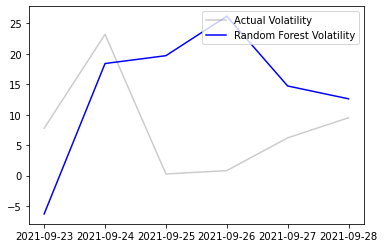

In [48]:
df = lag_dict["lag6_df"]

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year 
df['Month'] = df['Date'].dt.month 
df['Day'] = df['Date'].dt.day
df['dayofweek_num'] = df['Date'].dt.dayofweek

df = get_lags(1, 8, df)
df['rolling_mean'] = df['Obs_Vol'].rolling(window=7).mean()

df = df.dropna()
df1 = df.iloc[:, 3:]

lag_no = int(lag[3])
train = df[:-6].dropna()
test = df[-6:].dropna()

# Hyperparameter tuning
n_folds = 5

lgb_model = GridSearchCV(estimator=lgb.LGBMRegressor(),
                            param_grid=param_grid,
                            cv=KFold(n_splits=n_folds,
                                    shuffle=True),
                             scoring="neg_mean_squared_error")

lgb_model.fit(train[df1.columns], train["Obs_Vol"], eval_set=[(test[df1.columns], test["Obs_Vol"]),(train[df1.columns], train["Obs_Vol"])],
  verbose=20,eval_metric='logloss')

y_pred = lgb_model.predict(test[df1.columns])
mae = mean_absolute_error(test["Obs_Vol"], y_pred)
mse = mean_squared_error(test["Obs_Vol"], y_pred)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)

# Plotting estimated Random Forest volatility against actual volatility
pred_vol = pd.DataFrame(y_pred)
pred_vol.index = test['Date']
pred_vol = pred_vol.rename(columns={0: "Volatility"})

actual_vol = pd.DataFrame(test['Obs_Vol'])
actual_vol.index = test['Date']

# Plot the actual Bitcoin volatility
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(actual_vol['Obs_Vol'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

# Plot Random Forest estimated volatility
plt.plot(pred_vol['Volatility'], color = 'blue', label = 'Random Forest Volatility')

plt.legend(loc = 'upper right')
plt.show()

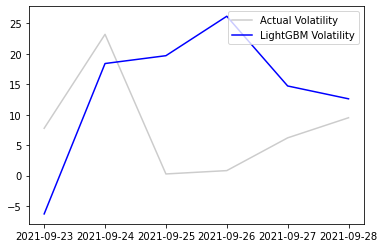

In [49]:
# Plot the actual Bitcoin volatility
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(actual_vol['Obs_Vol'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

# Plot Random Forest estimated volatility
plt.plot(pred_vol['Volatility'], color = 'blue', label = 'LightGBM Volatility')

plt.legend(loc = 'upper right')
plt.show()